In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    [
        "/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",
    ],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    **kwargs,
)

files = (
    [] + 
    file_fn(FILTER="F380M")[:2] +
    file_fn(FILTER="F430M")[:2] +
    file_fn(FILTER="F480M")[:2]
)

# files = files[:1]

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



6
  TARGPROP: HD-41094
  FILTER: F430M, F380M, F480M
  NINTS: 760, 905, 1060
  NGROUPS: 11, 20, 30
  OBSERVTN: 001
  NCHUNKS: 1


In [3]:
import jax.numpy as np

for file in files:
    file["SCI"].data[:, :, -1:] = np.nan
    file["SCI_VAR"].data[:, :, -1:] = np.nan
    file["ZPOINT"].data[:, -1:] = np.nan
    file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

In [4]:
# import jax.numpy as np

# for file in files:
#     print(file[0].header["FILENAME"])
#     nints = file[0].header["NINTS"]
#     ngroups = file[0].header["NGROUPS"]
#     print(nints)
#     print(ngroups)

    # # data = np.nansum(np.abs(np.asarray(file["SCI"].data, float)), 0)
    # data = np.sum(np.asarray(file["SCI"].data, float), 0)
    # var = np.sum(np.asarray(file["SCI_VAR"].data, float), 0)

    # nphot_per_im = np.nansum(data)
    # nphot_tot = nints * nphot_per_im
    # print(nphot_tot * 1e-6)

    # plt.figure(figsize=(20, 4))
    # plt.subplot(1, 4, 1)
    # plt.title("Data")
    # plt.imshow(data)
    # plt.colorbar()

    # plt.subplot(1, 4, 2)
    # plt.title("Log10 Data")
    # plt.imshow(np.log10(data))
    # plt.colorbar()

    # plt.subplot(1, 4, 3)
    # plt.title("Variance")
    # # plt.imshow(file["SCI_VAR"].data.sum(0) * nints)
    # plt.imshow(var)
    # plt.colorbar()

    # plt.subplot(1, 4, 4)
    # plt.title("Log10 Variance")
    # # plt.imshow(np.log10(file["SCI_VAR"].data.sum(0) * nints))
    # plt.imshow(np.log10(var))
    # plt.colorbar()
    # plt.show()

    # # data = np.nansum(np.abs(np.asarray(file["SCI"].data, float)), 0)
    # psf_est = np.asarray(file["SCI"].data, float)[0]
    # # var = np.sum(np.asarray(file["SCI_VAR"].data, float), 0)
    # zpoint = np.asarray(file["ZPOINT"].data, float)
    # zpoint_var = np.asarray(file["ZPOINT_VAR"].data, float)

    # plt.figure(figsize=(20, 4))
    # plt.subplot(1, 4, 1)
    # plt.title("Bias Estimate")
    # plt.imshow(zpoint - psf_est)
    # plt.colorbar()

    # plt.subplot(1, 4, 2)
    # plt.title("Bias Est Histogram")
    # # plt.imshow(np.log10(zpoint - psf_est))
    # plt.hist((zpoint - psf_est).flatten(), bins=50)

    # plt.subplot(1, 4, 3)
    # plt.title("Zero-Point Variance")
    # # plt.imshow(file["SCI_VAR"].data.sum(0) * nints)
    # plt.imshow(zpoint_var)
    # plt.colorbar()

    # plt.subplot(1, 4, 4)
    # plt.title("Log10 Zero-Point Variance")
    # # plt.imshow(np.log10(file["SCI_VAR"].data.sum(0) * nints))
    # plt.imshow(np.log10(zpoint_var))
    # plt.colorbar()
    # plt.show()

In [5]:
import jax.numpy as np
from amigo.core import AmigoModel
from amigo.optics import AMIOptics
from amigo.detectors import LinearDetectorModel, ReadModel, SimpleRamp
from amigo.files import get_exposures, initialise_params

optics = AMIOptics()
detector = LinearDetectorModel()
ramp_model = SimpleRamp()
read_model = ReadModel()

# Prep the model
exposures = get_exposures(files)
params = initialise_params(exposures, optics)
model = AmigoModel(files, params)

In [17]:
from amigo.non_linear import NonLinCNN

convEDM = NonLinCNN(model, widths=[16, 8, 4, 4], amplitude=1.)

Field of Regard: 21


In [7]:
from amigo.fisher import calc_fishers

params = [
    "positions",
    "aberrations",
    "fluxes",
    "one_on_fs",
    "rotation",
    "compression",
    "shear",
    "translation",
    "f2f",
    "holes",
    "dark_current",
    "jitter.r",
    # "anisotropy.compression",
    # "SRF",
    # "ipc",
    # "FF",
]
fishers = calc_fishers(model, exposures, params)

In [8]:
def grad_fn(model, grads, args, key):
    # grads = jax.tree_map(lambda x: np.where(np.isnan(x), 0.0, x), grads)
    if grads.holes is not None:
        grads = grads.set("holes", grads.holes * np.ones((7, 2)).at[:3, :].set(0))
    return grads, key


def norm_fn(model, model_params, args, key):
    """
    Note this function is somewhat dubious, as it is applied after the opt_state object
    is created, so there could be a divergence between the higher-order optimiser values
    and the model parameters. The proper way do this is to also update the opt_state
    object, but I dont know how to do this yet.
    """
    # print("inside model norm")
    return model_params, key
    p = 0.00005
    # p = 0.
    keys = jr.split(args['key'], 2)
    #
    conv_weight_map = jr.uniform(keys[0], model_params.BFE.conv.weights.shape)
    conv_bias_map = jr.uniform(keys[1], model_params.BFE.conv.biases.shape)
    conv_new_weight = np.where(conv_weight_map > p, model_params.BFE.conv.weights, 0)
    conv_new_bias = np.where(conv_bias_map > p, model_params.BFE.conv.biases, 0)
    #
    model_params = model_params.set(
        ["BFE.conv.weights", "BFE.conv.biases"],
        [conv_new_weight, conv_new_bias],
    ) 
    return model_params, key
    # reflect = model_params.holes.reflectivity
    # return model_params.set("holes.reflectivity", reflect - reflect.mean())
    # SRF = model_params.sensitivity.SRF
    # return model_params.set("sensitivity.SRF", SRF - SRF.mean() + 1)


# def args_fn(model, args, key, i):
#     return model, args, jr.split(key, 1)[0]

In [18]:
from amigo.fitting import optimise
import jax.random as jr
import optax

def scheduler(lr, start, *args):
    shed_dict = {start: 1e100}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e100, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)
base_adam = lambda vals: optax.adam(vals)

sgd = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))
adam = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

batch_size = 1
nbatch = len(exposures) // batch_size
if len(exposures) % batch_size != 0:
    nbatch += 1
optimisers = {
    "positions": sgd(5e-1, 0),
    "aberrations": sgd(5e-2, 5),
    "fluxes": sgd(2e-1, 10),
    "f2f": sgd(2e-1, 15),
    "translation": sgd(5e-2, 15),
    "compression": sgd(2e-1, 15),
    "rotation": sgd(2e-1, 15),
    "shear": sgd(2e-1, 15),
    # Coherence
    "dark_current": sgd(2e-1, 20),
    "jitter.r": sgd(5e-1, 20),
    "holes": sgd(2e-1, 25),
    "ramp.conv.values": adam(2e-3, 30 * nbatch),
    "ramp.amplitude": adam(2e-3, 40 * nbatch),
    "one_on_fs": sgd(0, 10),
}

# model = model.set("ramp", None)
model = model.set("ramp", convEDM)


# Optimisation
final_model, losses, histories, states = optimise(
    model,
    exposures,
    optimisers,
    epochs=60,
    key=jr.PRNGKey(0),
    fishers=fishers,
    grad_fn=grad_fn,
    norm_fn=norm_fn,
    # args_fn=args_fn,
    print_grads=False,
    batch_size=batch_size,
    batch_params=["ramp.conv.values", "ramp.amplitude"],
    save_every=100,   
    # save_ext='test'
)

  0%|          | 0/60 [00:00<?, ?it/s]

Grad Batch fn compiling...
Compiling update function
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Compiling update function
Compile Time: 0:06:19
Initial Loss: 5,398.66
Est time per epoch:  0:01:26
Est run remaining:  1:31:06
Full Time: 1:31:27
Final Loss: 36.92


36.91570443181145
[40.10919783 42.13131354 34.22310118 34.78104011 35.47865063 34.7709233 ]


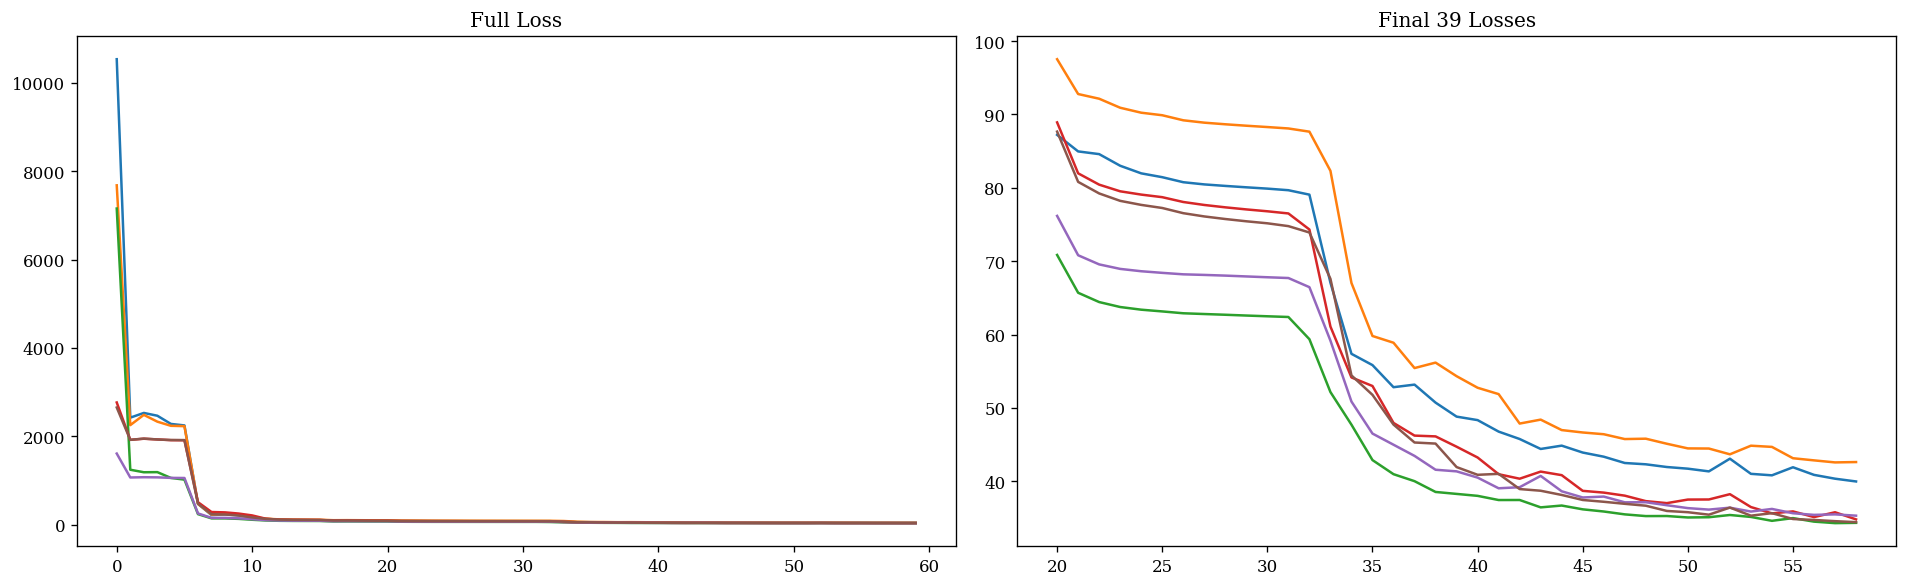

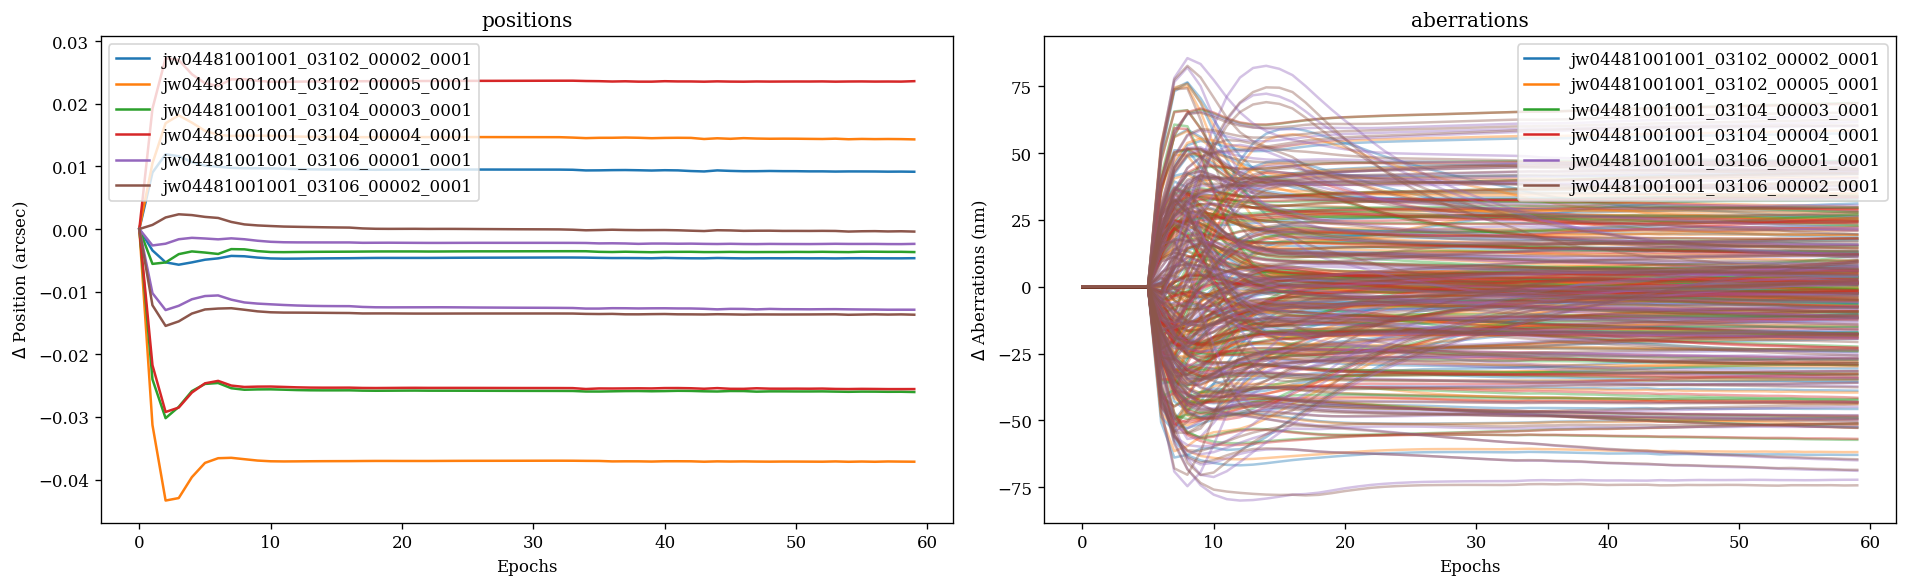

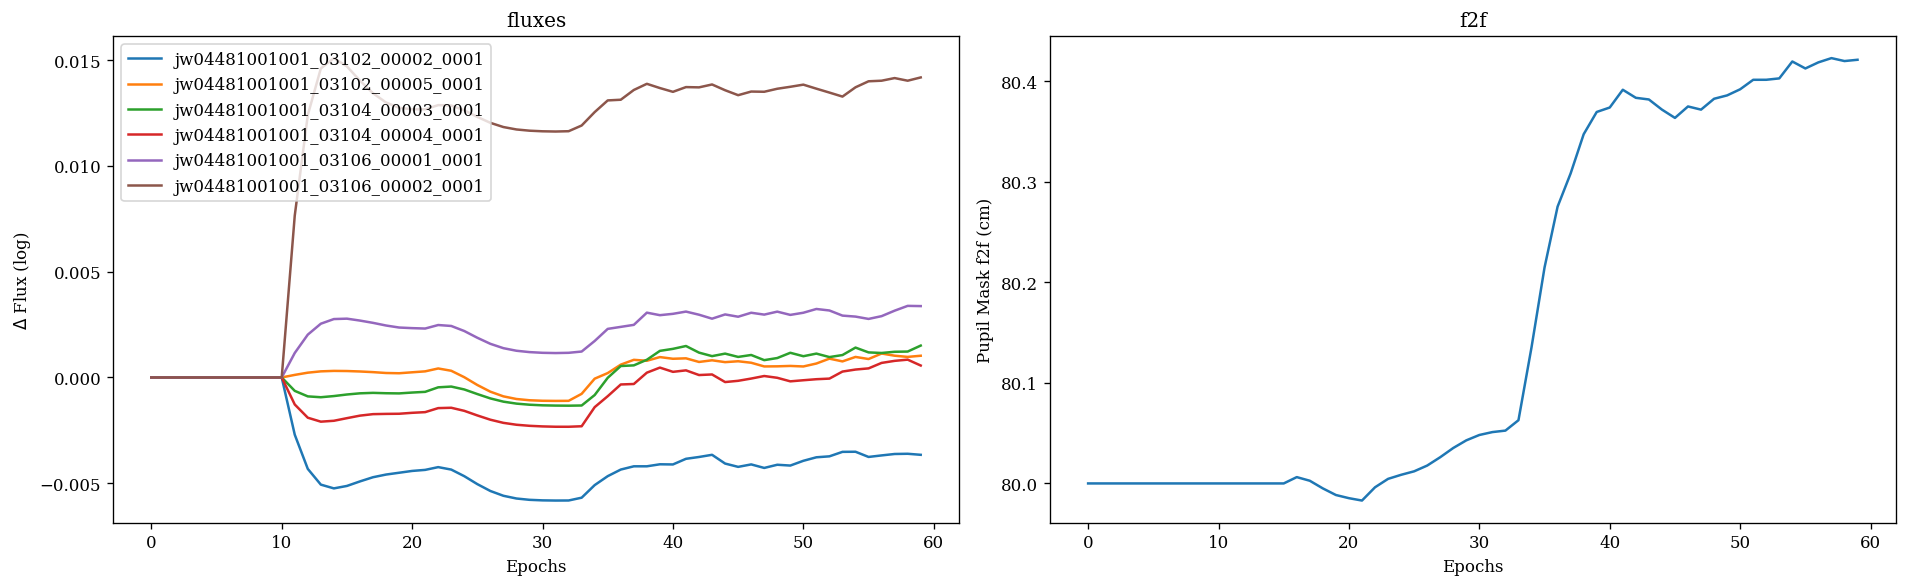

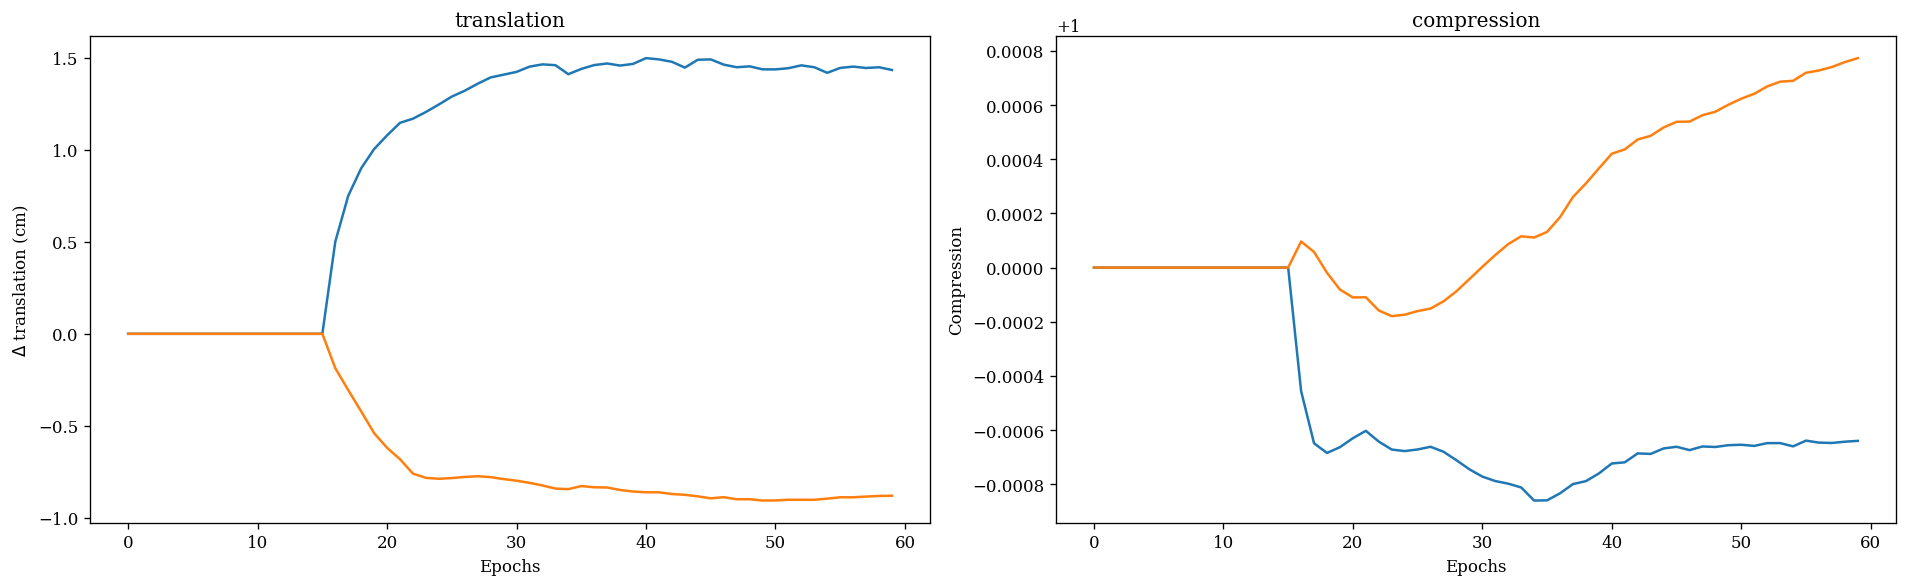

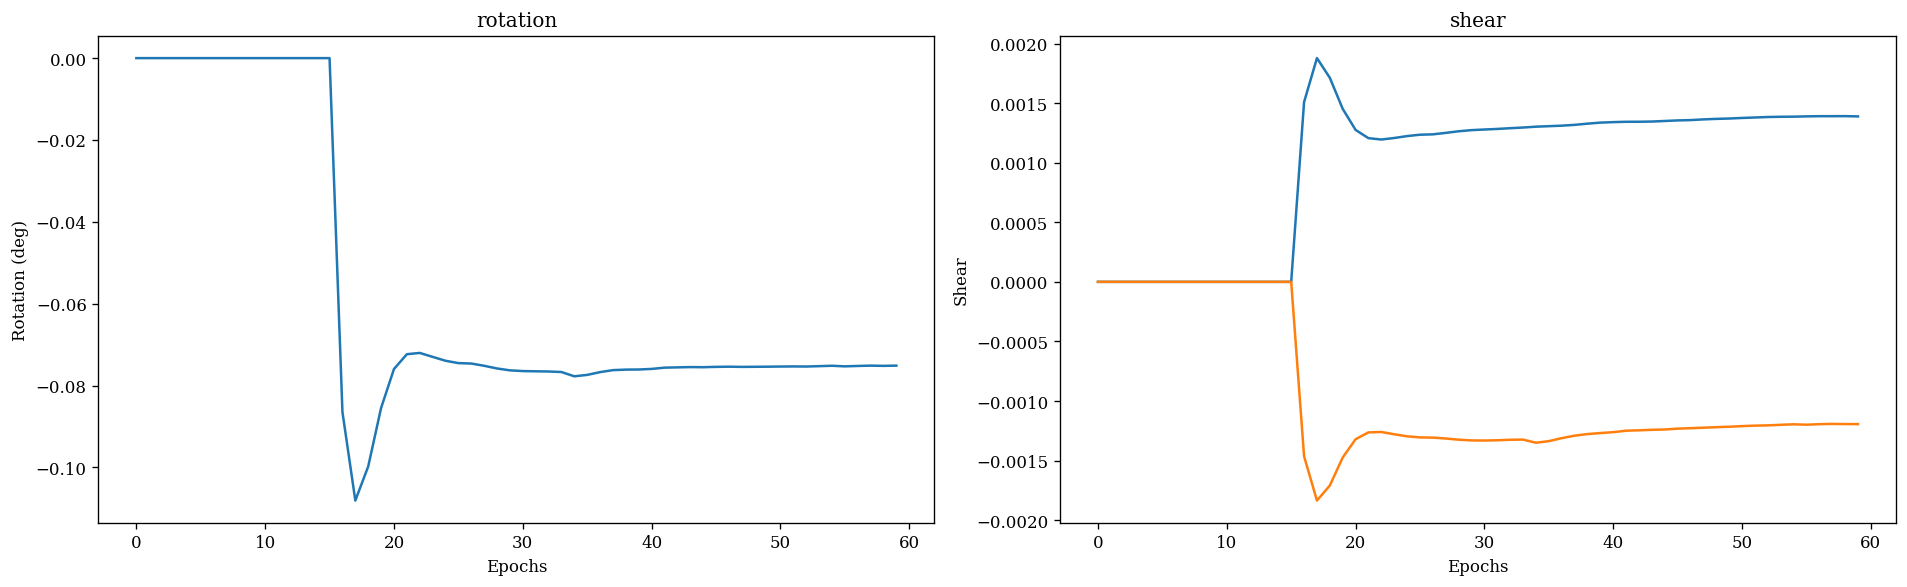

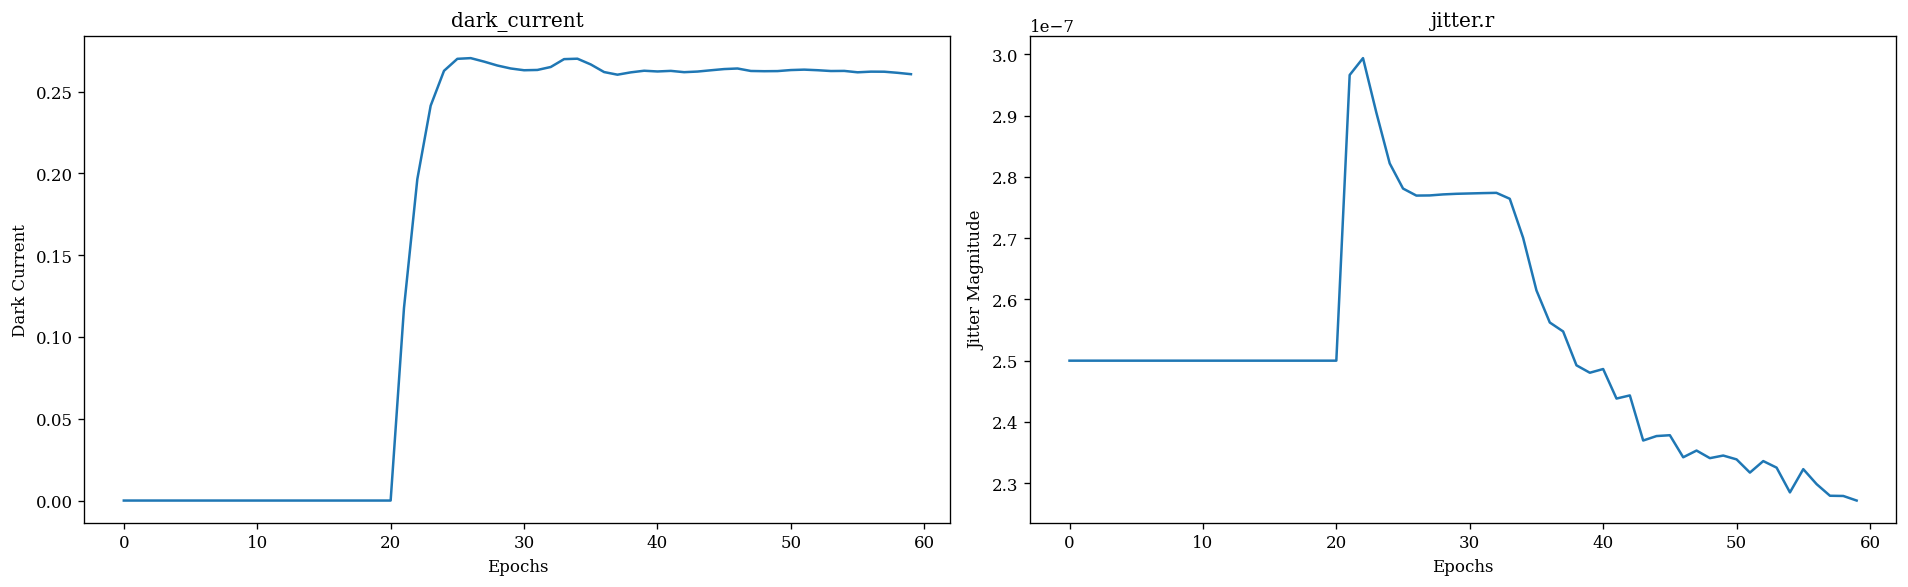

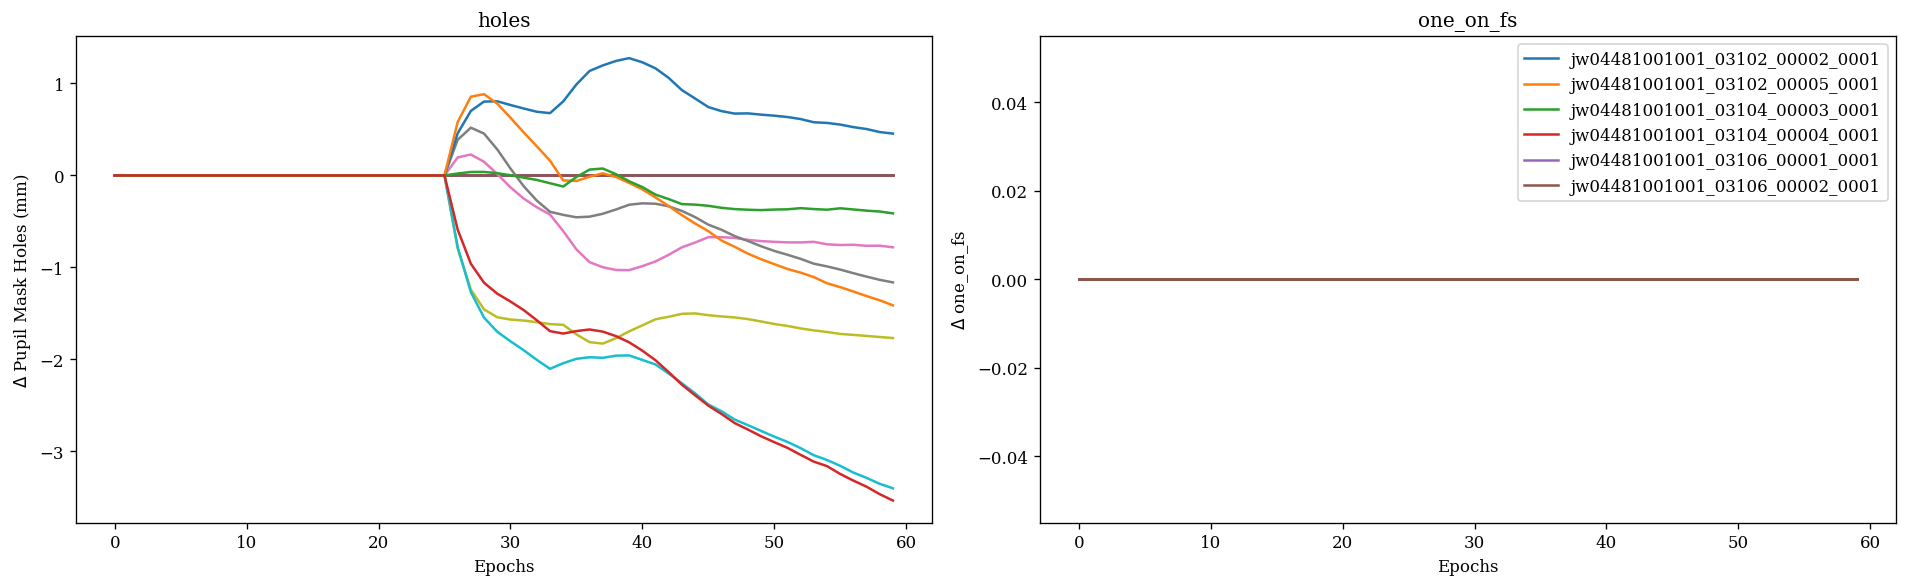

No formatting function for ramp.conv.values
No formatting function for ramp.amplitude


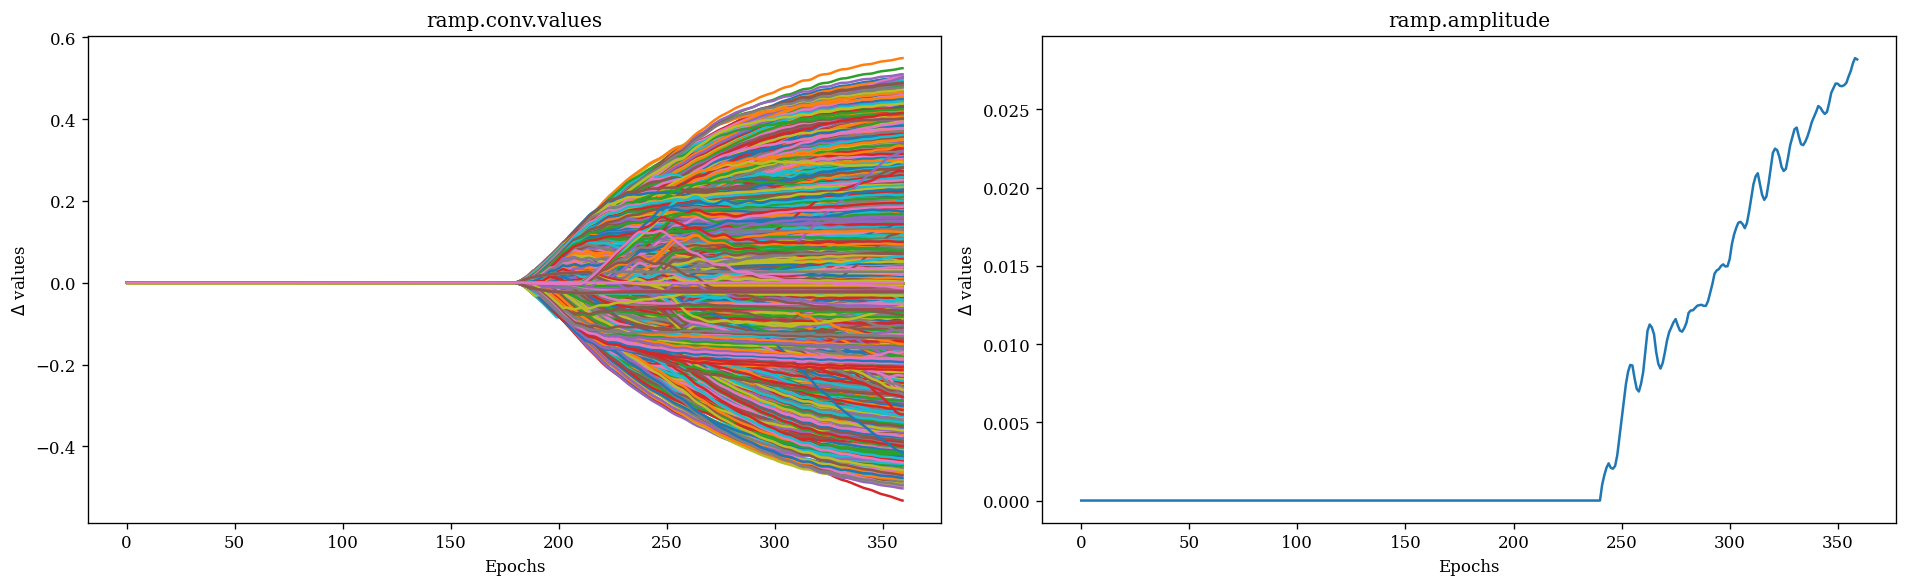

In [19]:
from amigo.plotting import plot, plot_losses

print(losses[-1].mean())
print(losses[-1])

key_fn = lambda exp: f"{exp.ngroups:<3} {exp.nints} {np.nanmean(exp.data[-1]):<5.0f}"

plot_losses(losses, start=20)

for history in histories:
    plot(history)

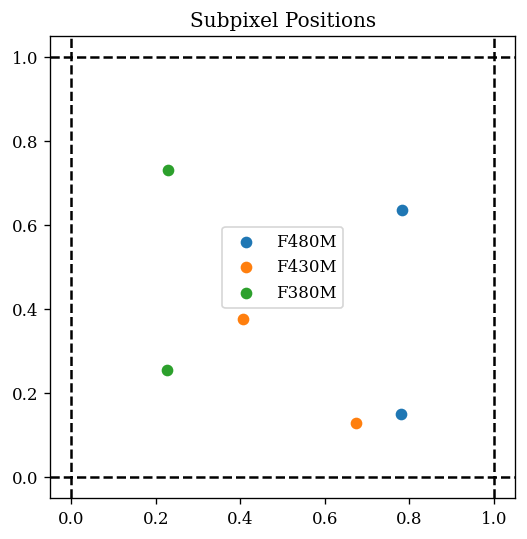

In [20]:
import jax.tree_util as jtu

subpix_pos = jtu.tree_map(
    lambda x: (x / model.optics.psf_pixel_scale) % 1, final_model.positions
)

colour_dict = {
    "F480M": "tab:blue",
    "F430M": "tab:orange",
    "F380M": "tab:green",
}

plt.figure(figsize=(5, 5))
plt.title("Subpixel Positions")
for exp in exposures:
    plt.scatter(*subpix_pos[exp.key], c=colour_dict[exp.filter])

for filter, col in colour_dict.items():
    plt.scatter([], [], c=col, label=filter)

plt.legend()

plt.axhline(0, color="k", linestyle="--")
plt.axvline(0, color="k", linestyle="--")
plt.axhline(1, color="k", linestyle="--")
plt.axvline(1, color="k", linestyle="--")
plt.show()

File jw04481001001_03104_00003_0001
Star HD-41094
Filter F380M
nints 1060
ngroups 11



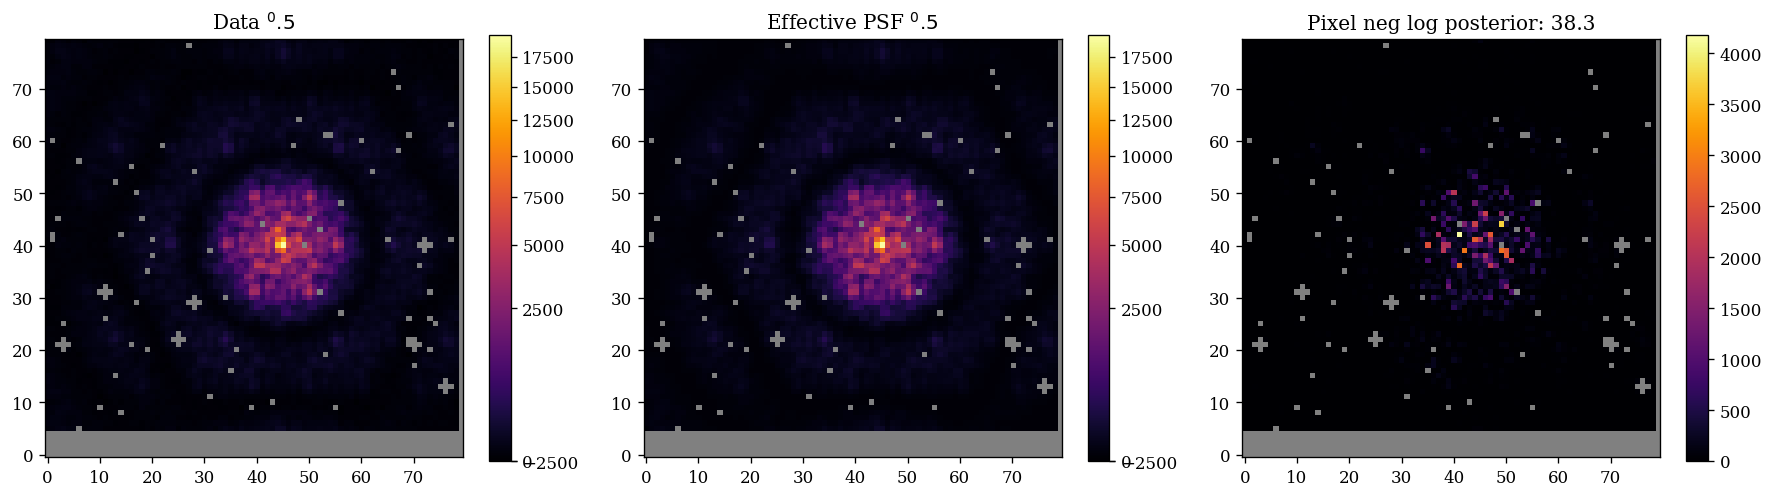

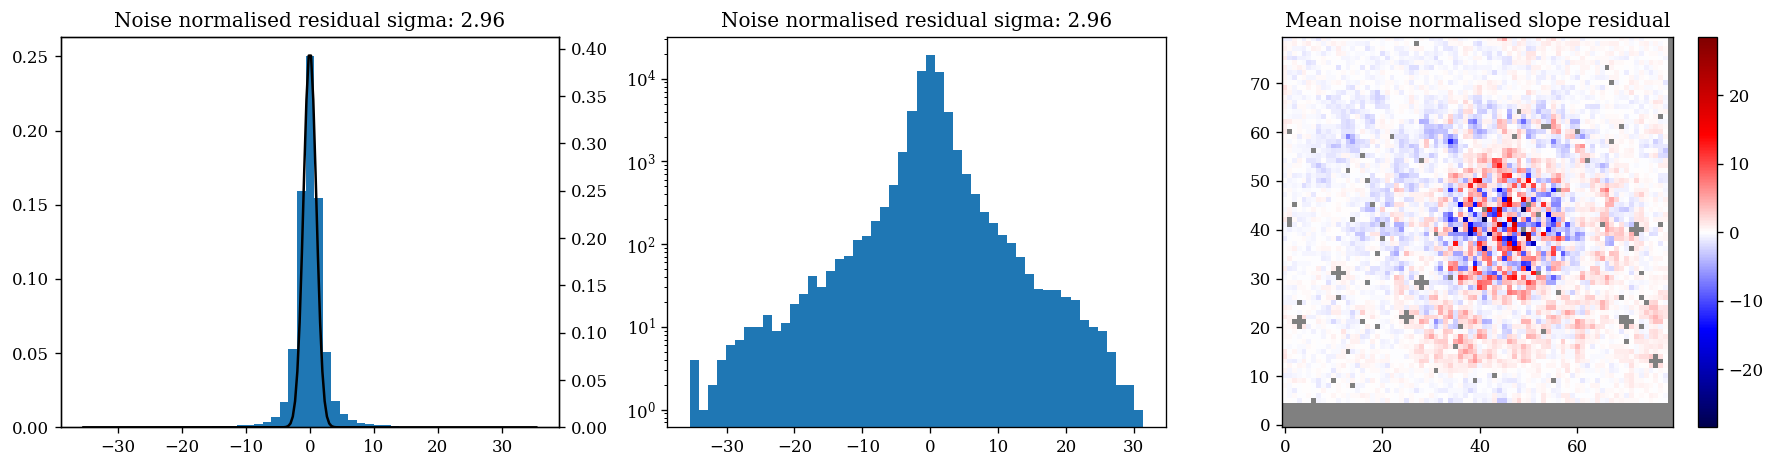

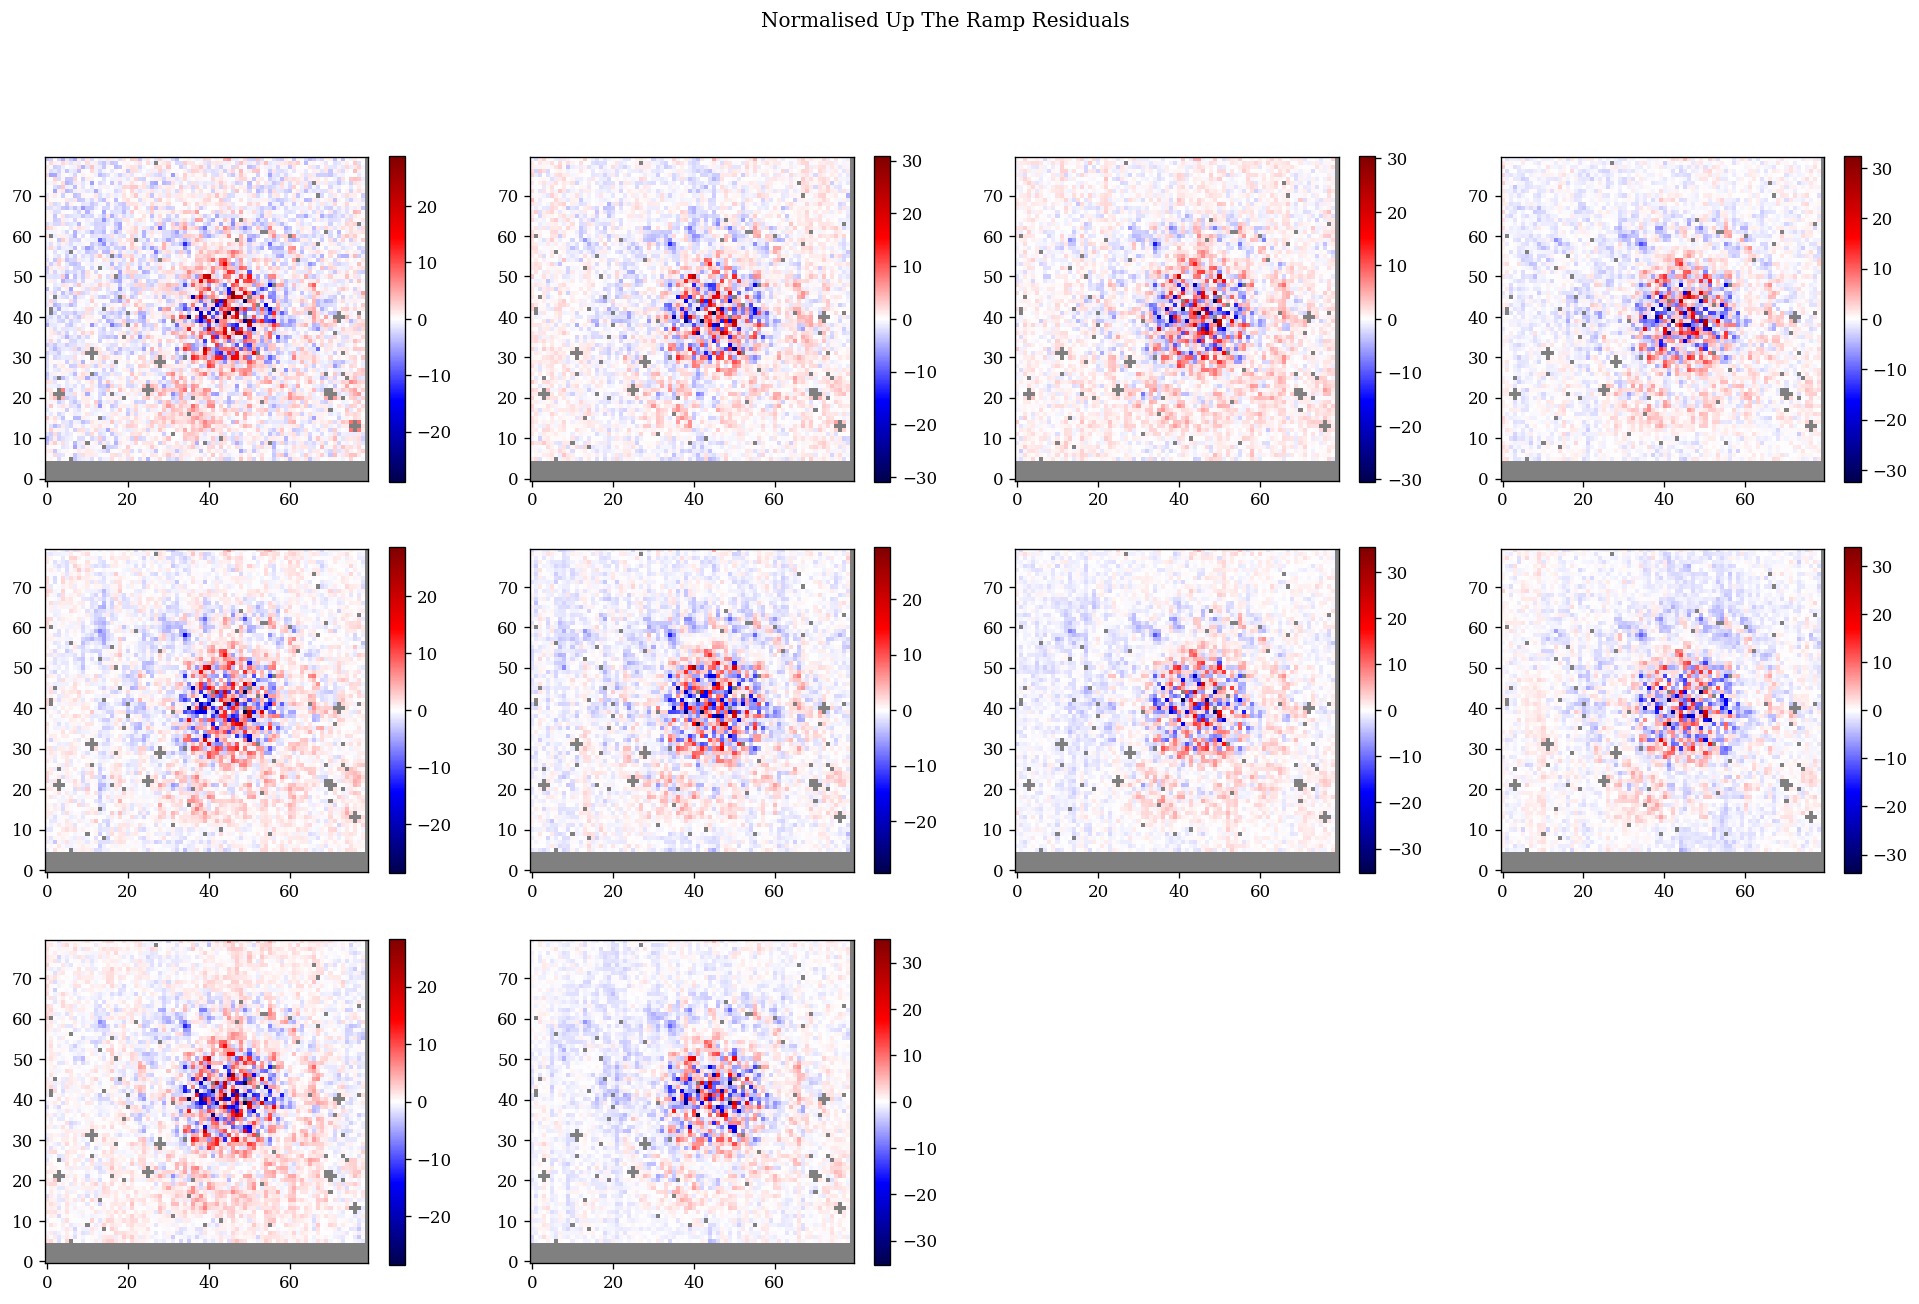

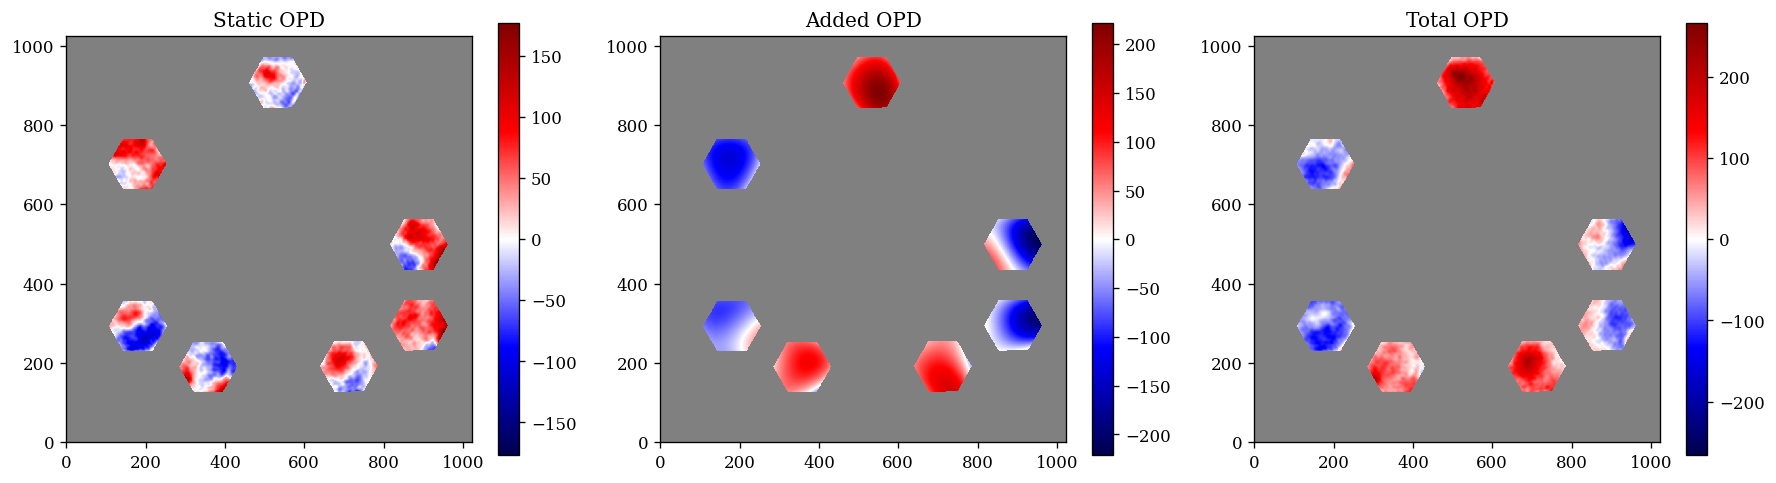

File jw04481001001_03104_00004_0001
Star HD-41094
Filter F380M
nints 1060
ngroups 11



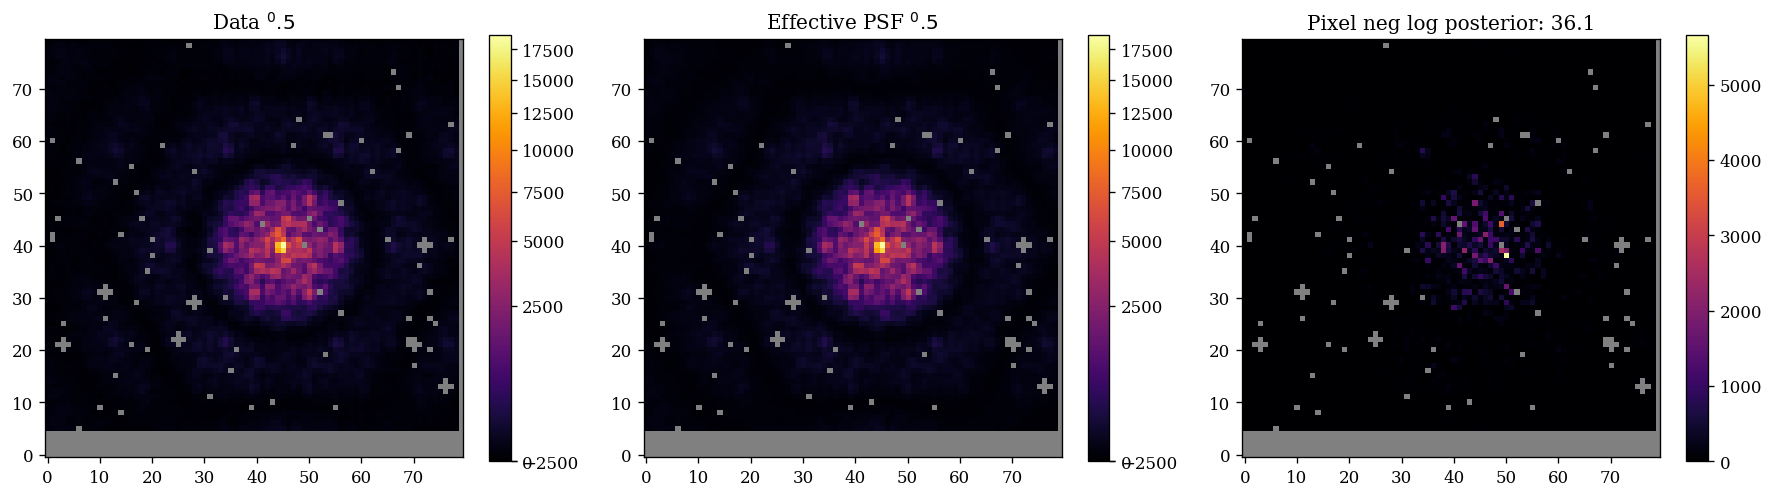

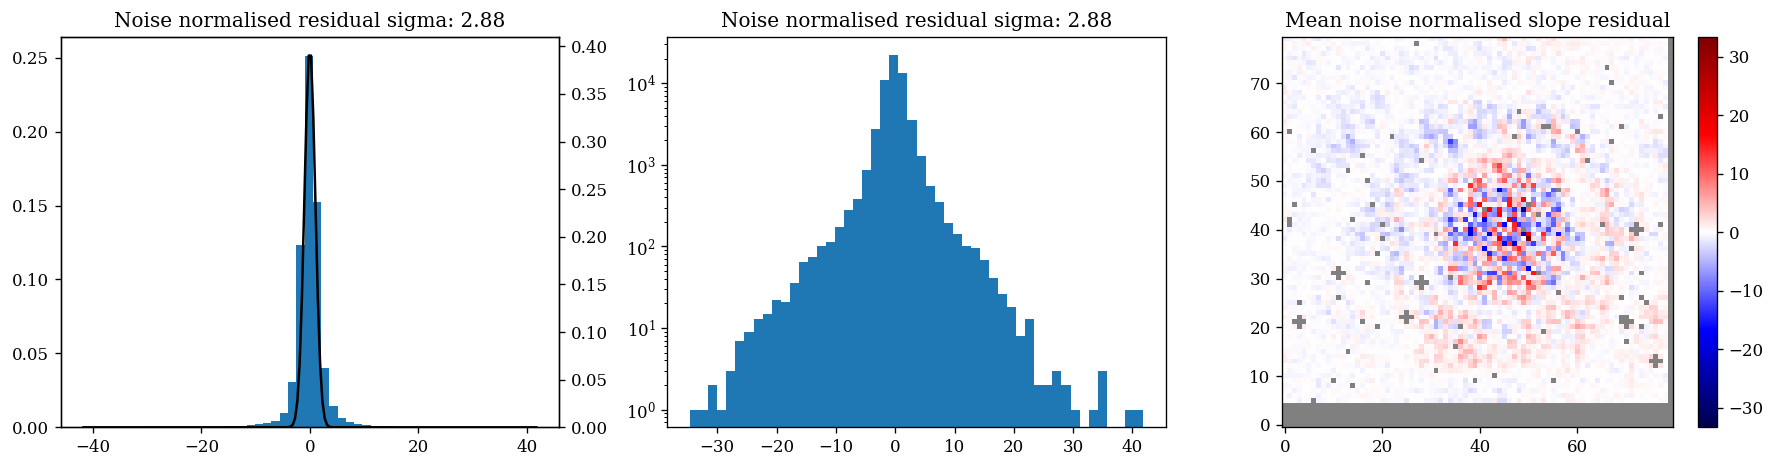

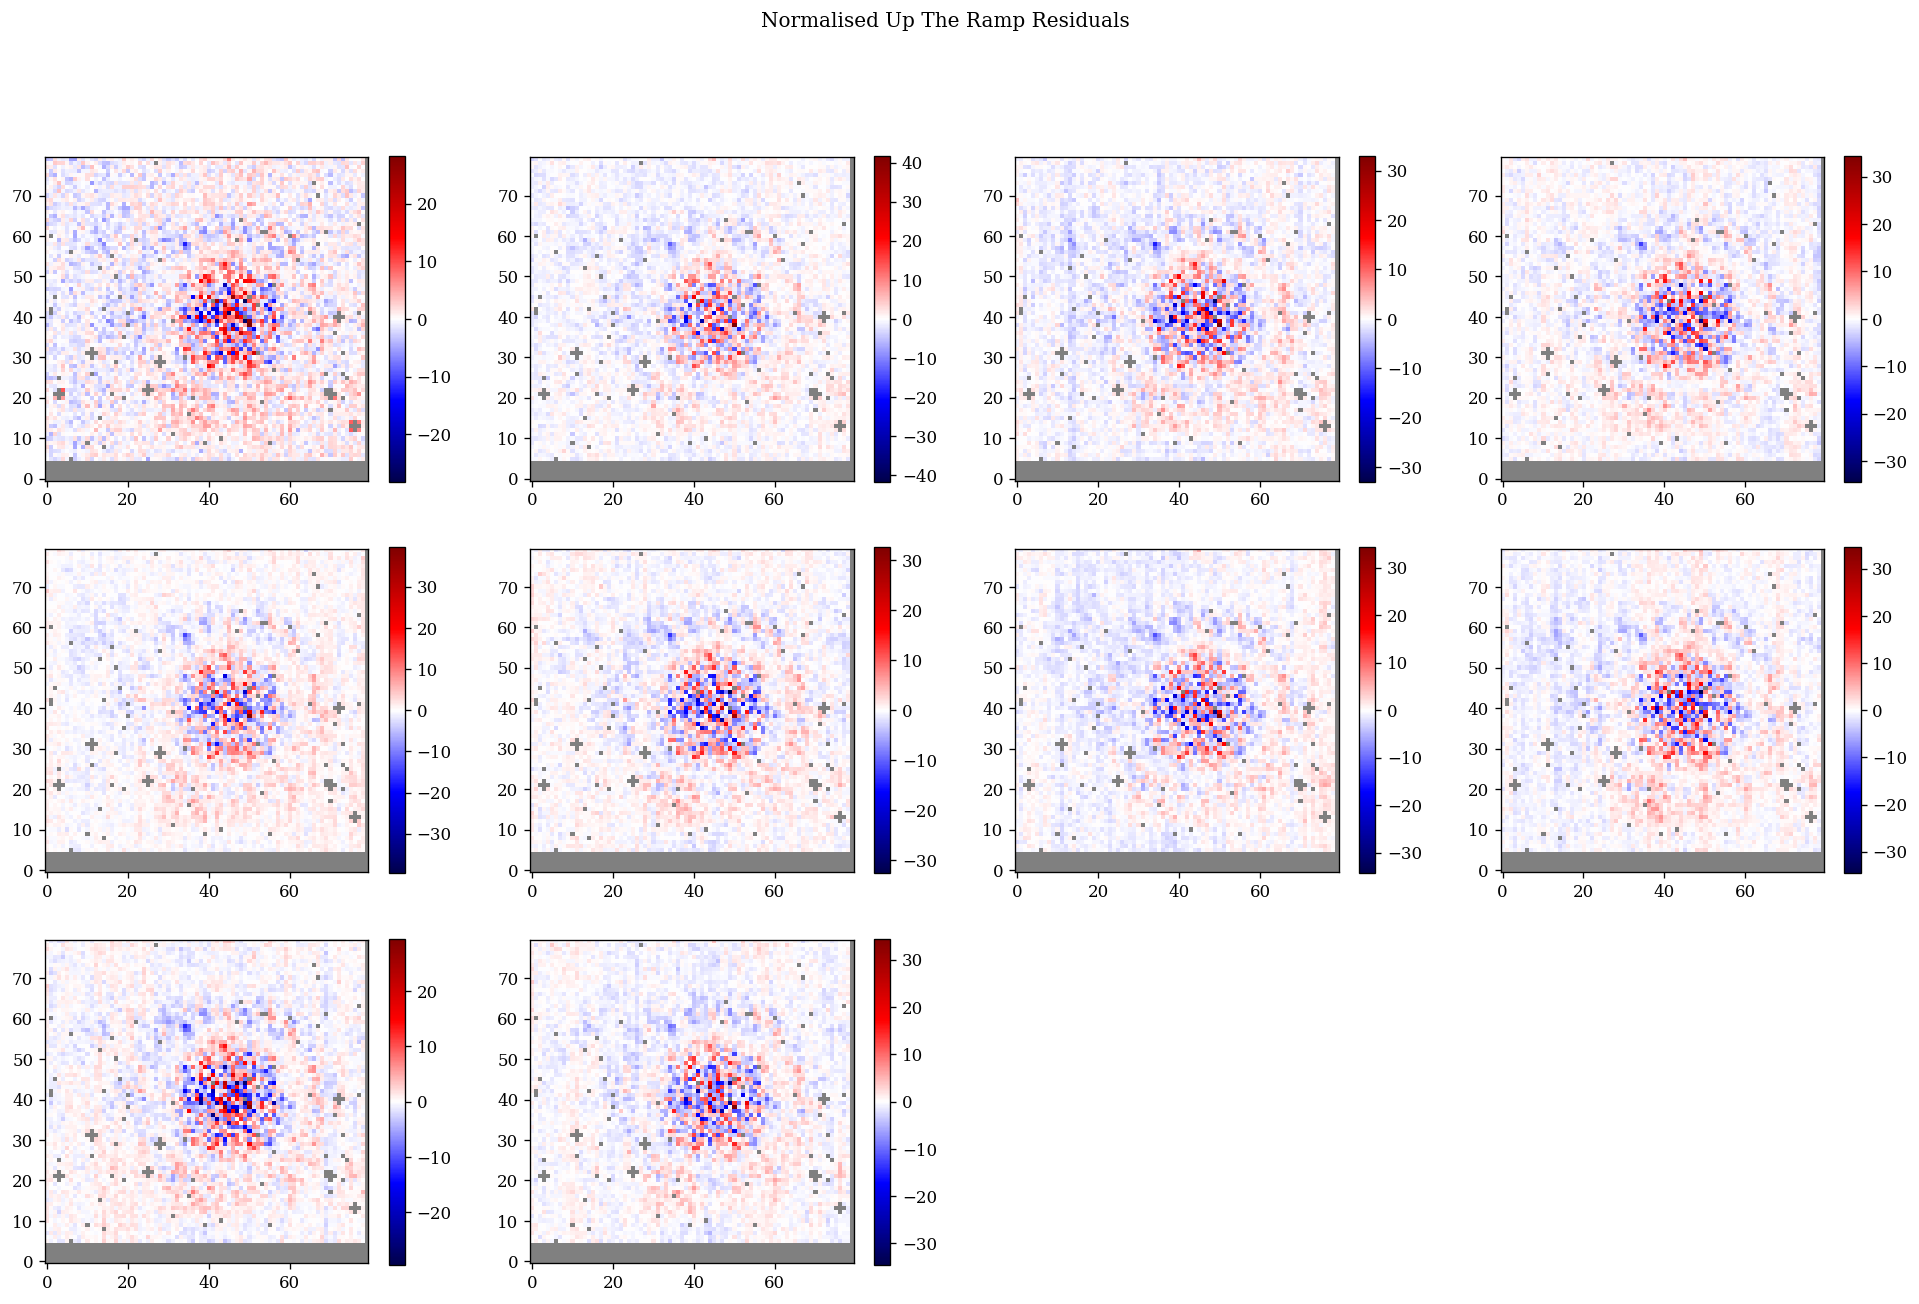

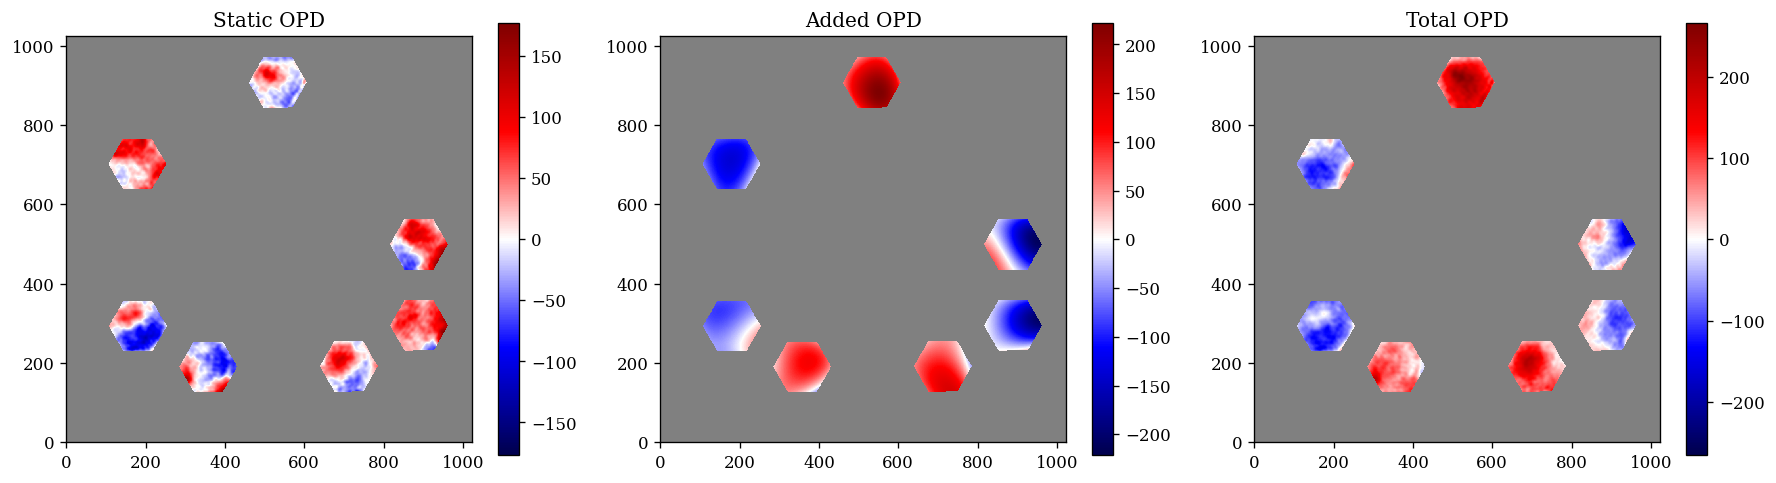

File jw04481001001_03106_00001_0001
Star HD-41094
Filter F430M
nints 905
ngroups 20



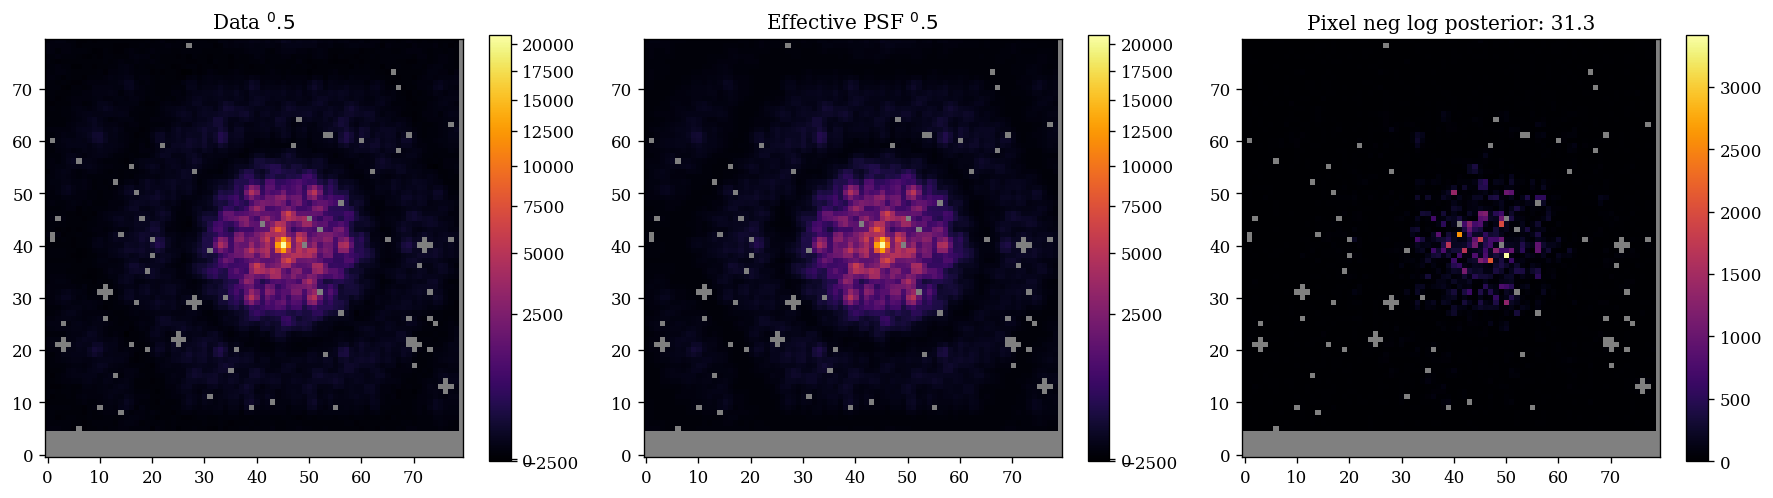

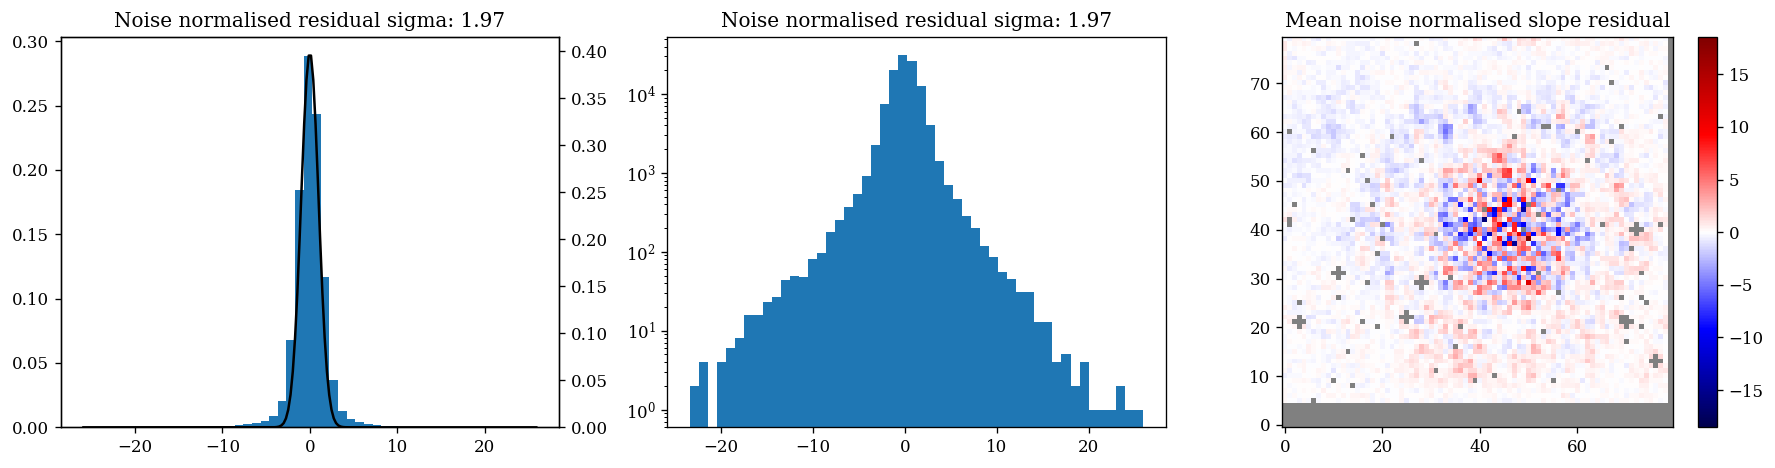

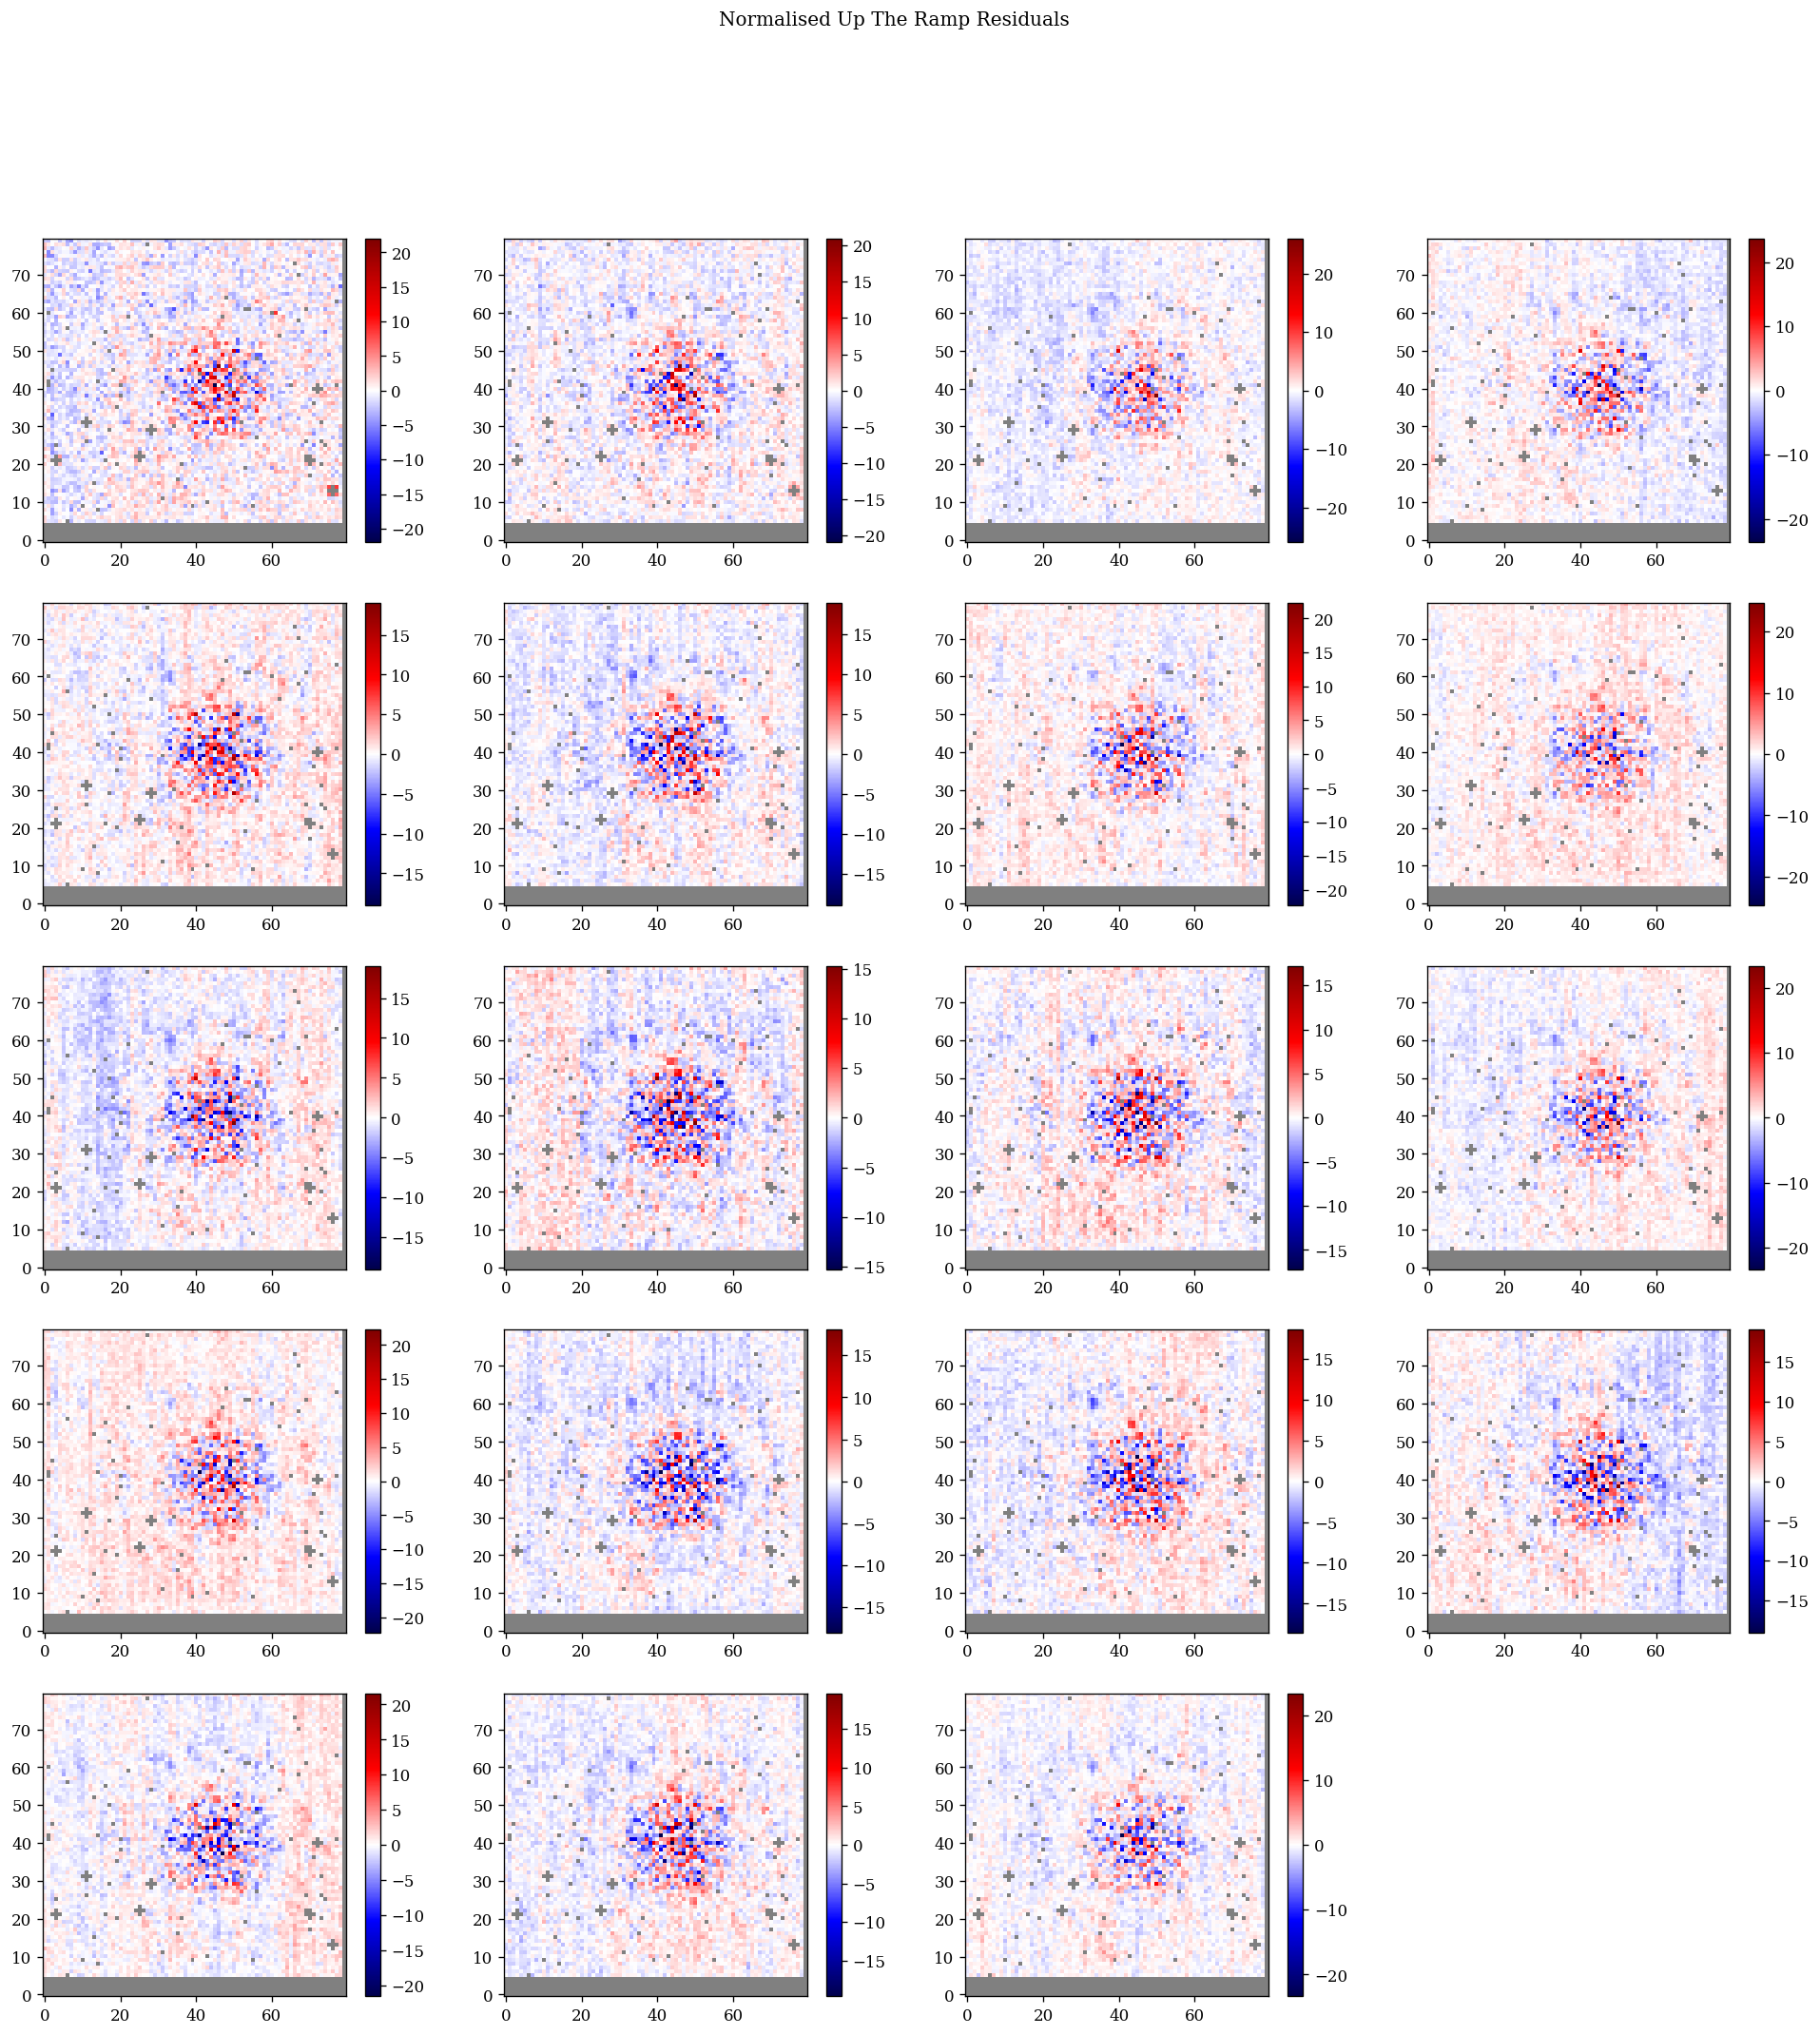

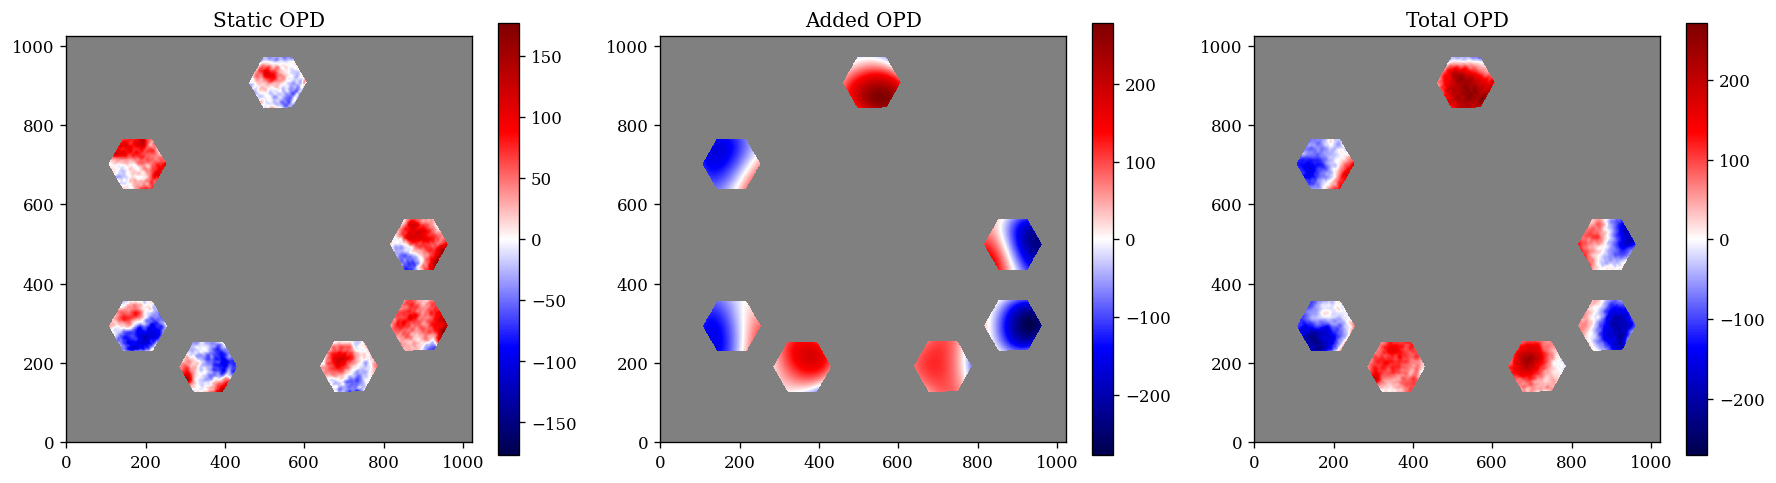

File jw04481001001_03106_00002_0001
Star HD-41094
Filter F430M
nints 905
ngroups 20



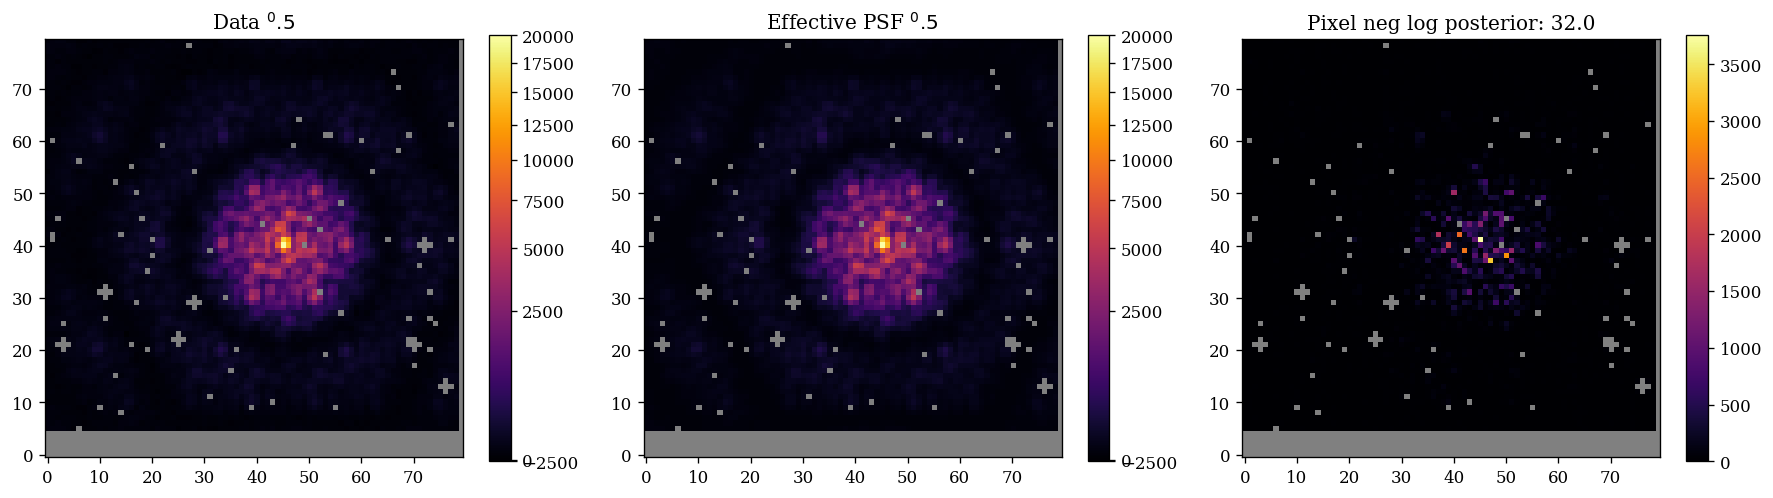

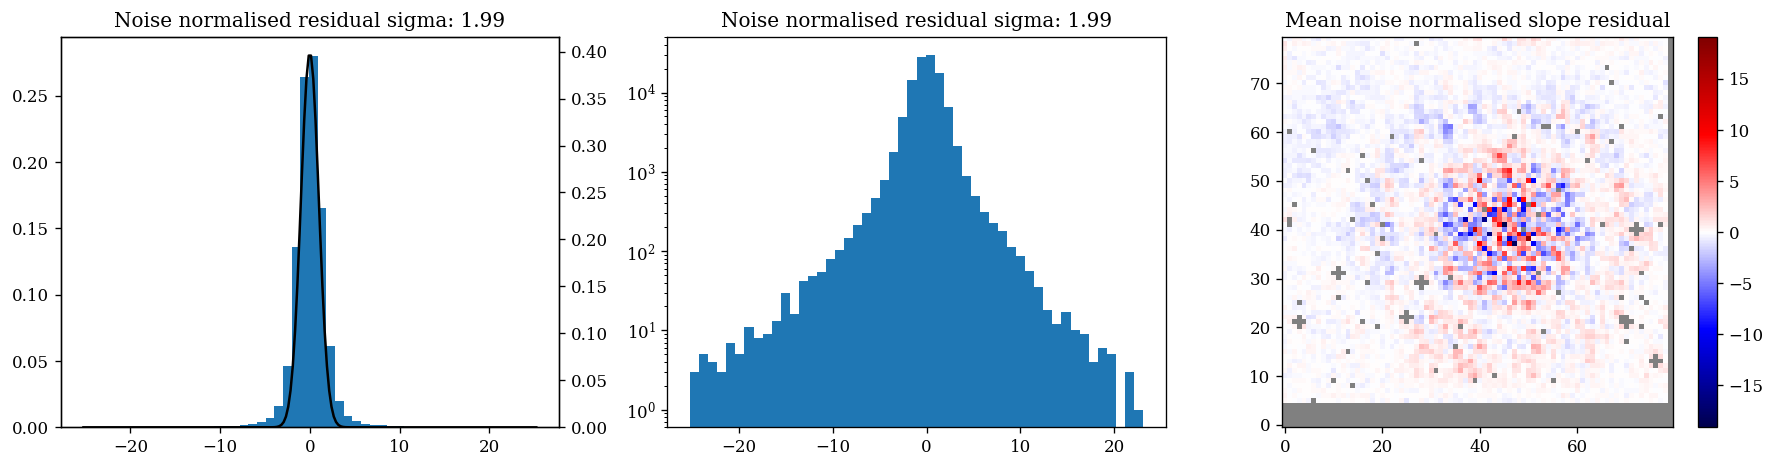

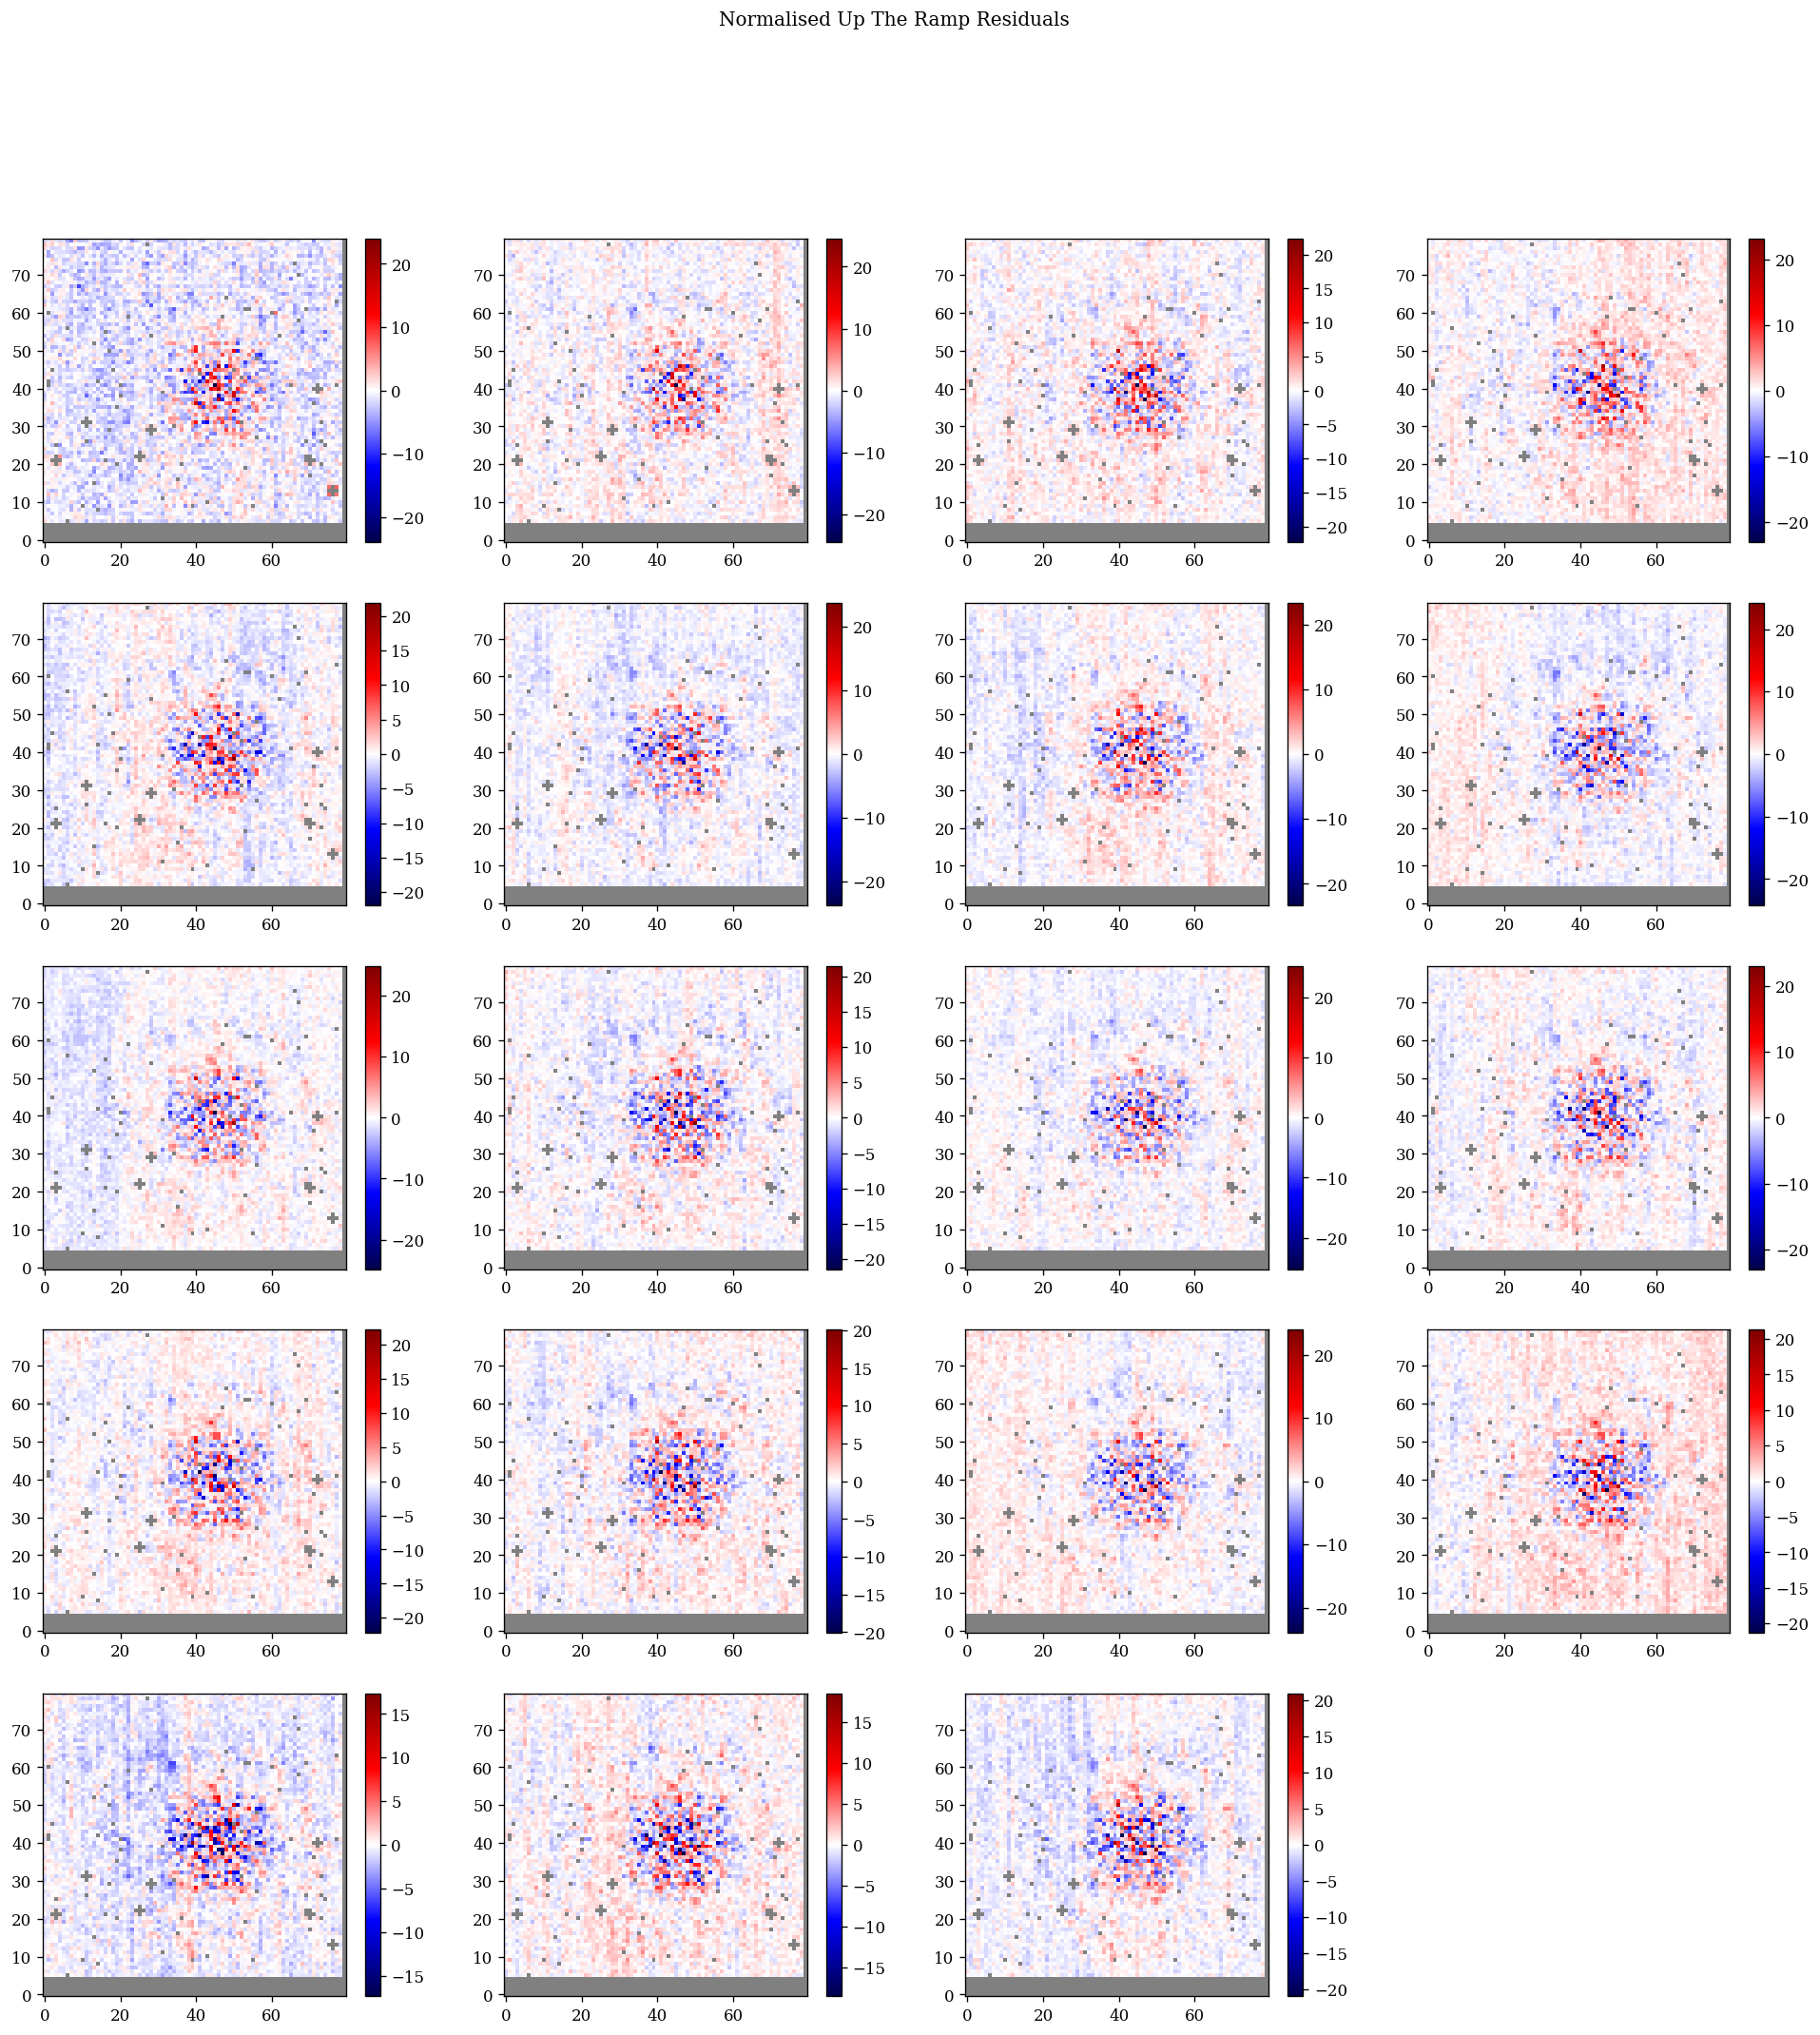

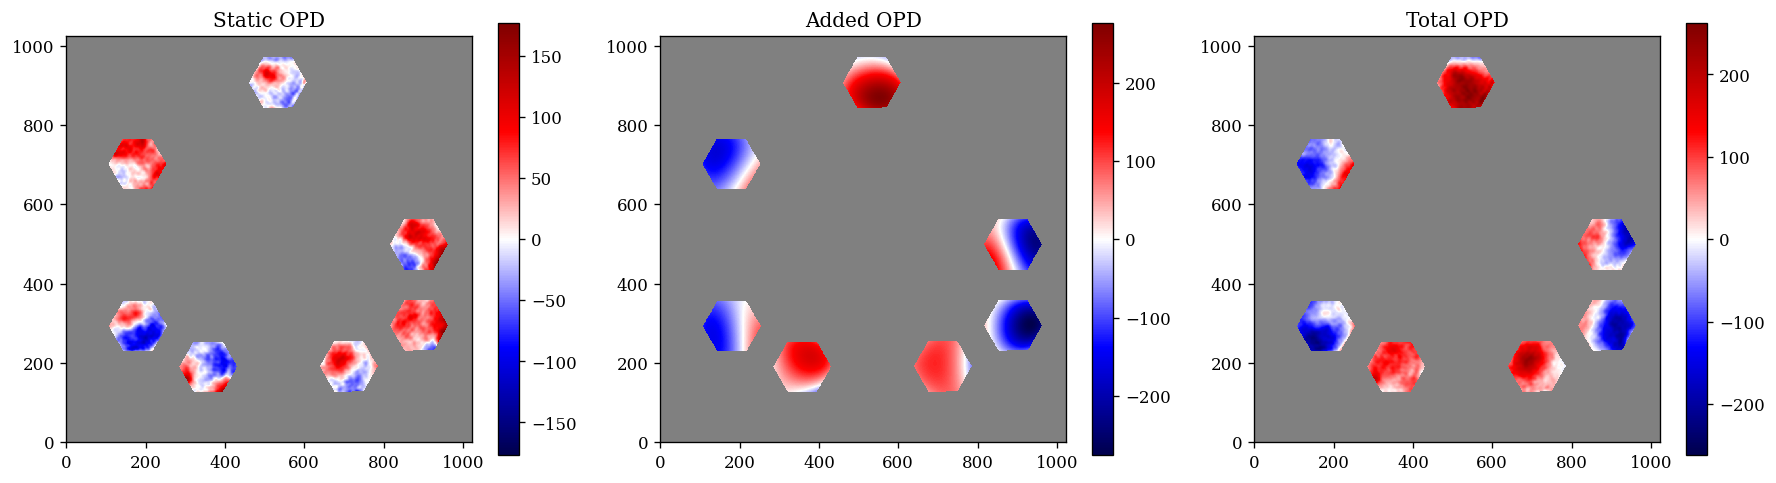

File jw04481001001_03102_00005_0001
Star HD-41094
Filter F480M
nints 760
ngroups 30



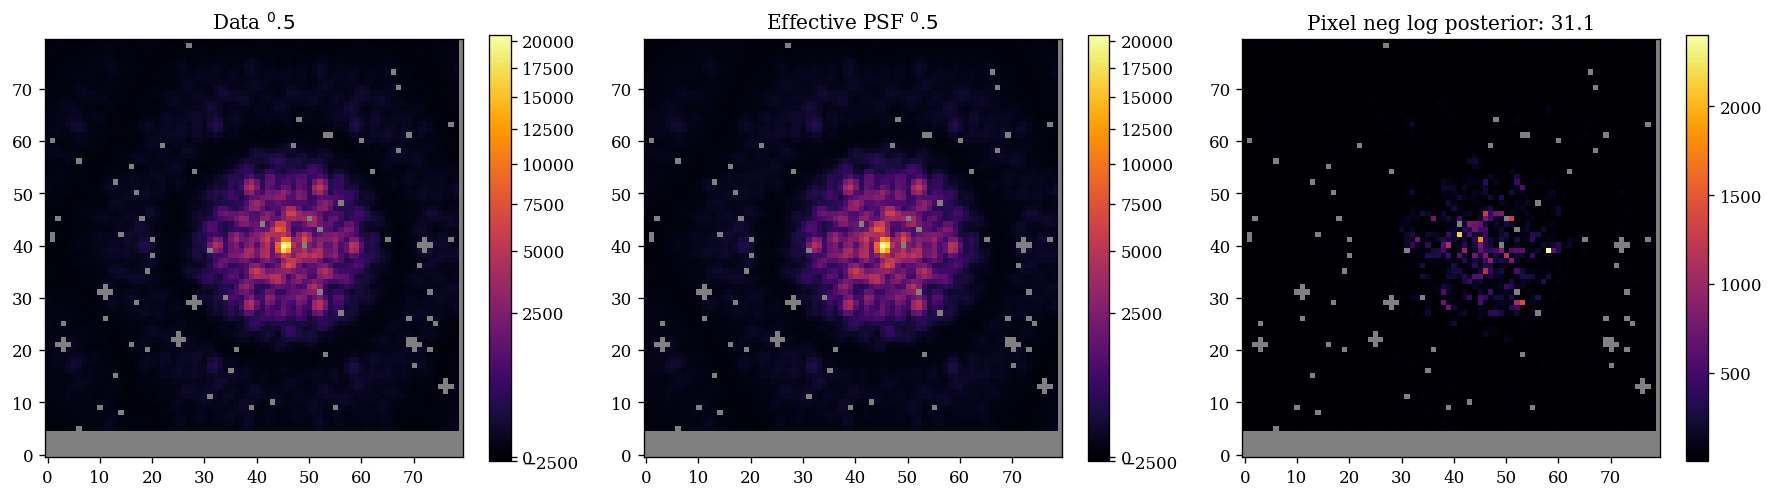

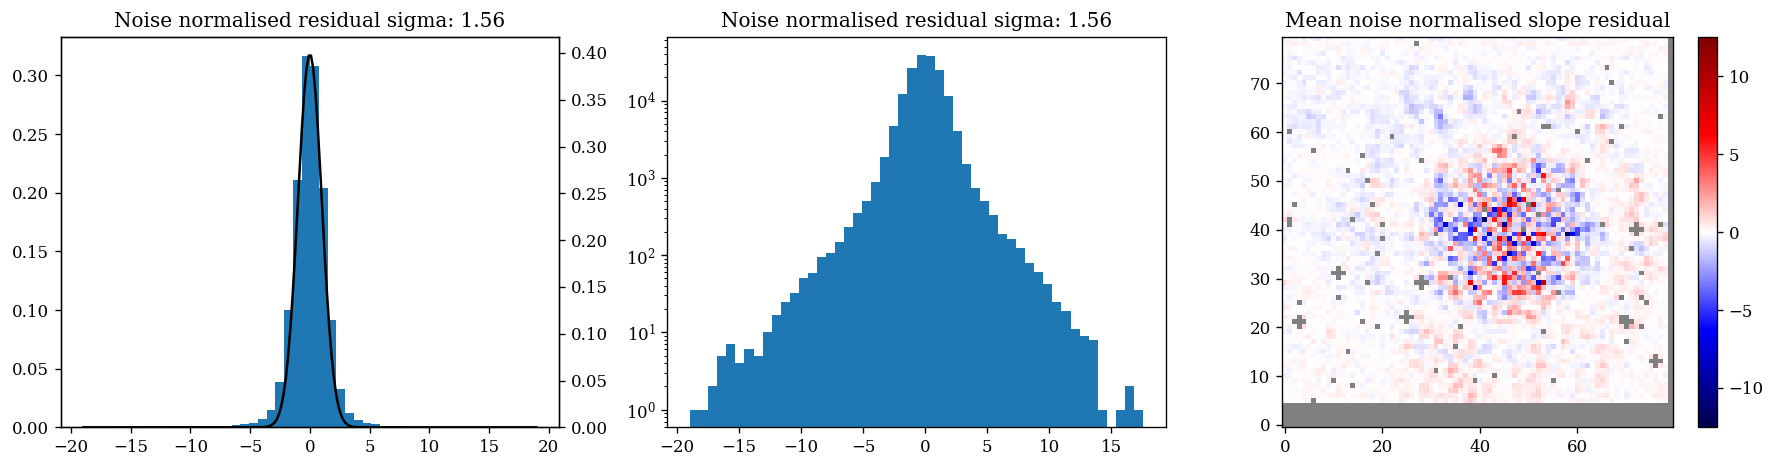

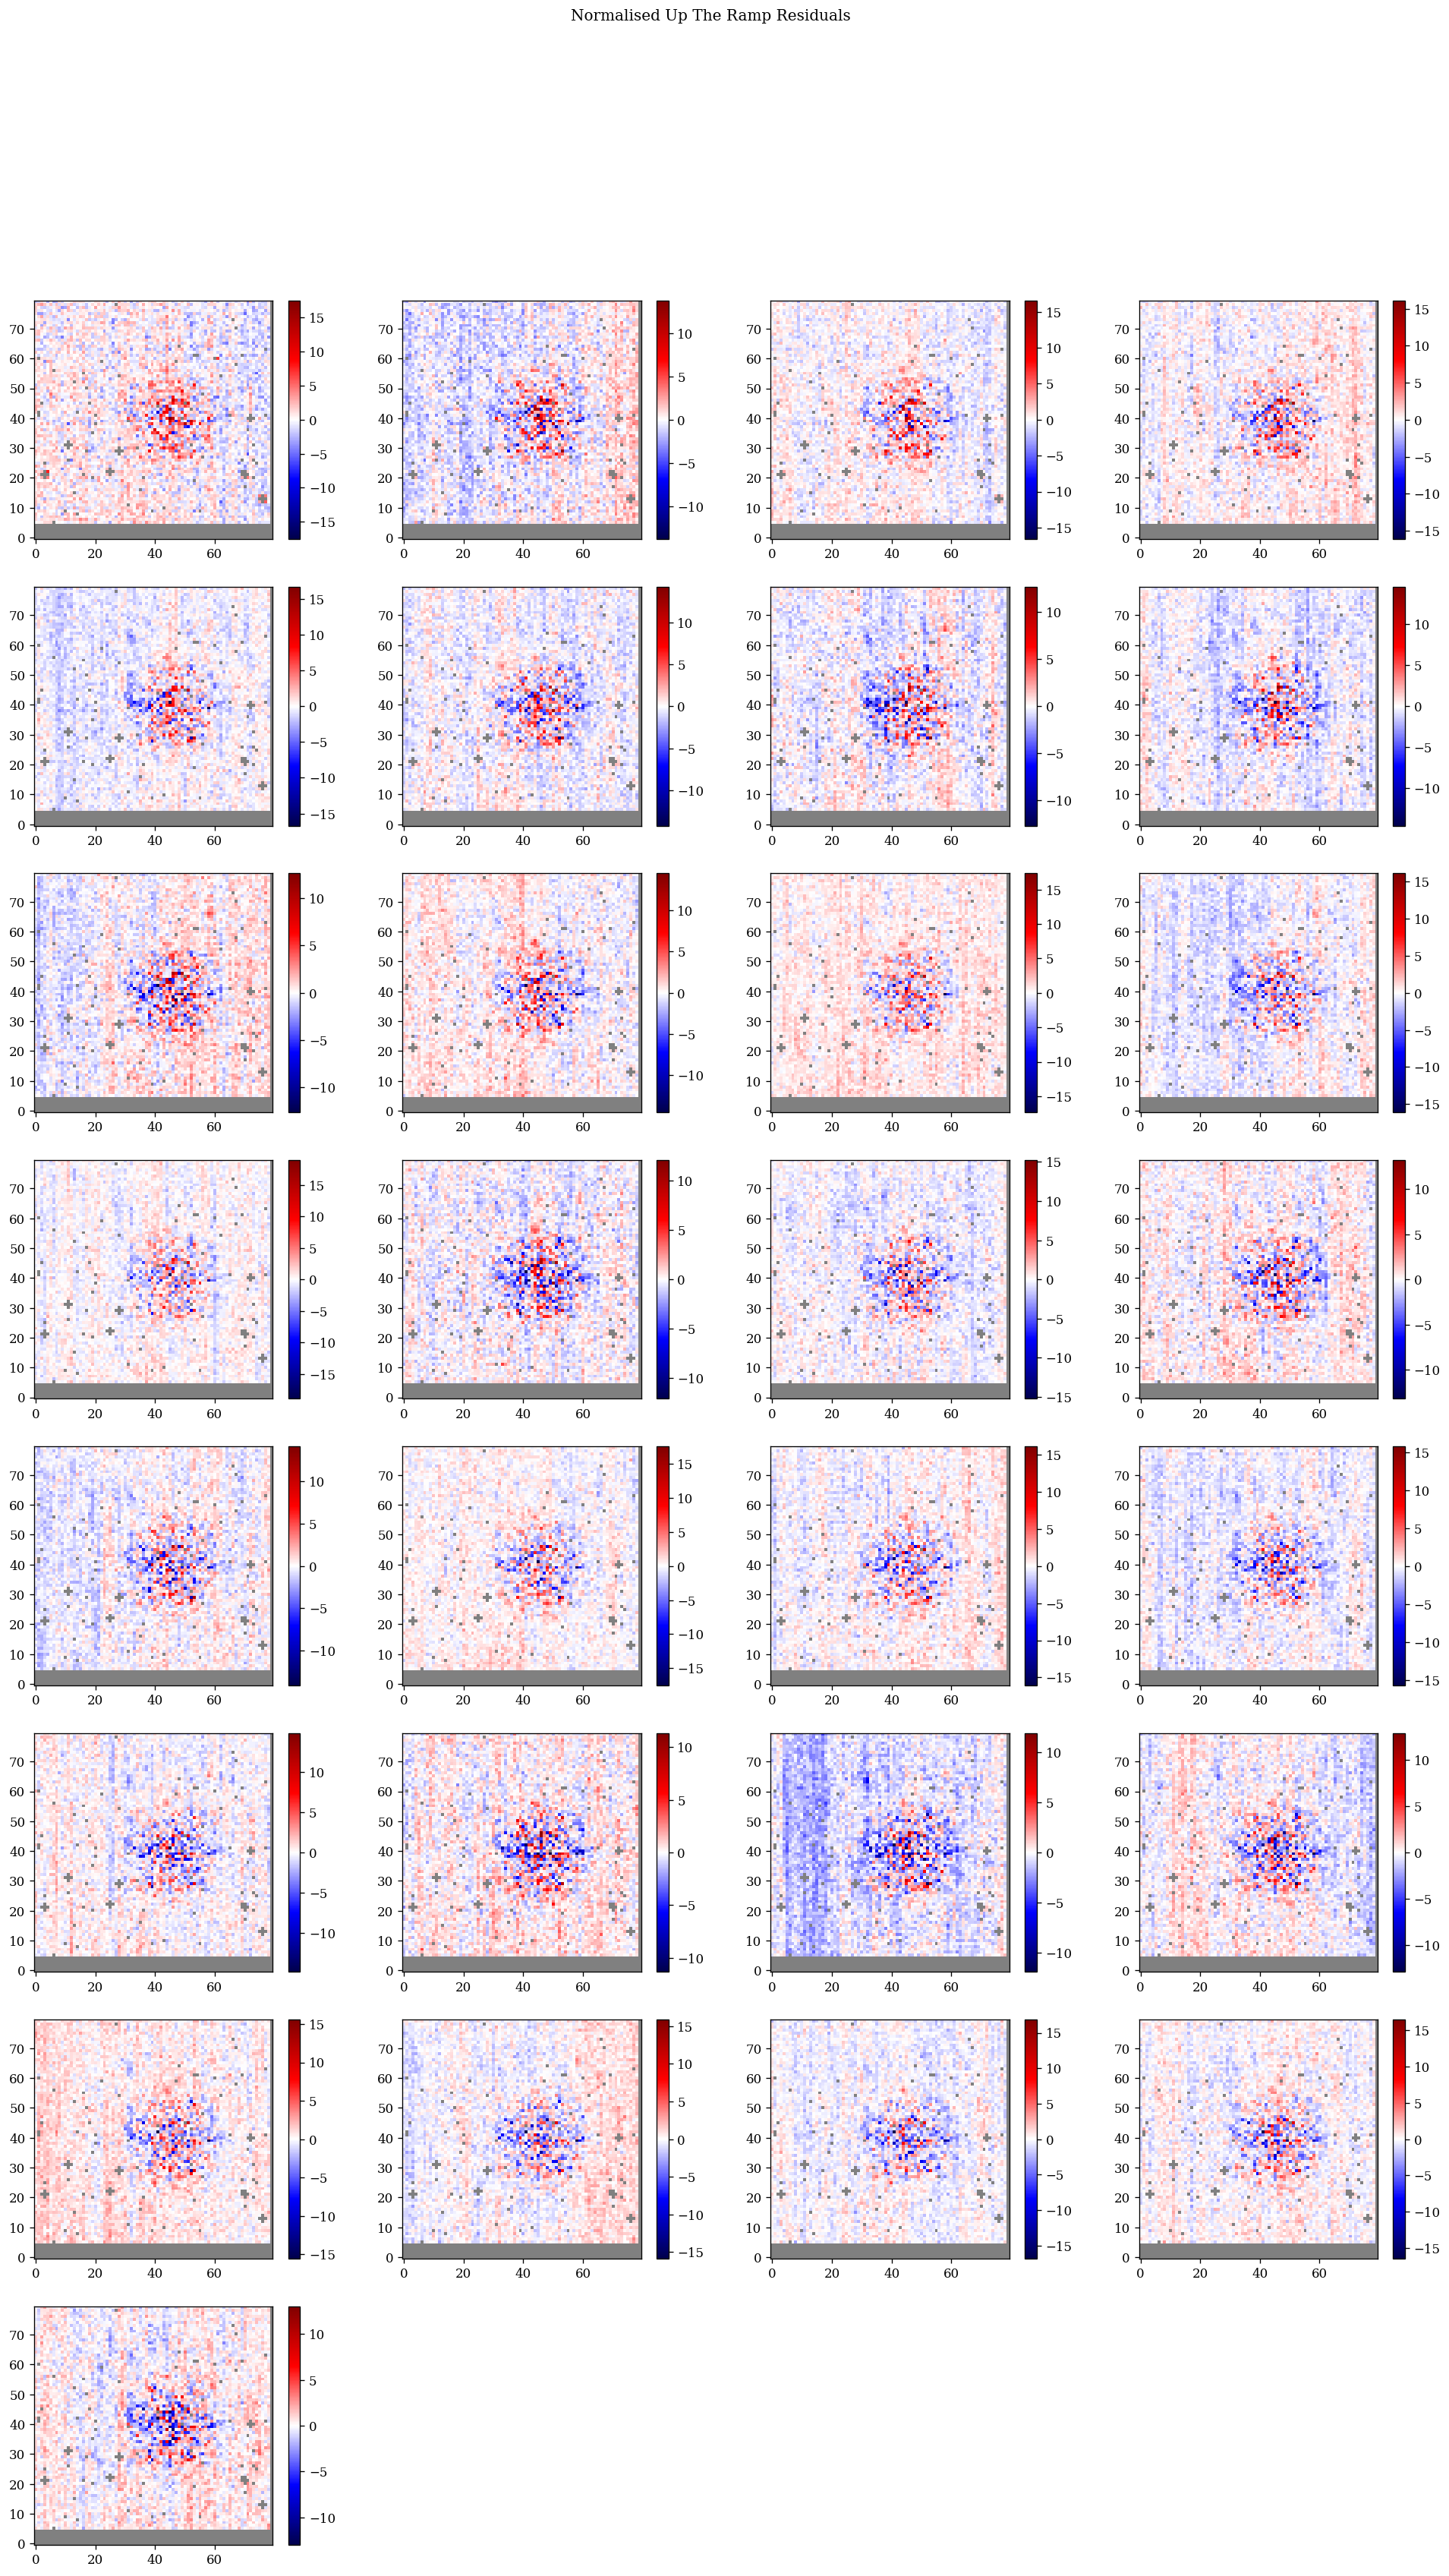

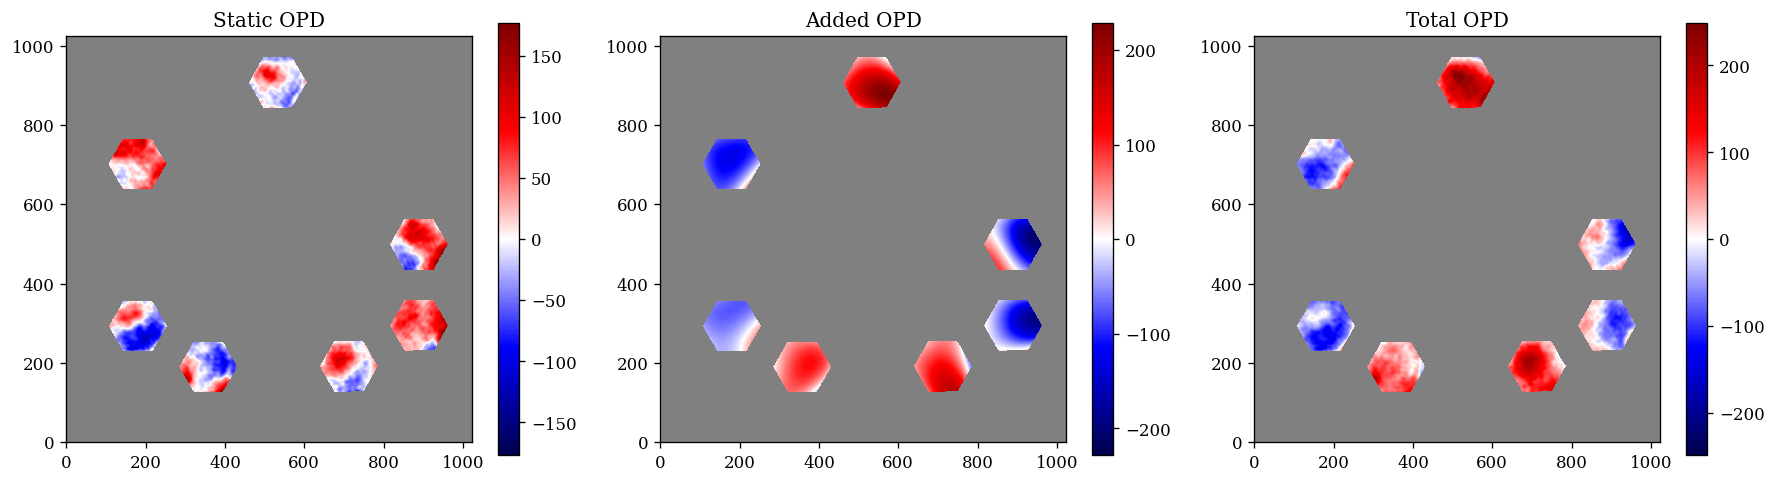

File jw04481001001_03102_00002_0001
Star HD-41094
Filter F480M
nints 760
ngroups 30



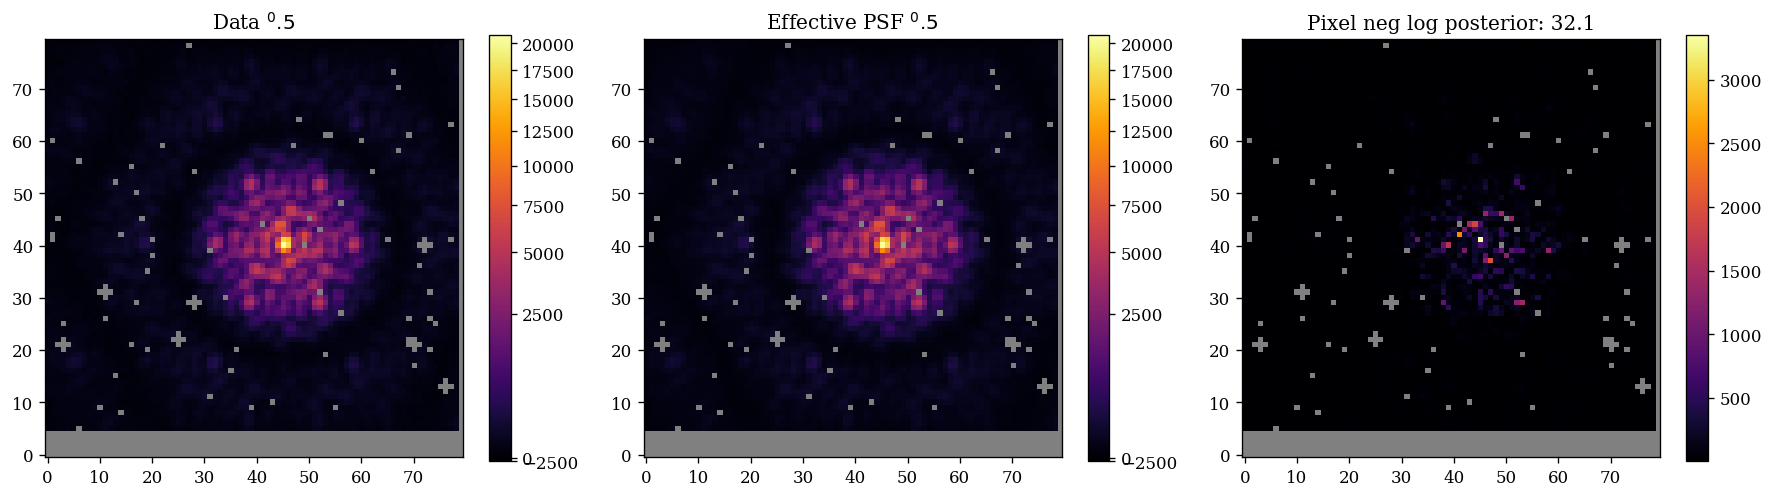

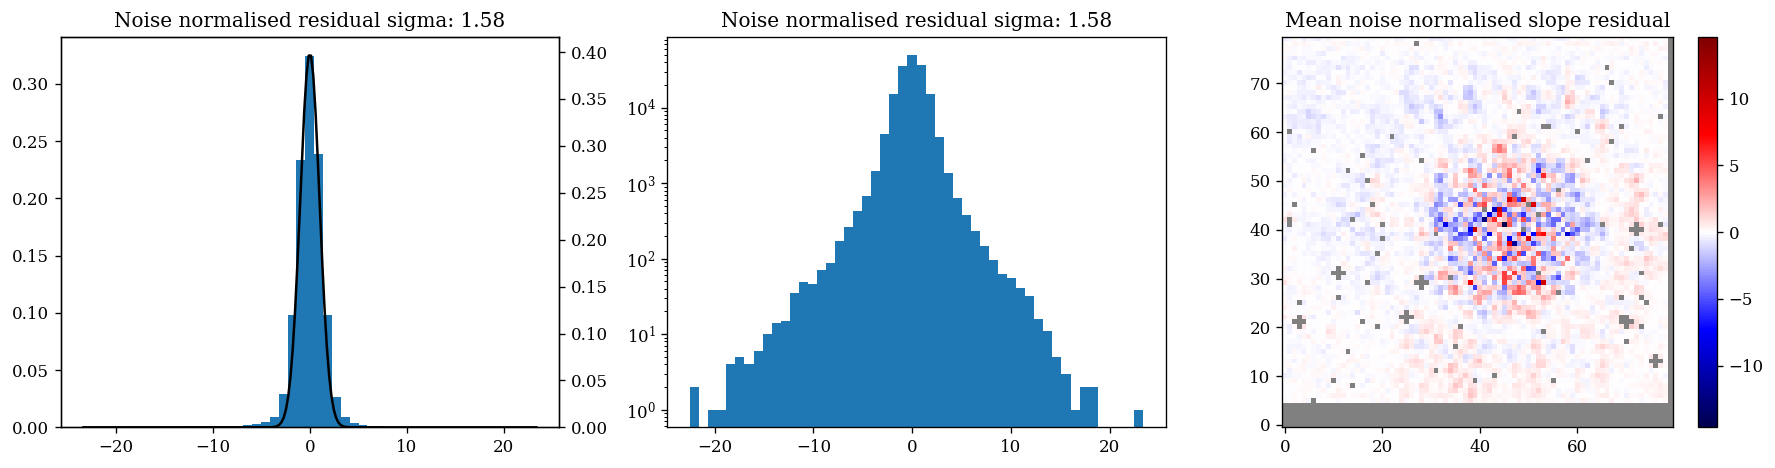

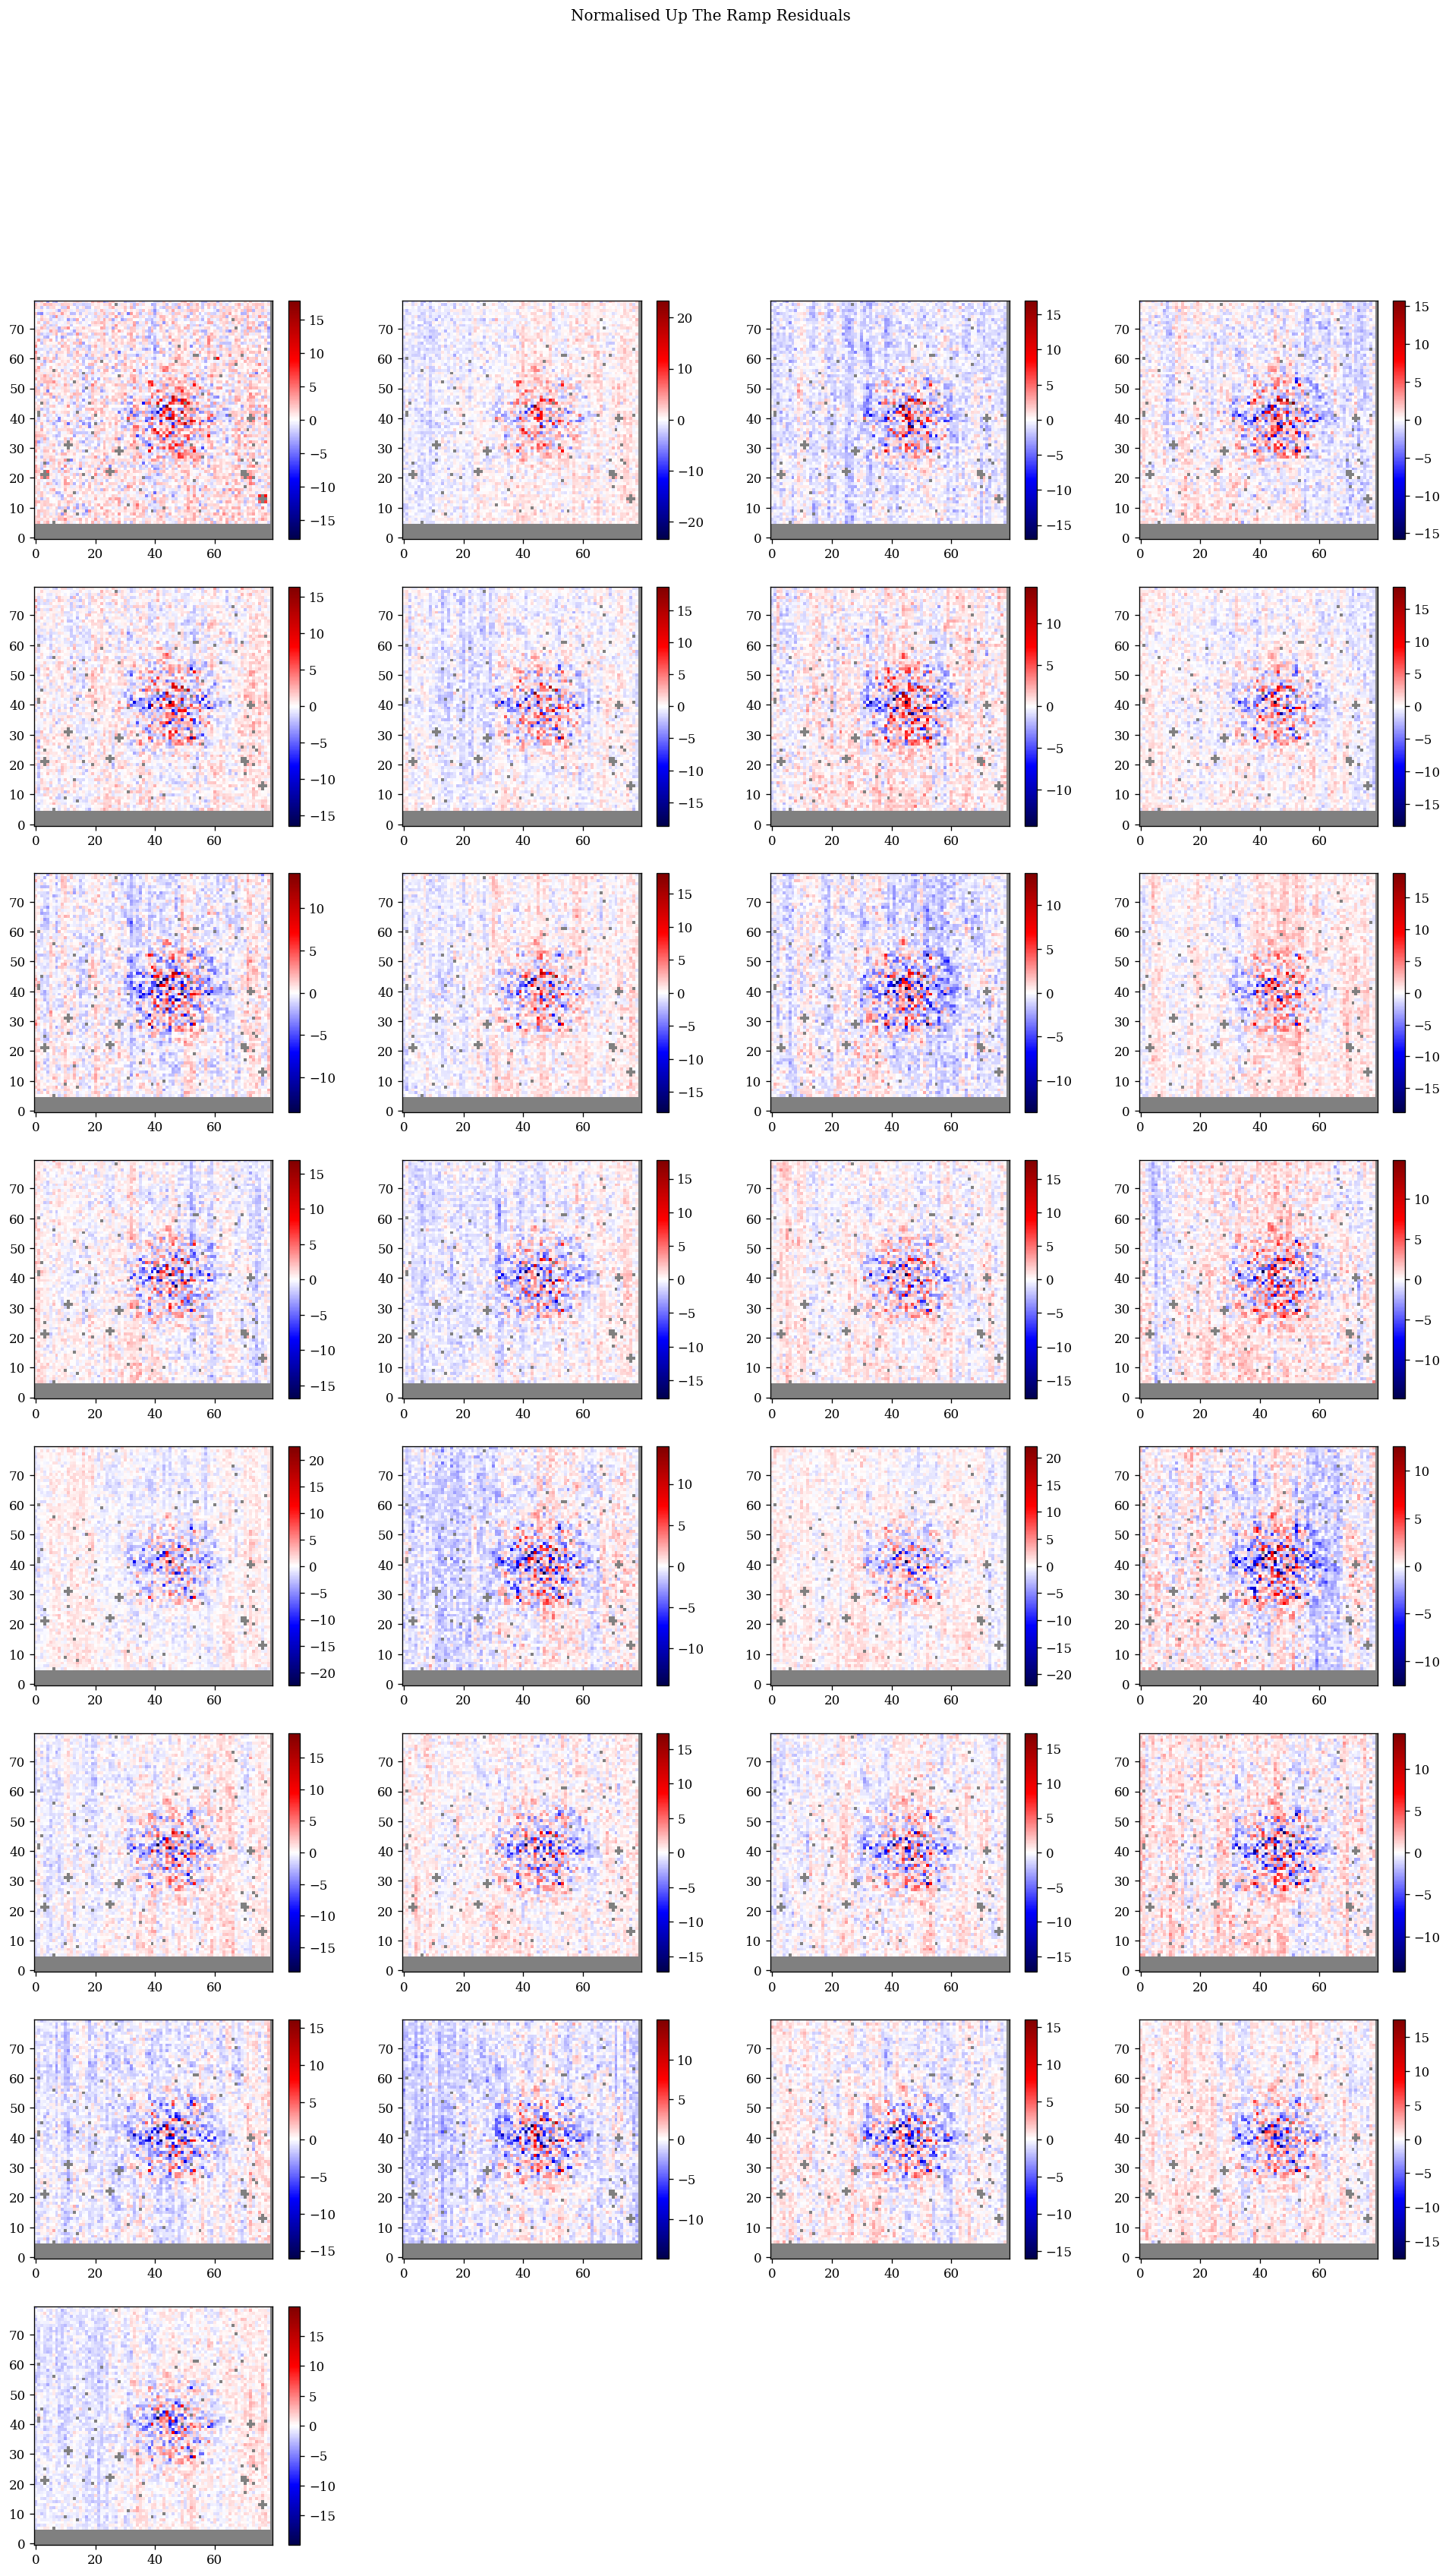

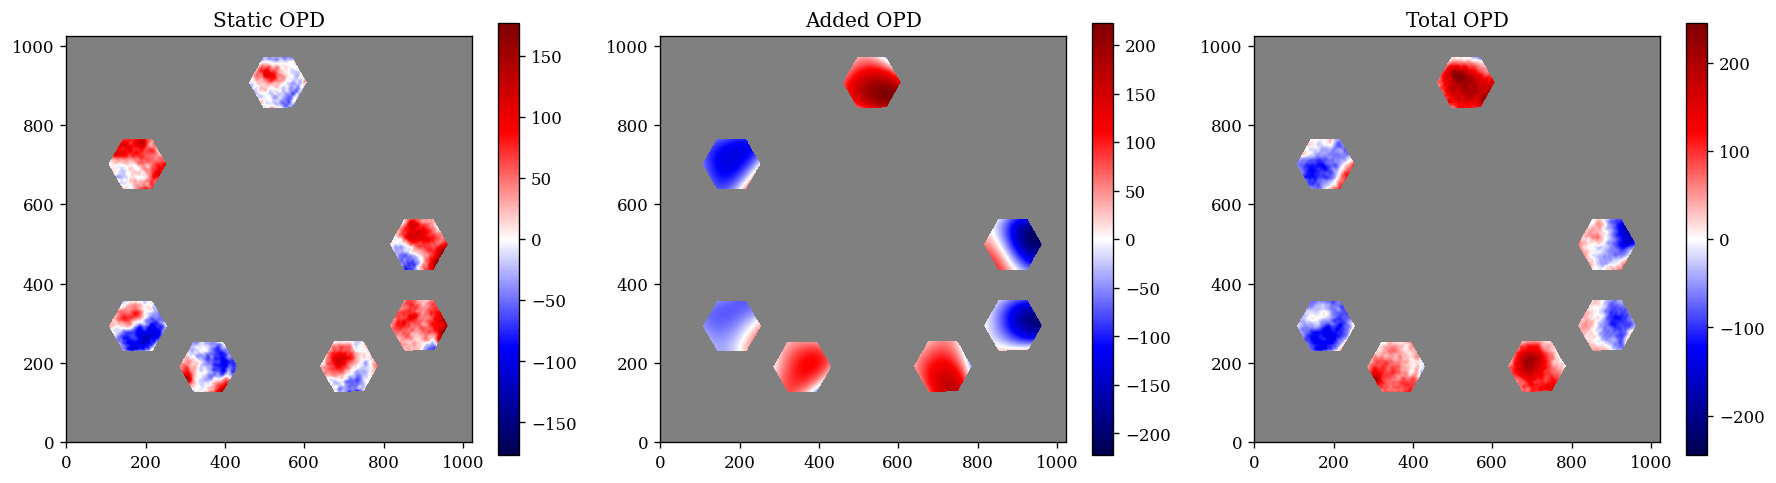

In [21]:
from amigo.plotting import summarise_fit

for exp in exposures:
    exp.print_summary()
    summarise_fit(
        exp, 
        final_model,
        residuals=True,
        histograms=True,
        # flat_field=True,
        # up_the_ramp=True,
        up_the_ramp_norm=True,
        # full_bias=True,
        aberrations=True,
    )

File jw04481001001_03104_00003_0001
Star HD-41094
Filter F380M
nints 1060
ngroups 11



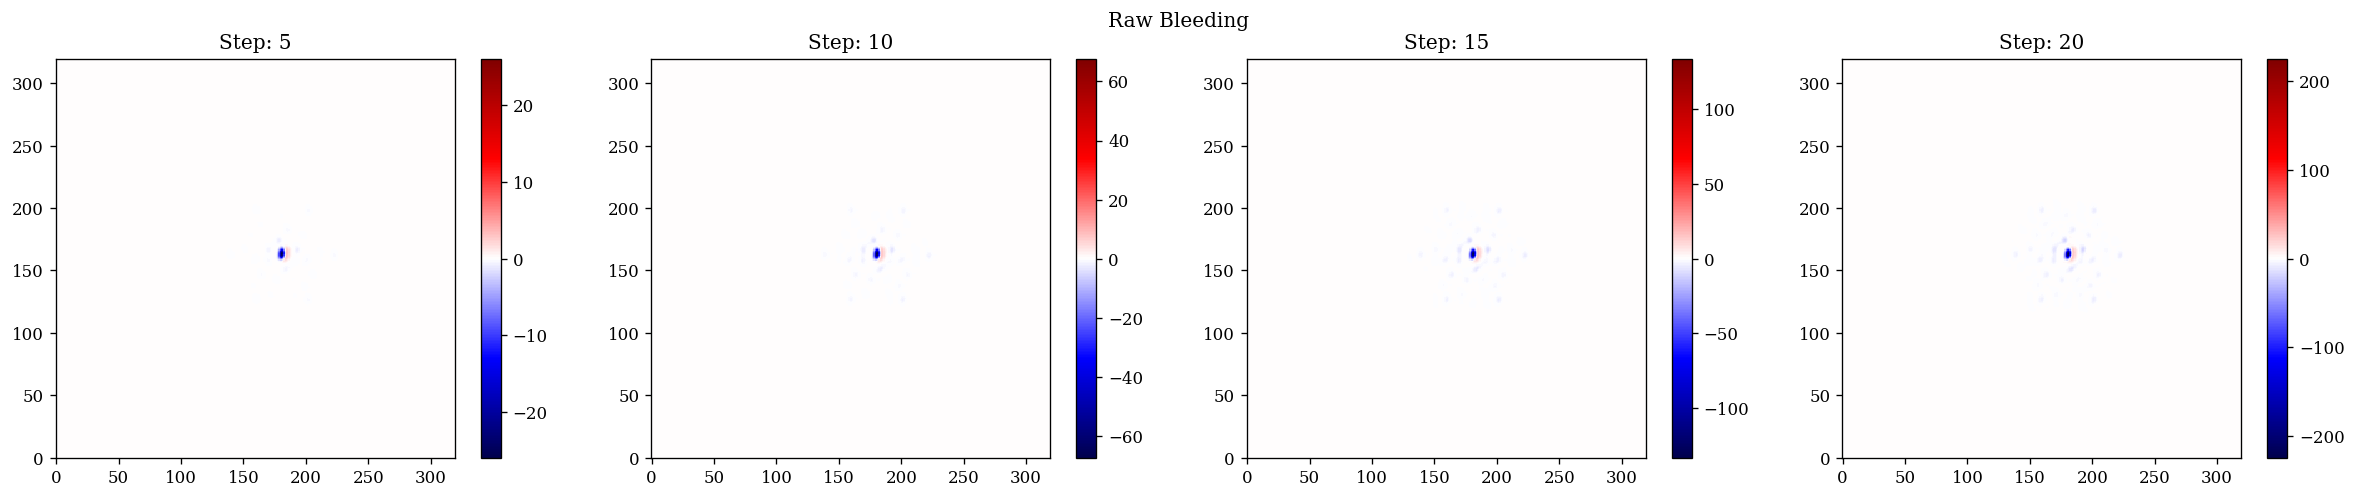

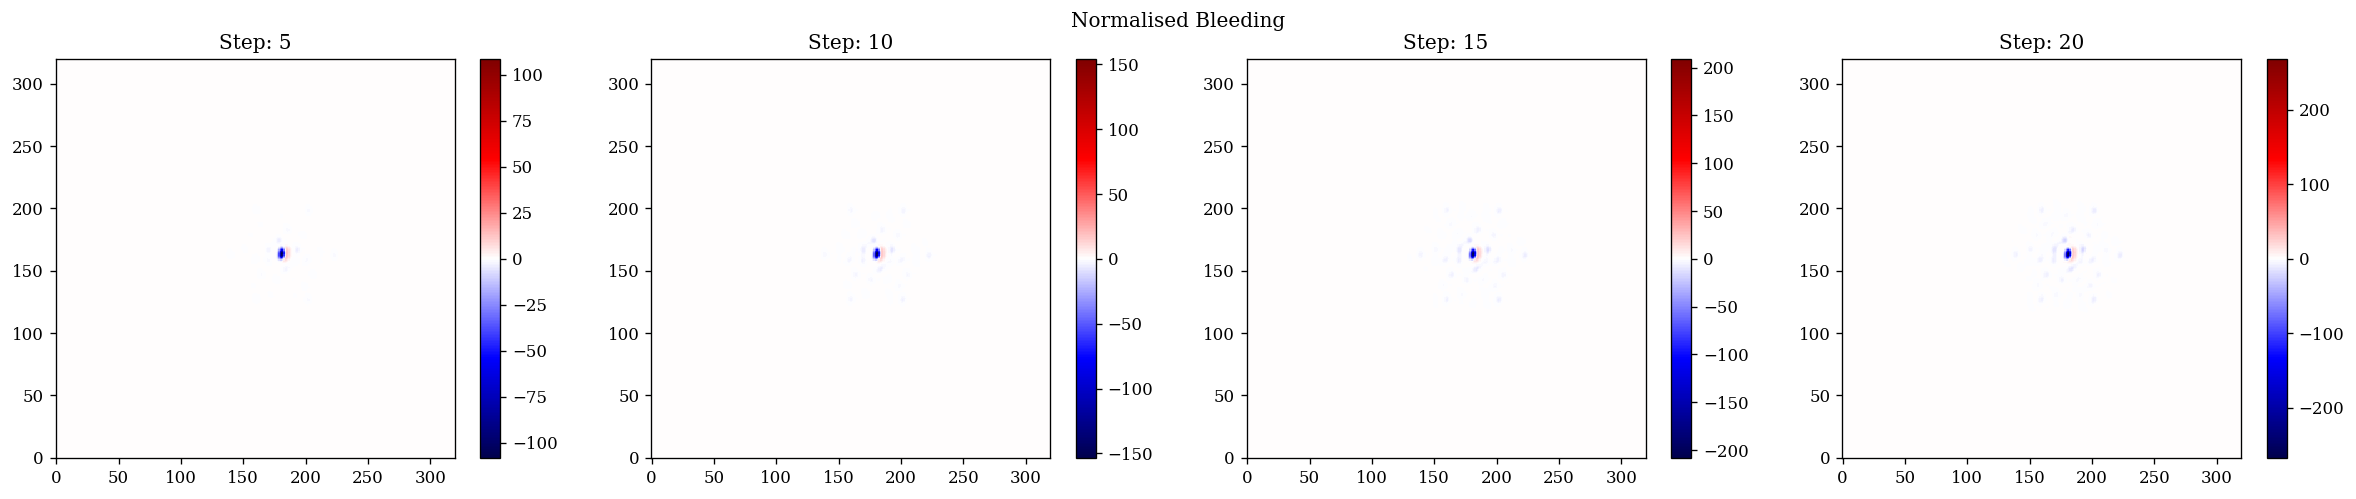

File jw04481001001_03104_00004_0001
Star HD-41094
Filter F380M
nints 1060
ngroups 11



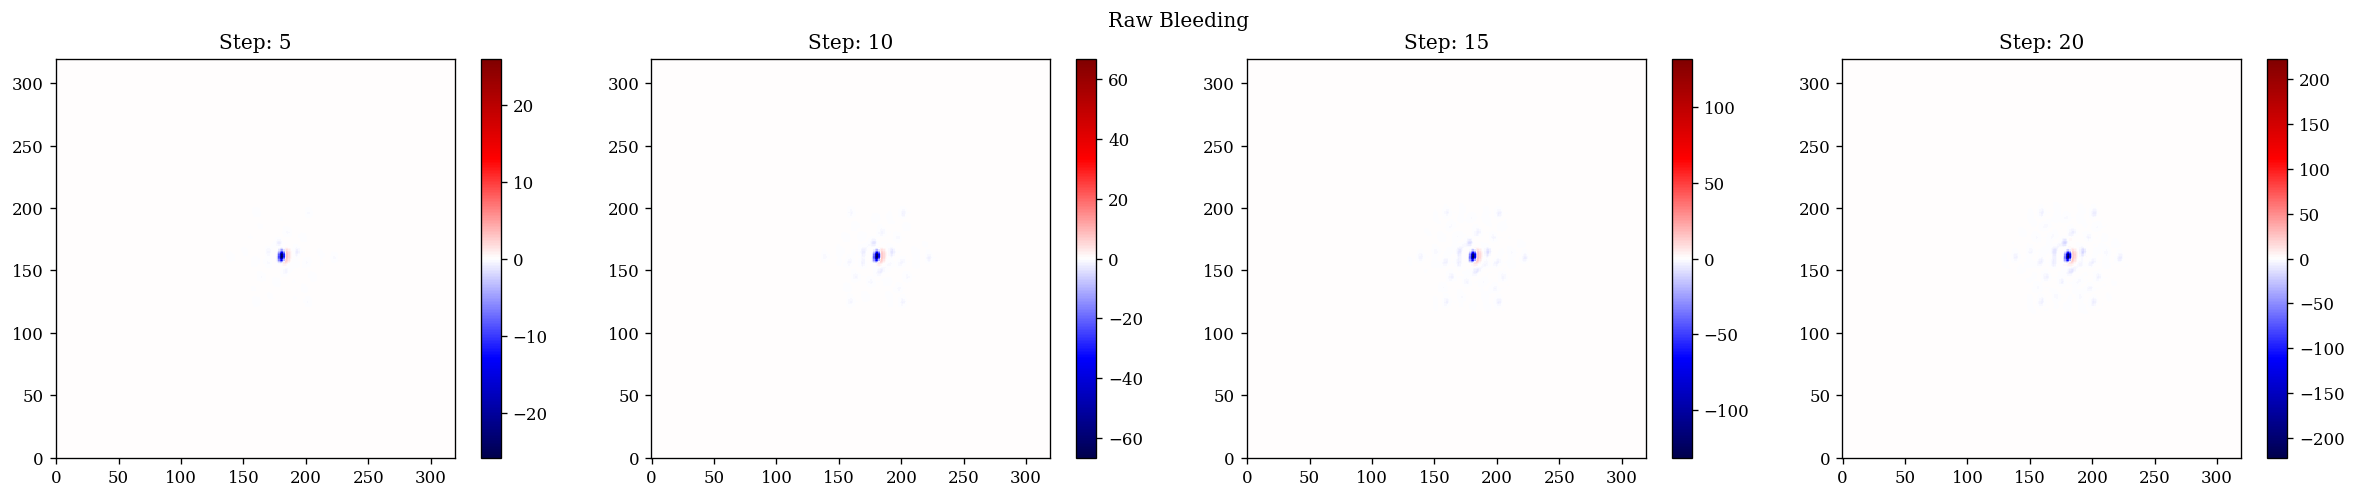

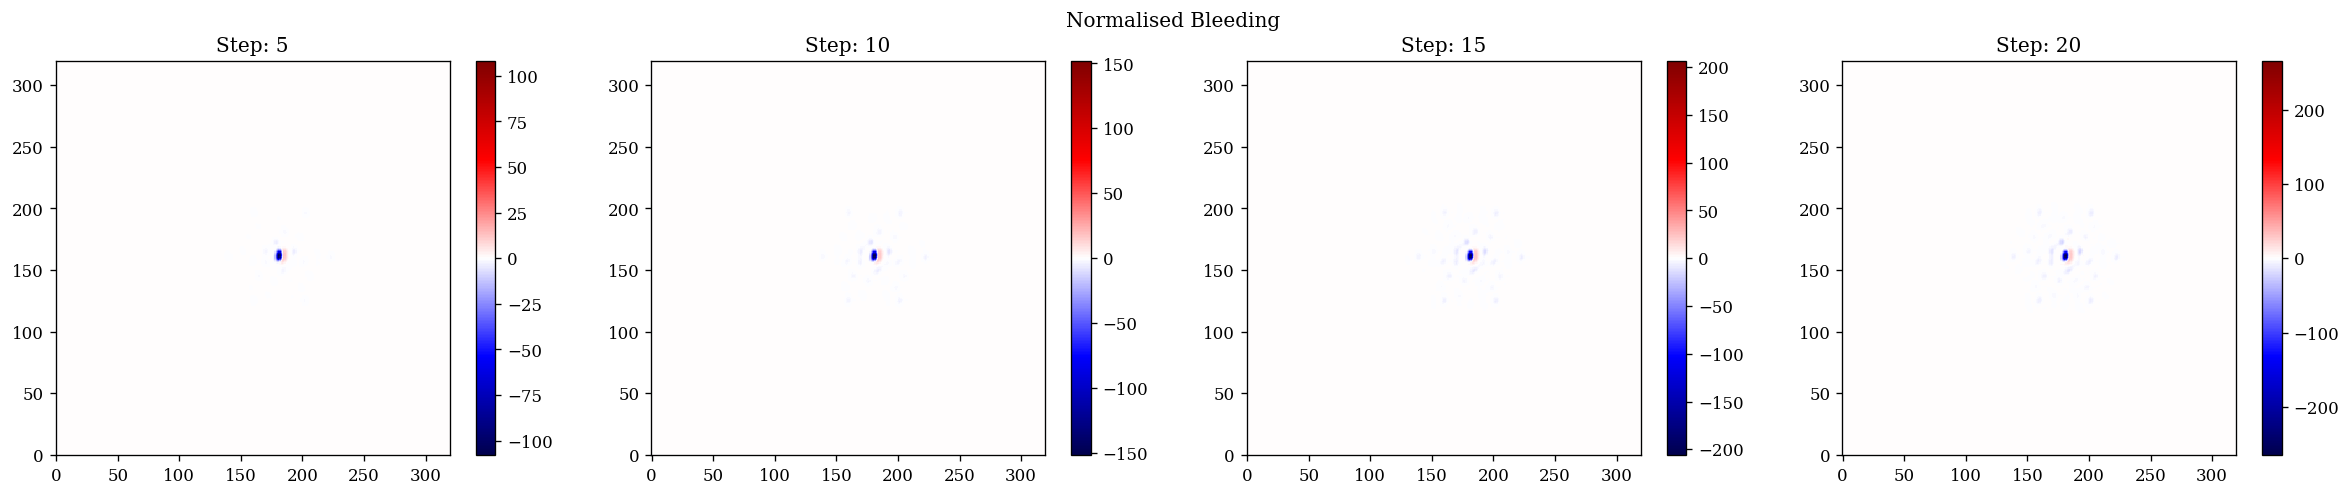

File jw04481001001_03106_00001_0001
Star HD-41094
Filter F430M
nints 905
ngroups 20



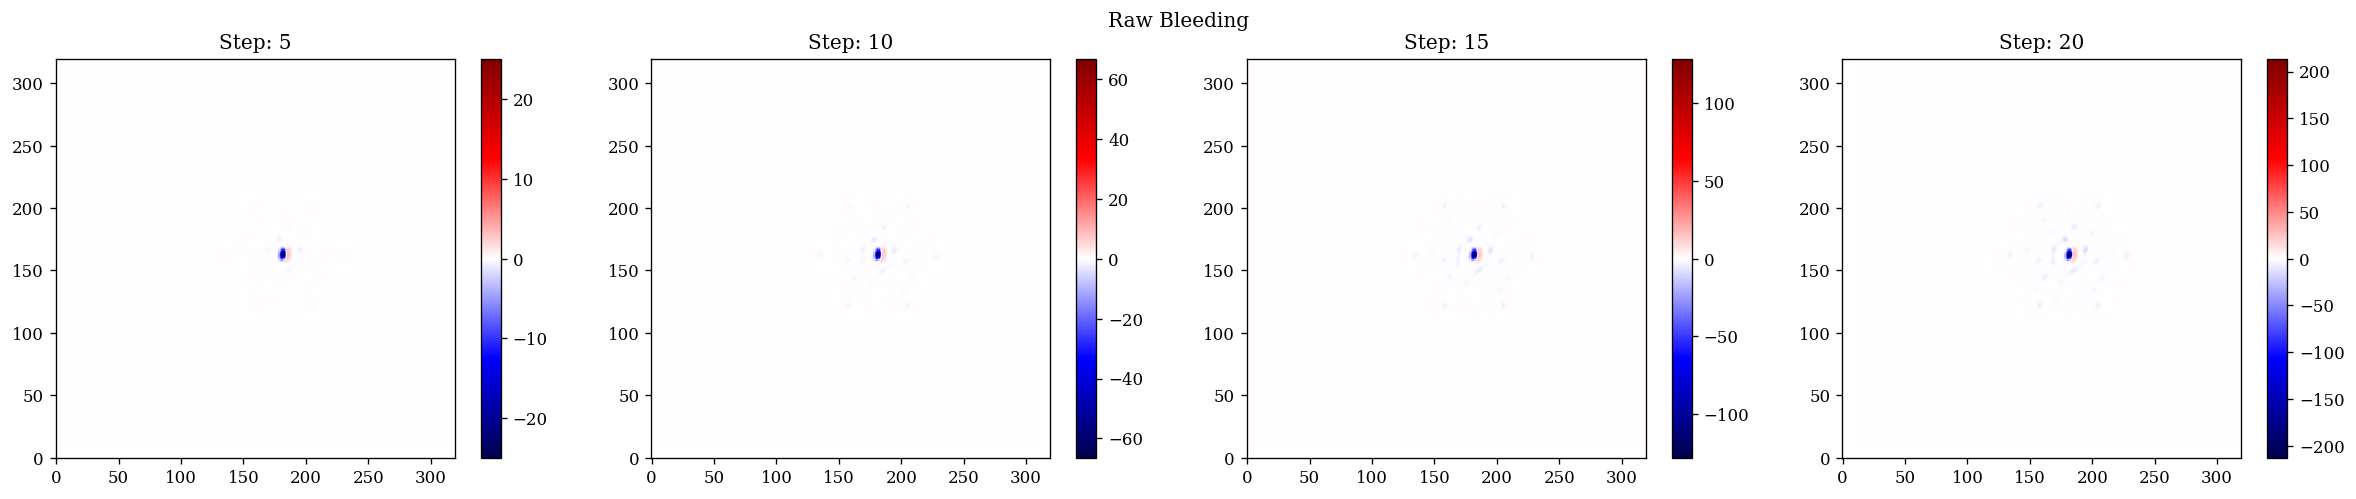

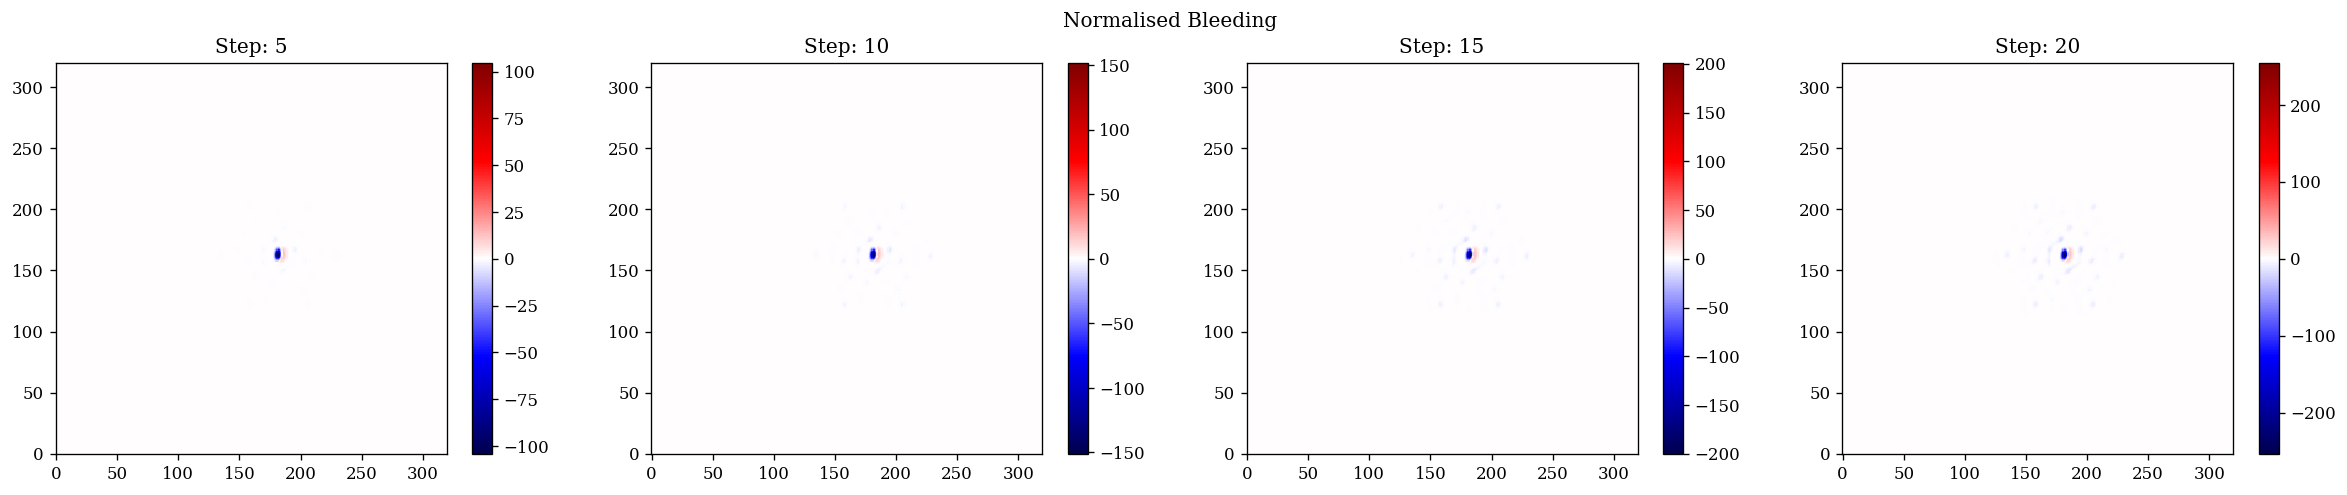

File jw04481001001_03106_00002_0001
Star HD-41094
Filter F430M
nints 905
ngroups 20



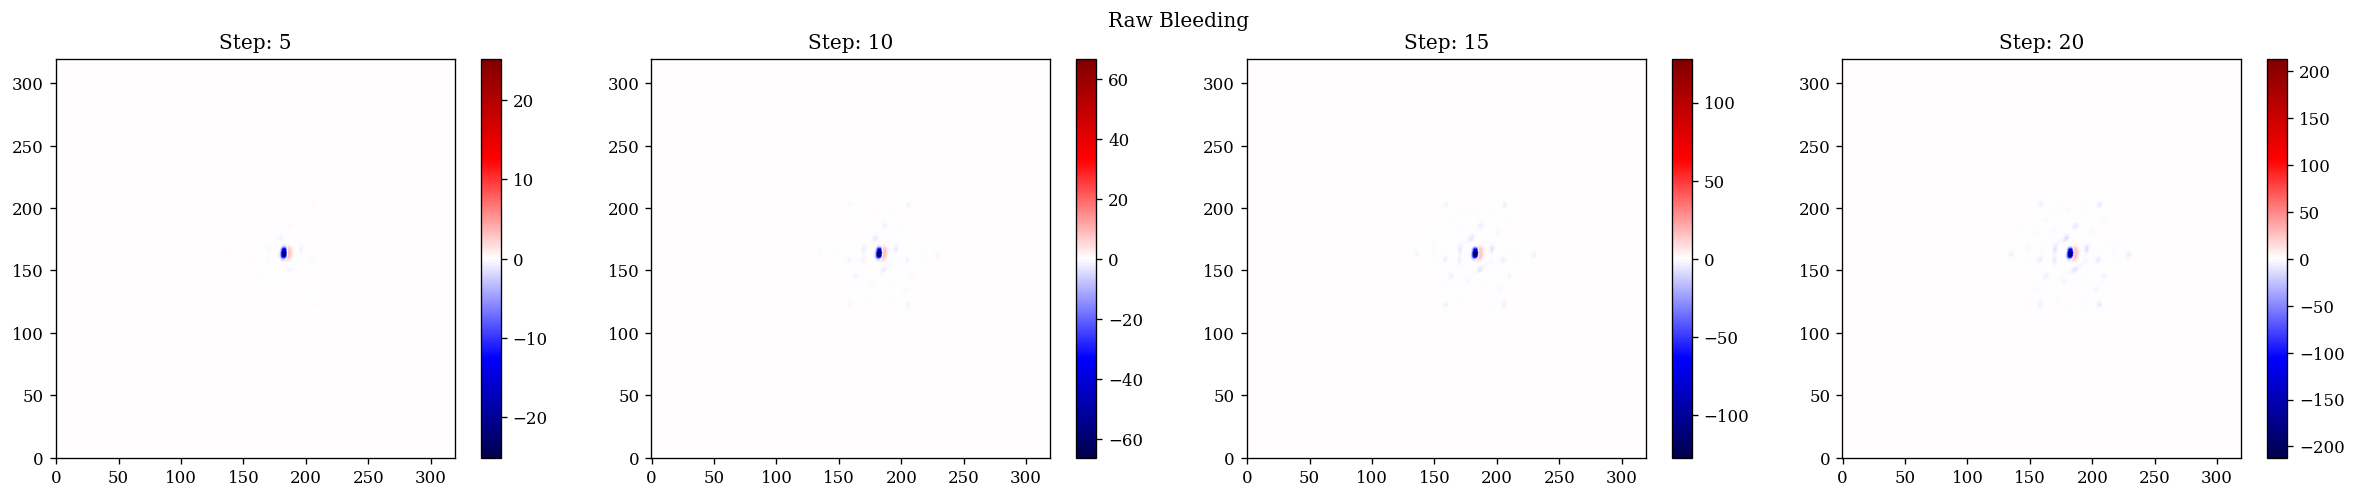

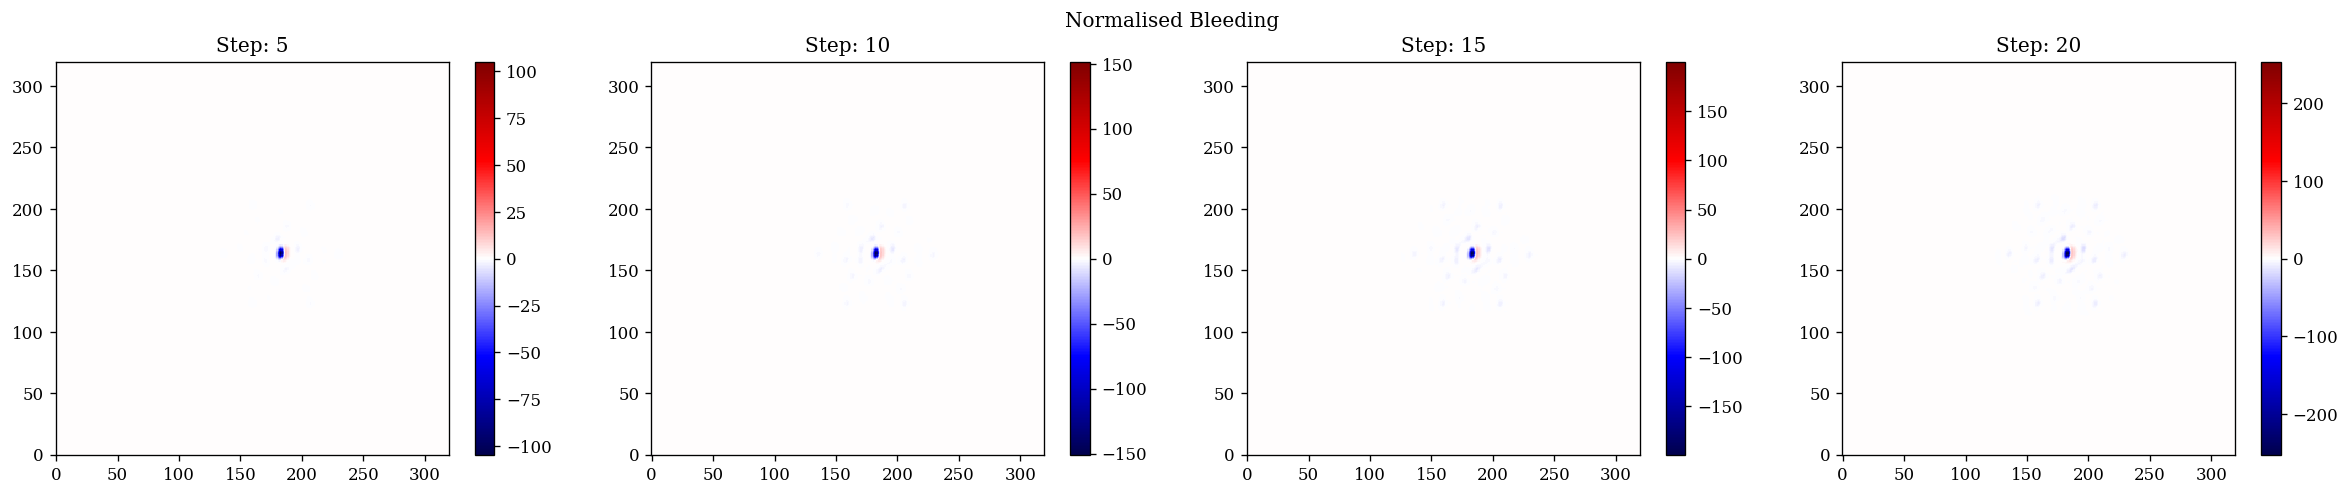

File jw04481001001_03102_00005_0001
Star HD-41094
Filter F480M
nints 760
ngroups 30



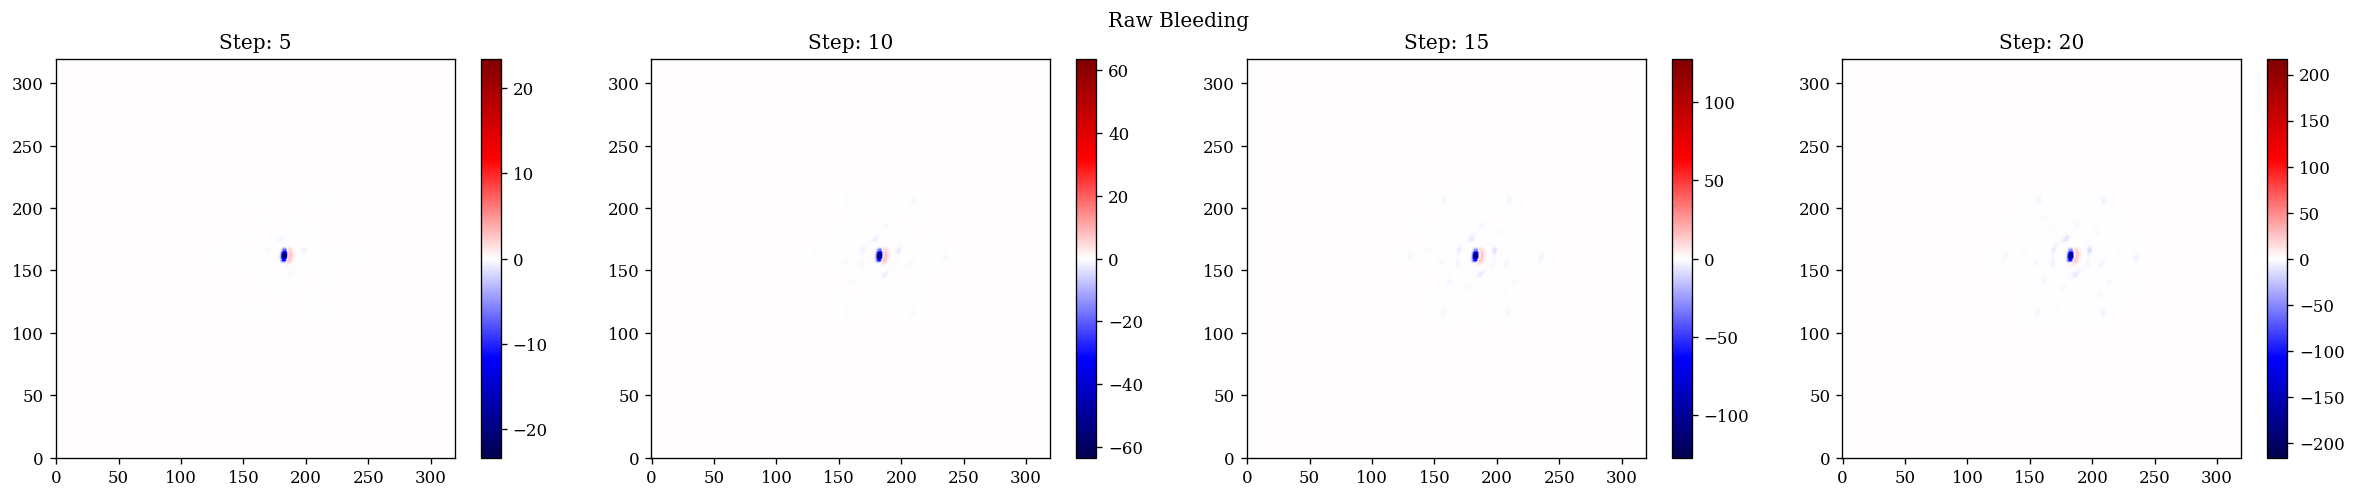

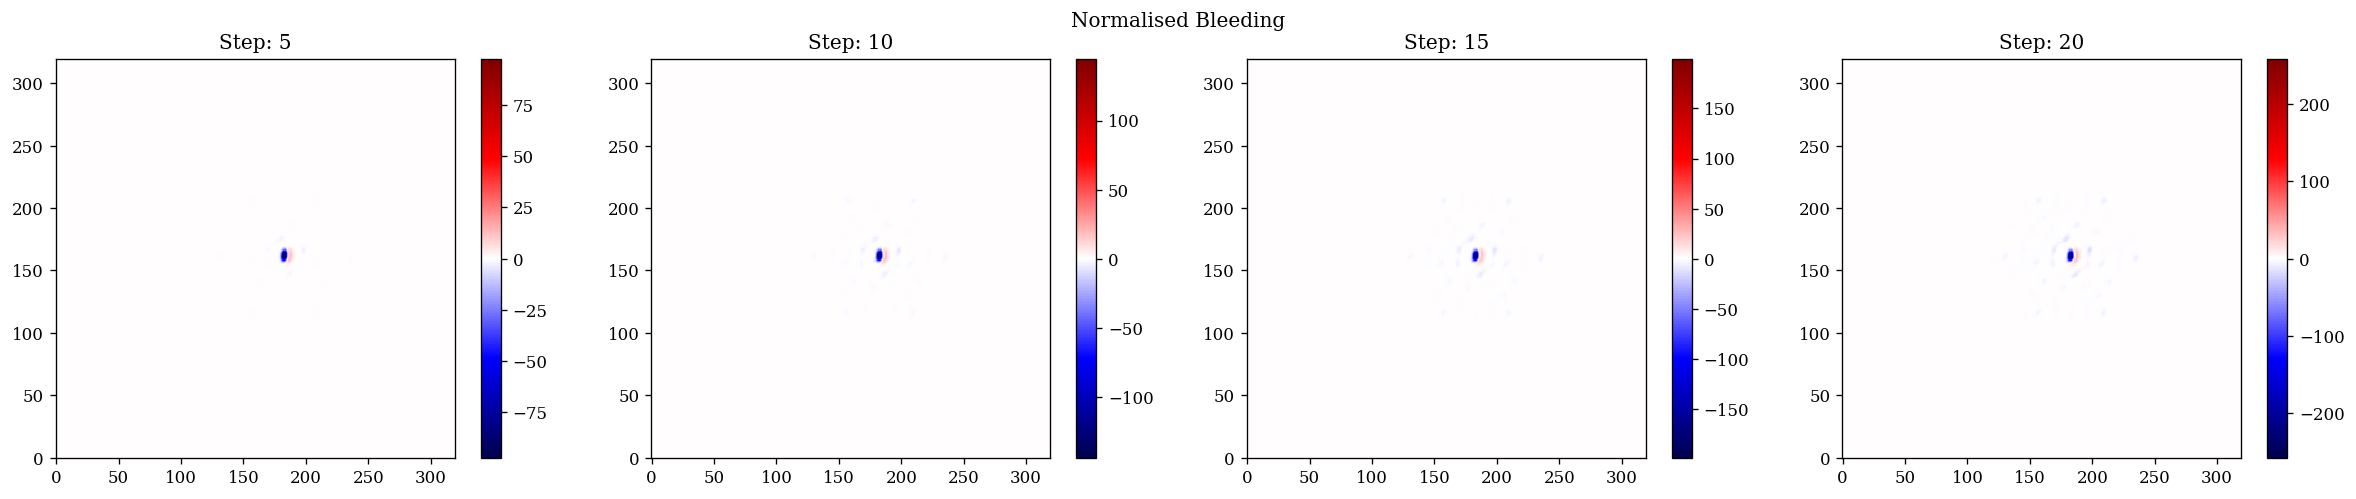

File jw04481001001_03102_00002_0001
Star HD-41094
Filter F480M
nints 760
ngroups 30



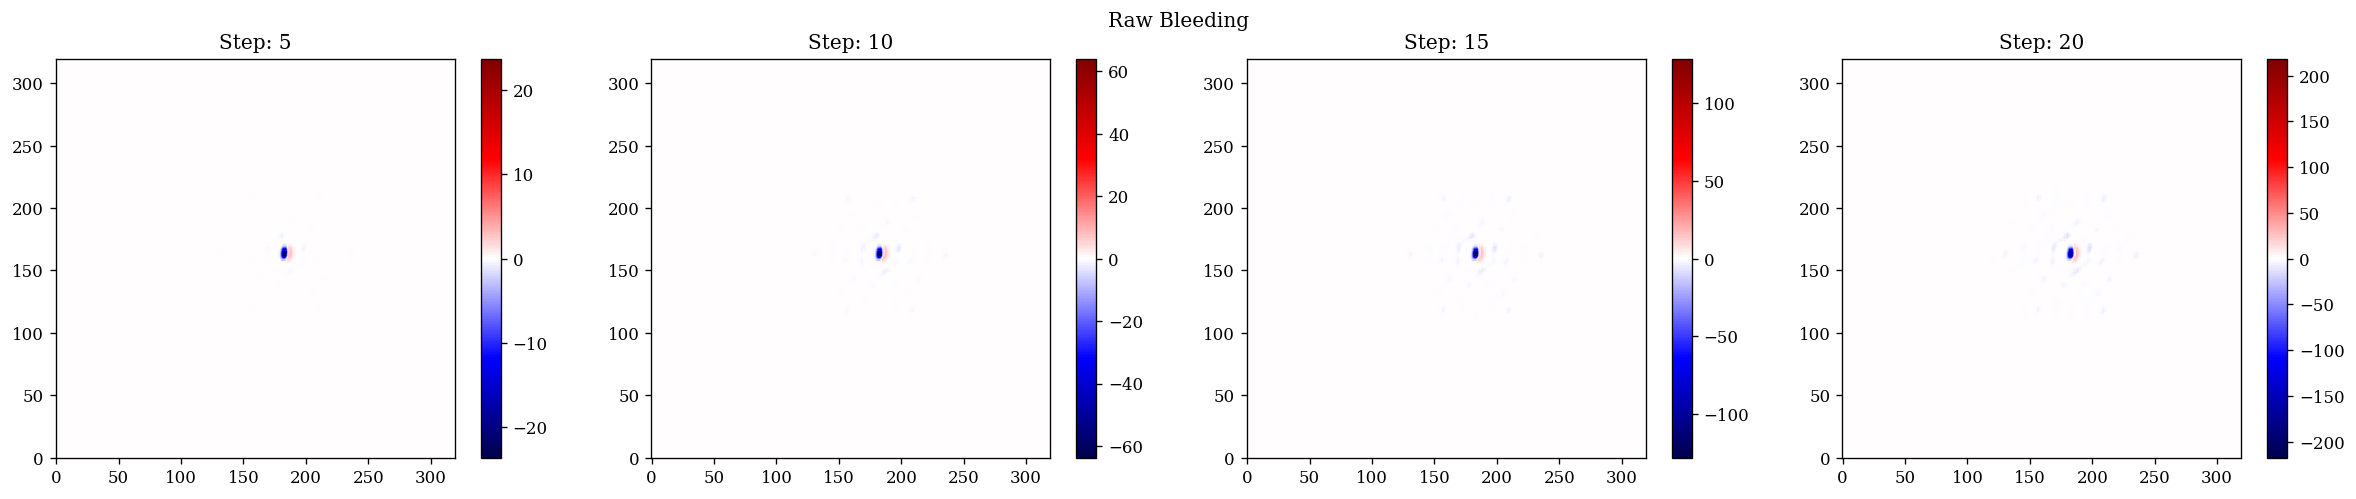

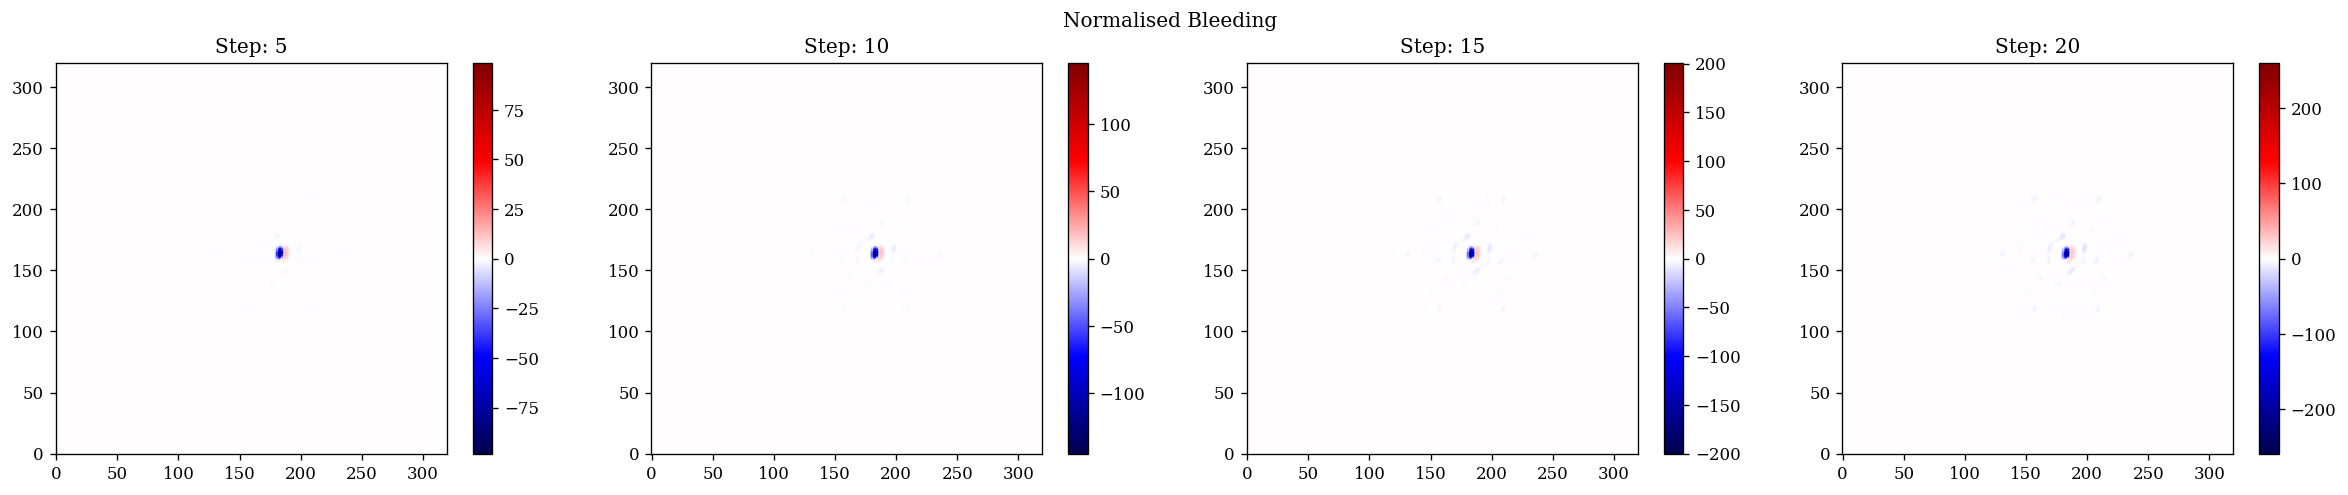

In [22]:
for exp in exposures:
    exp.print_summary()
    psf, flux, oversample = final_model.model(exp, to_BFE=True)
    ramp, bleed_ramp = final_model.ramp.bleeding_model(psf.data, exp.filter)

    ramp_vals = (np.arange(len(bleed_ramp)) + 1) / len(bleed_ramp)
    inv_ramp = 1 / ramp_vals

    inds = [5, 10, 15, 20]
    plt.figure(figsize=(20, 4))
    plt.suptitle("Raw Bleeding")
    for i in range(4):
        idx = inds[i]
        plt.subplot(1, 4, i+1)
        bleed = bleed_ramp[idx]
        v = np.nanmax(np.abs(bleed))
        plt.title(f"Step: {idx}")
        plt.imshow(bleed, cmap=seismic, vmin=-v, vmax=v)
        plt.colorbar()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 4))
    plt.suptitle("Normalised Bleeding")
    for i in range(4):
        idx = inds[i]
        plt.subplot(1, 4, i + 1)
        bleed = bleed_ramp[idx] * inv_ramp[idx]
        v = np.nanmax(np.abs(bleed))
        plt.title(f"Step: {idx}")
        plt.imshow(bleed, cmap=seismic, vmin=-v, vmax=v)
        plt.colorbar()
    plt.tight_layout()
    plt.show()

File jw04481001001_03104_00003_0001
Star HD-41094
Filter F380M
nints 1060
ngroups 11



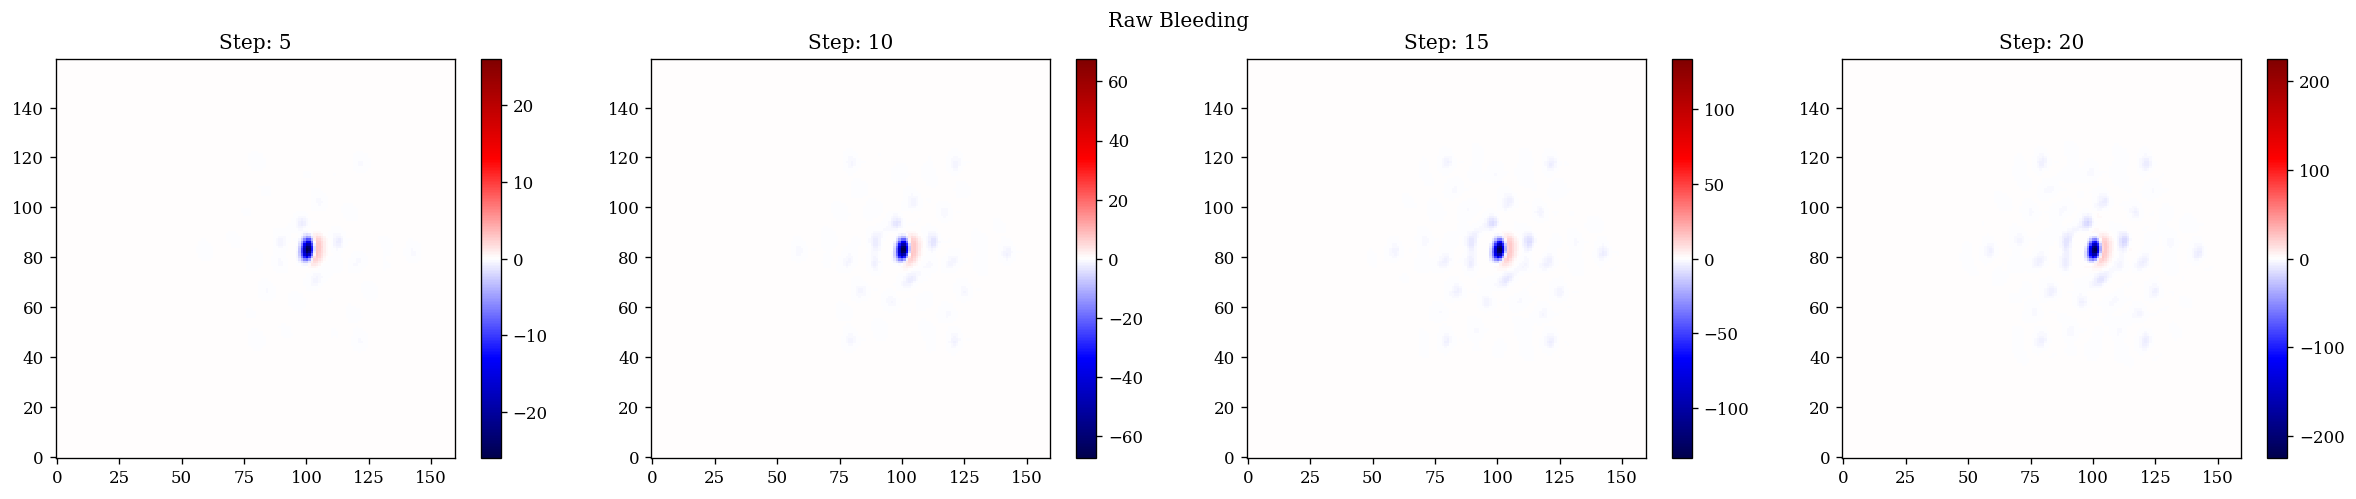

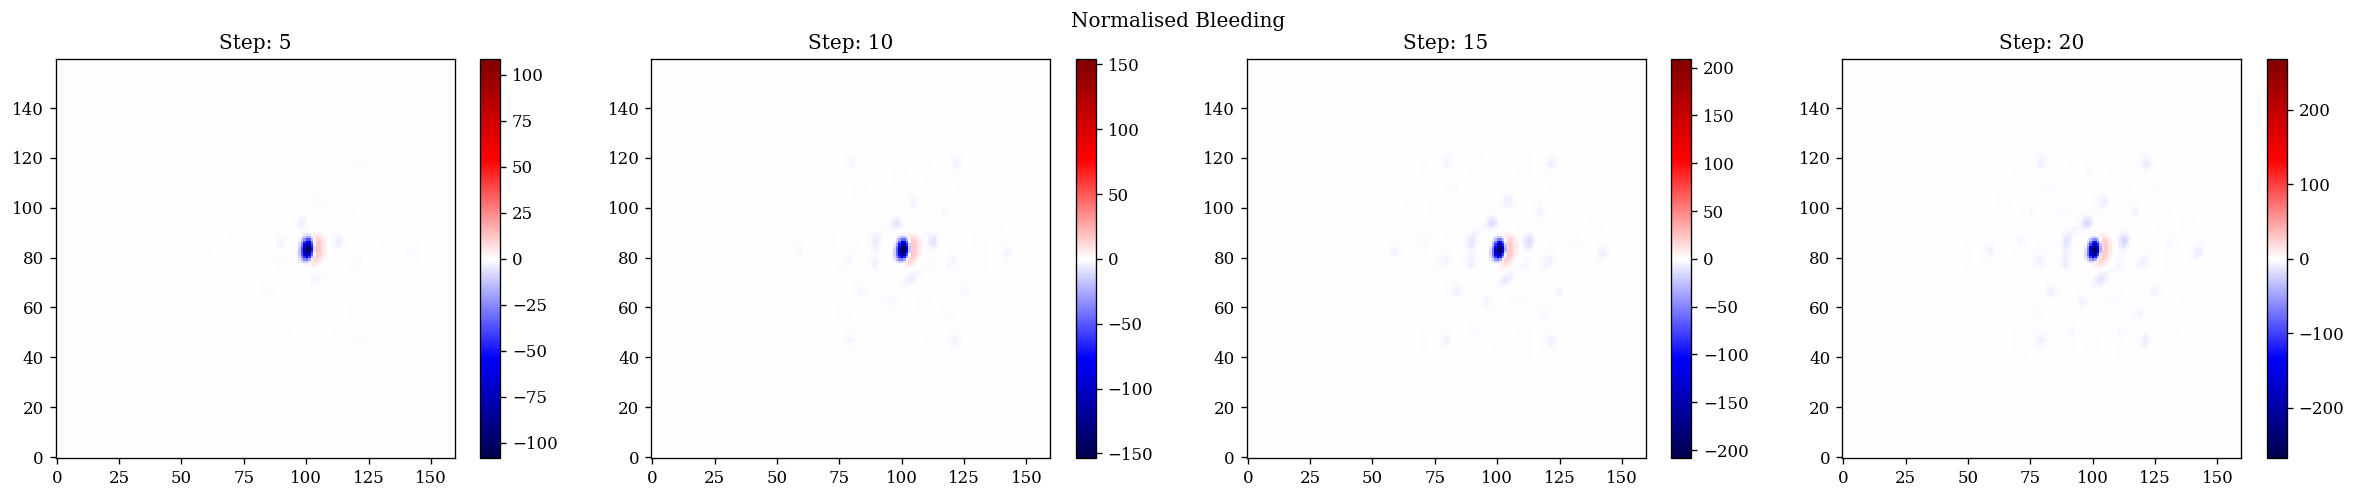

File jw04481001001_03104_00004_0001
Star HD-41094
Filter F380M
nints 1060
ngroups 11



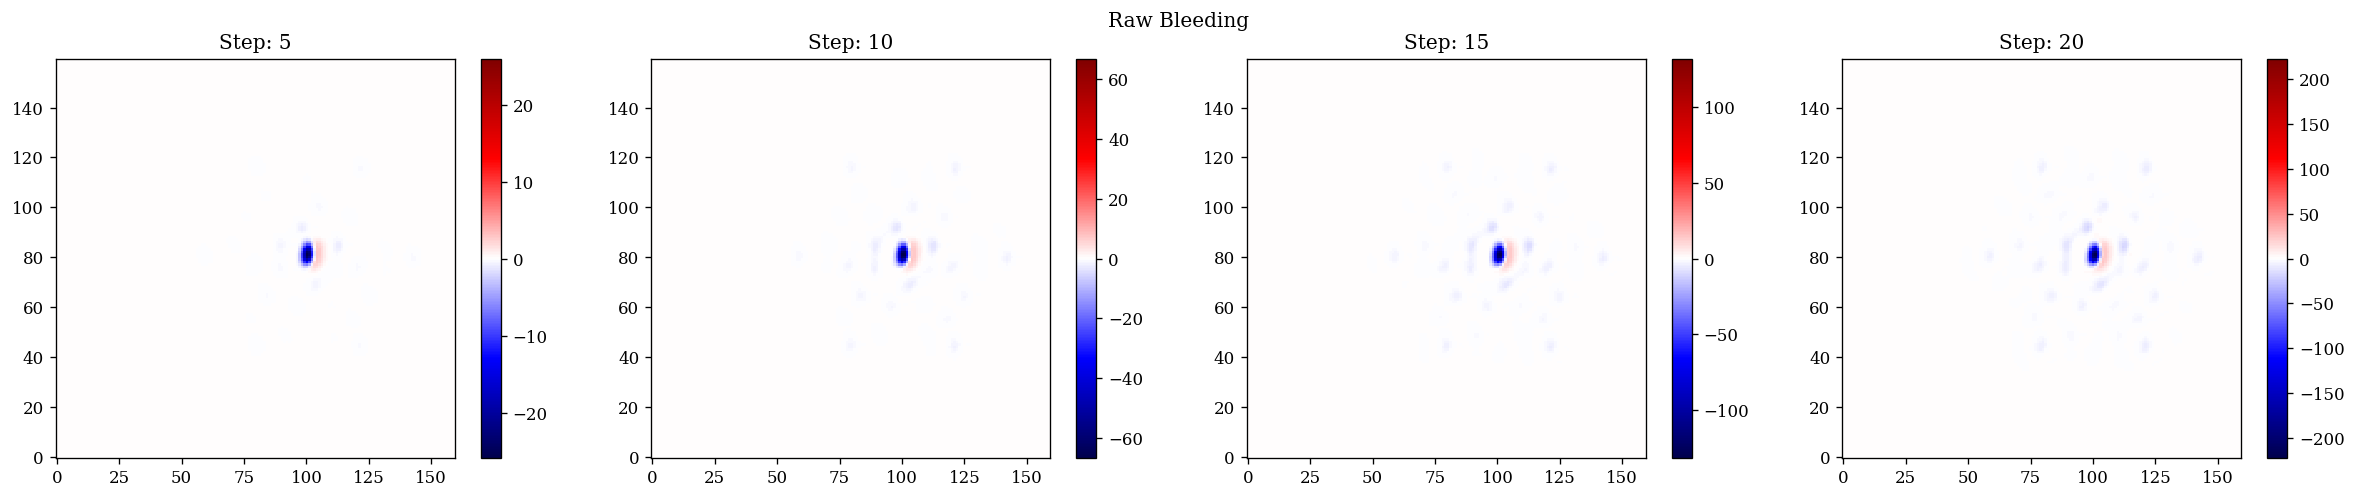

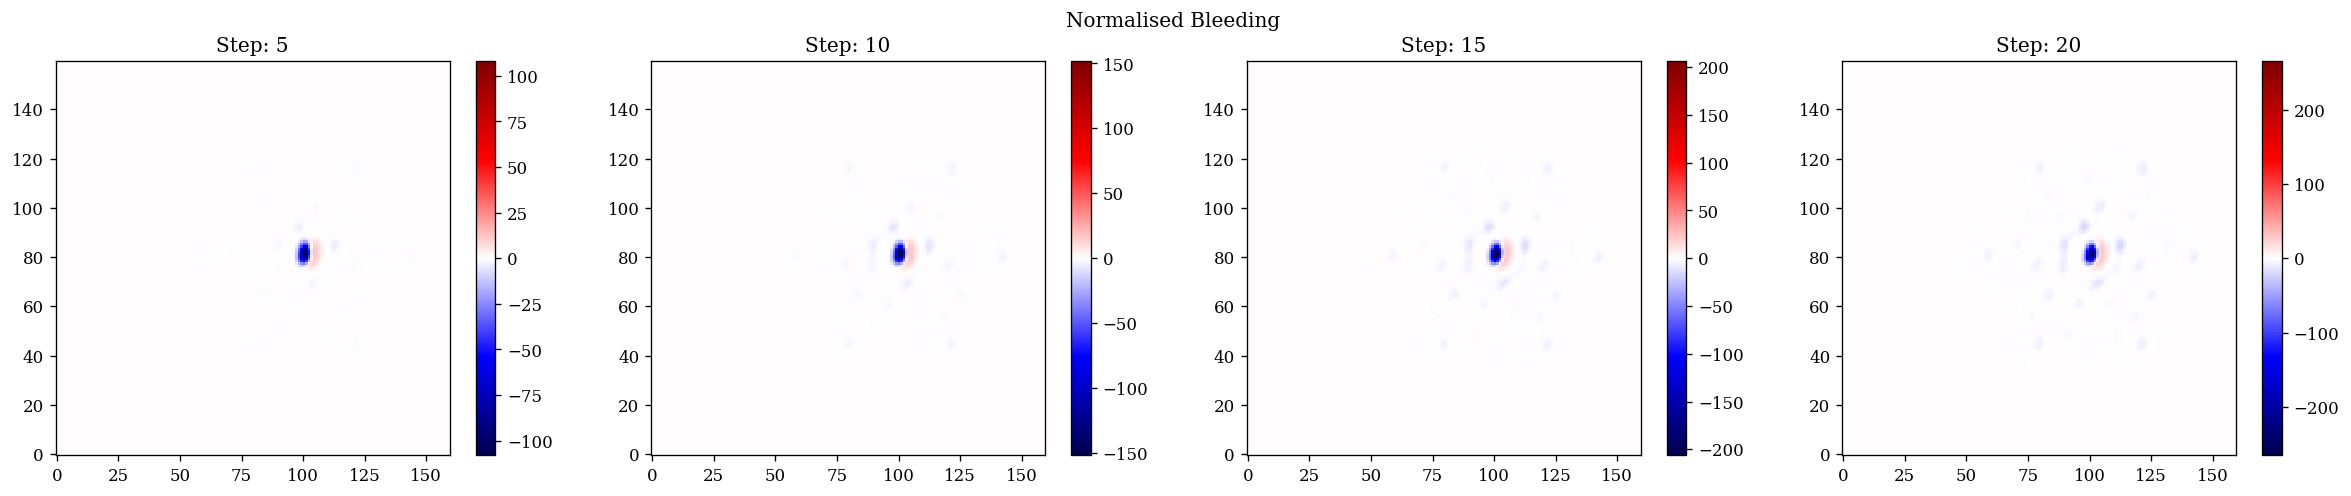

File jw04481001001_03106_00001_0001
Star HD-41094
Filter F430M
nints 905
ngroups 20



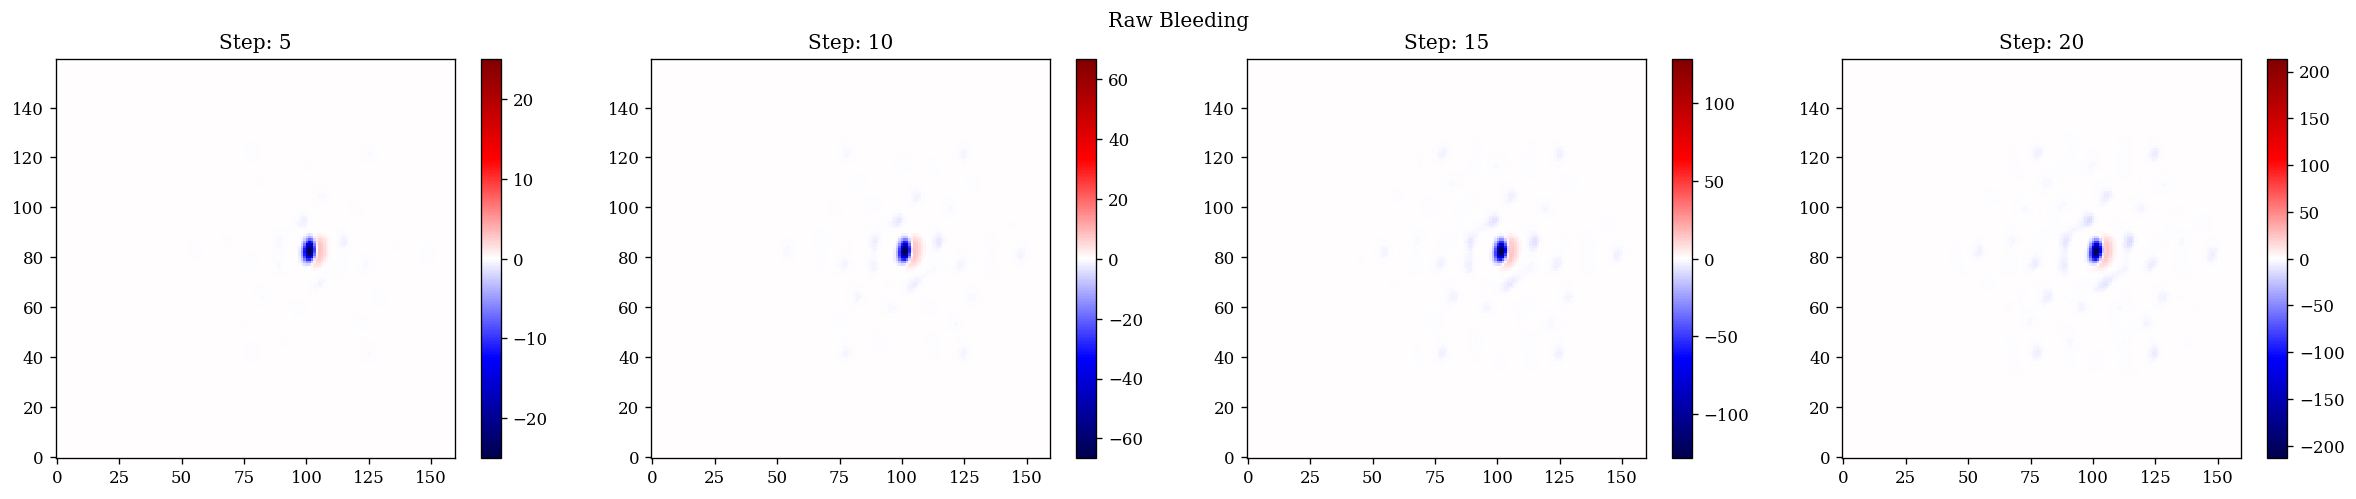

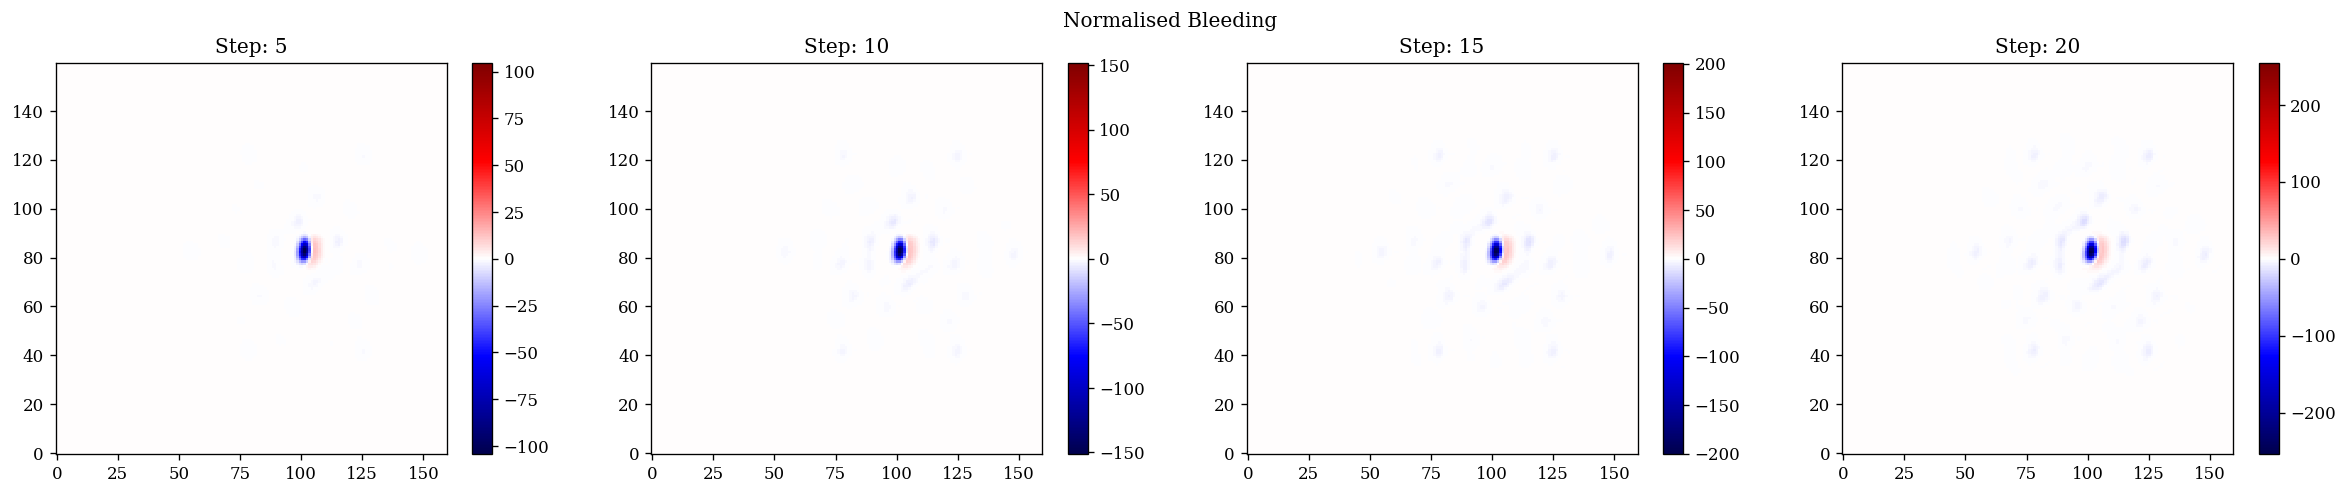

File jw04481001001_03106_00002_0001
Star HD-41094
Filter F430M
nints 905
ngroups 20



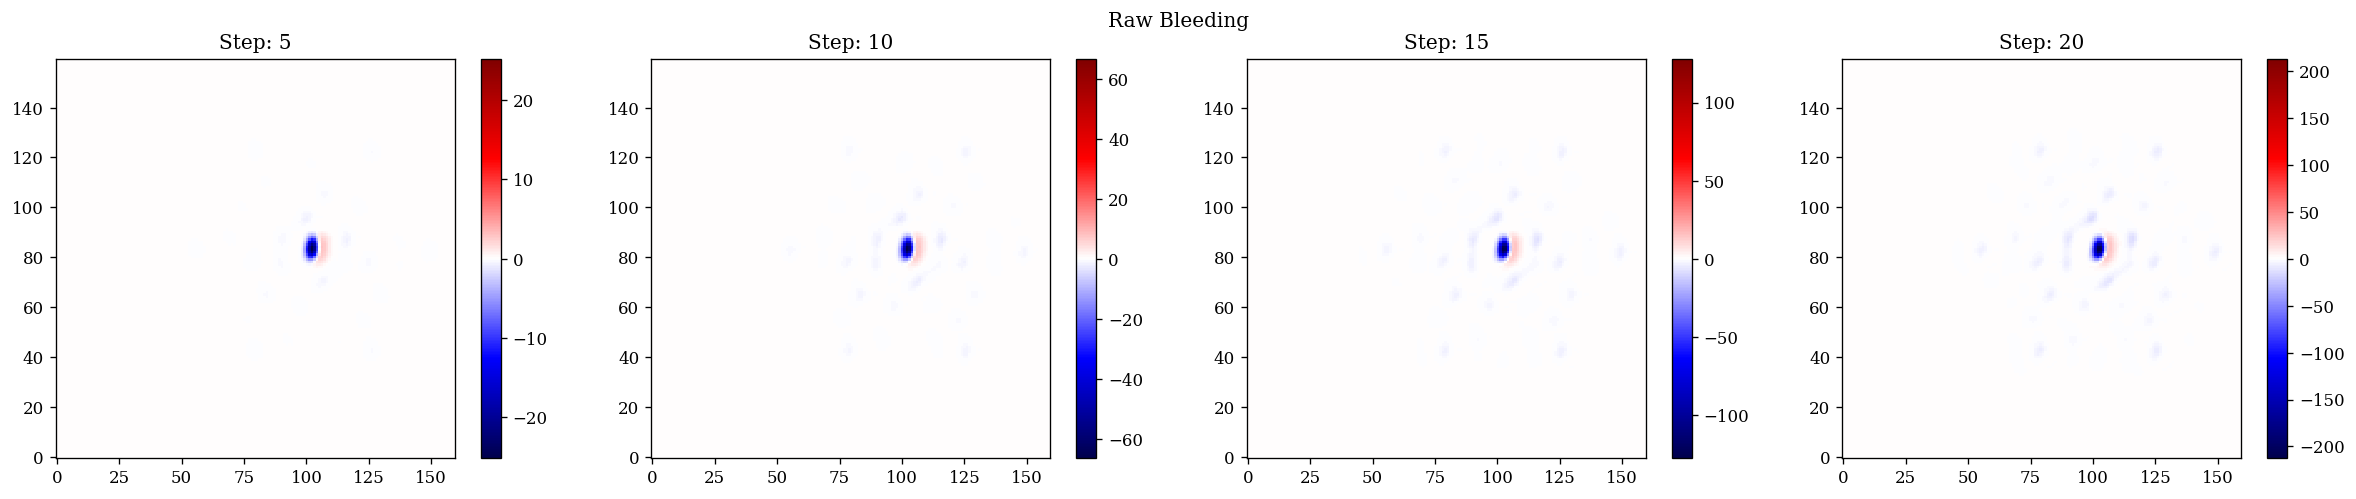

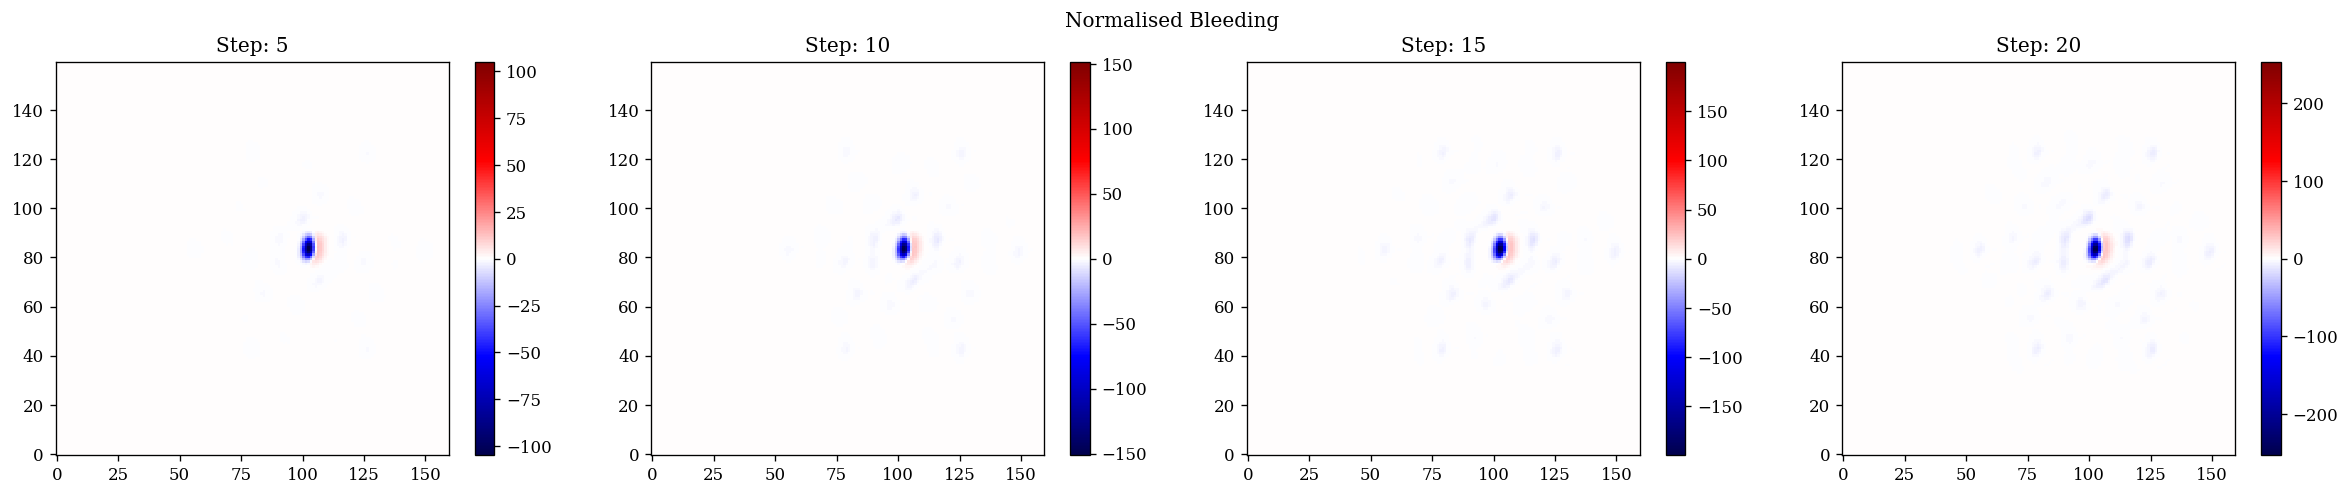

File jw04481001001_03102_00005_0001
Star HD-41094
Filter F480M
nints 760
ngroups 30



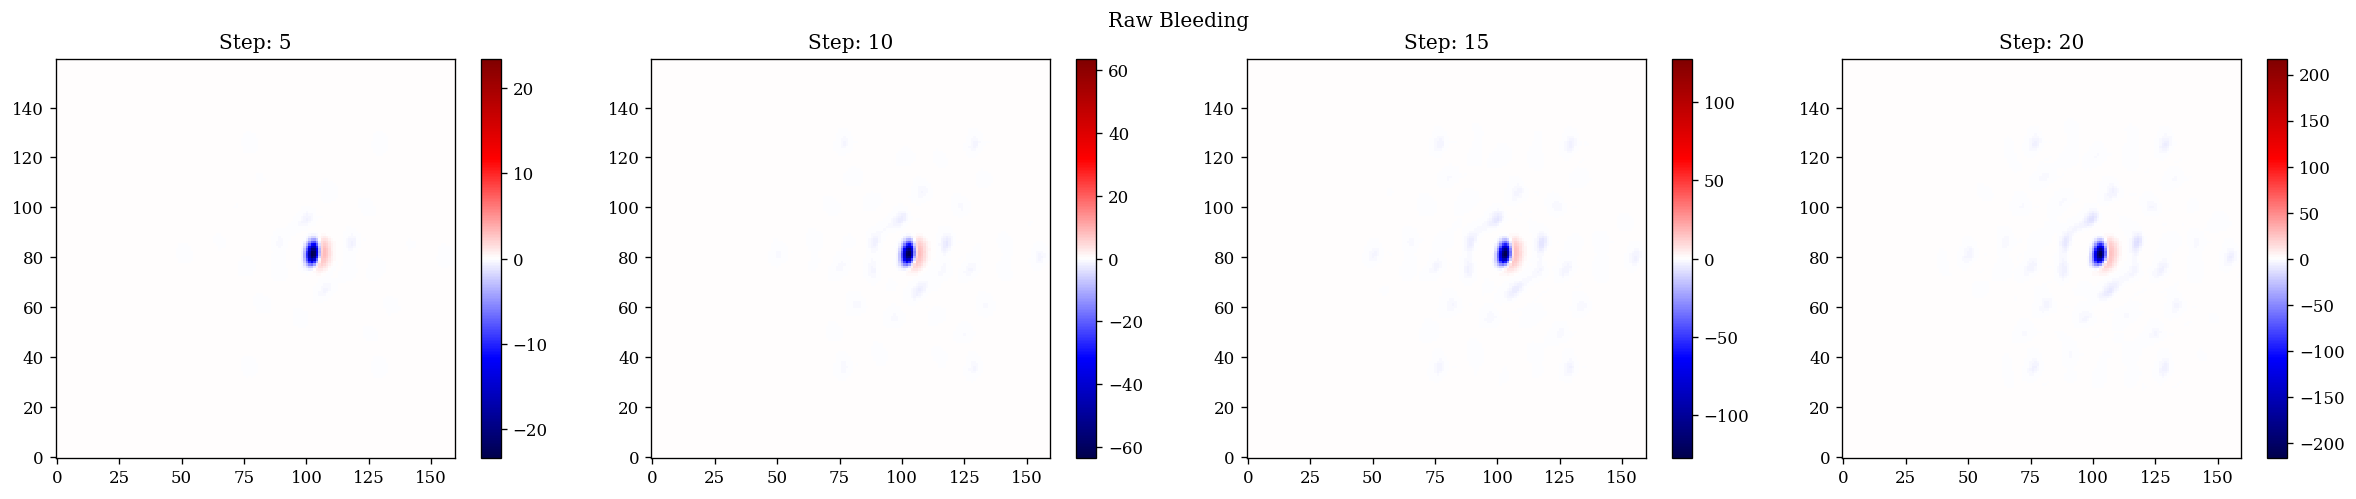

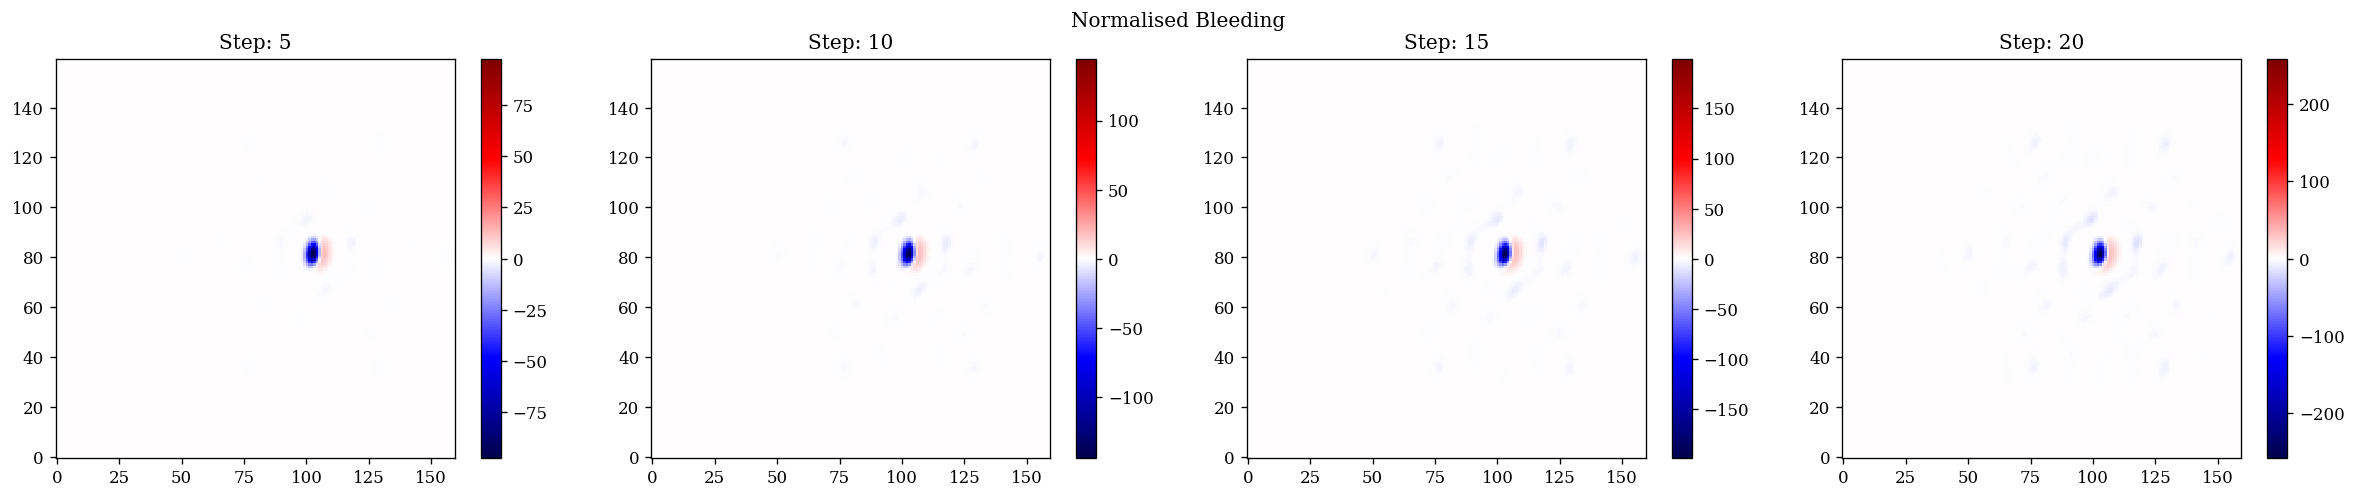

File jw04481001001_03102_00002_0001
Star HD-41094
Filter F480M
nints 760
ngroups 30



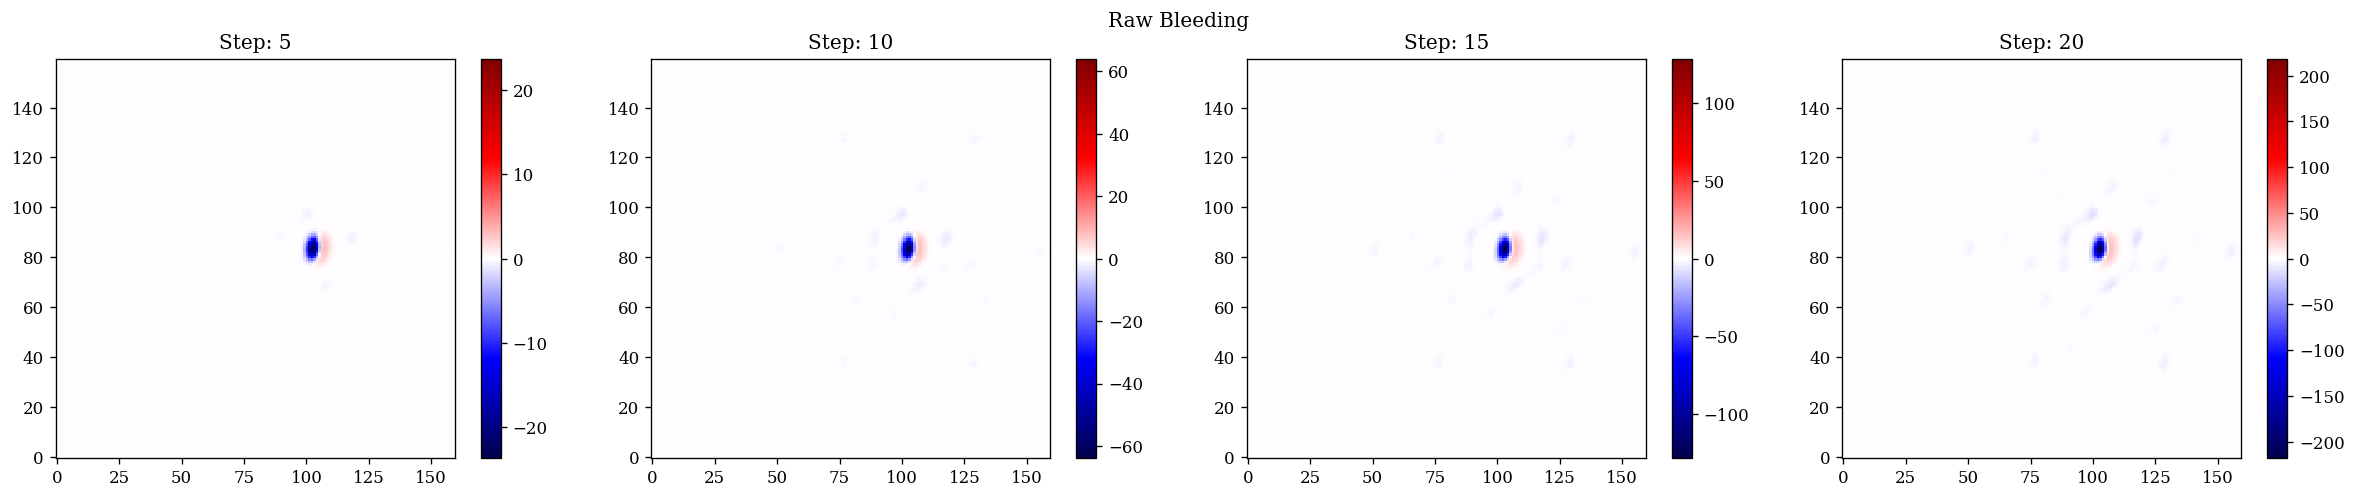

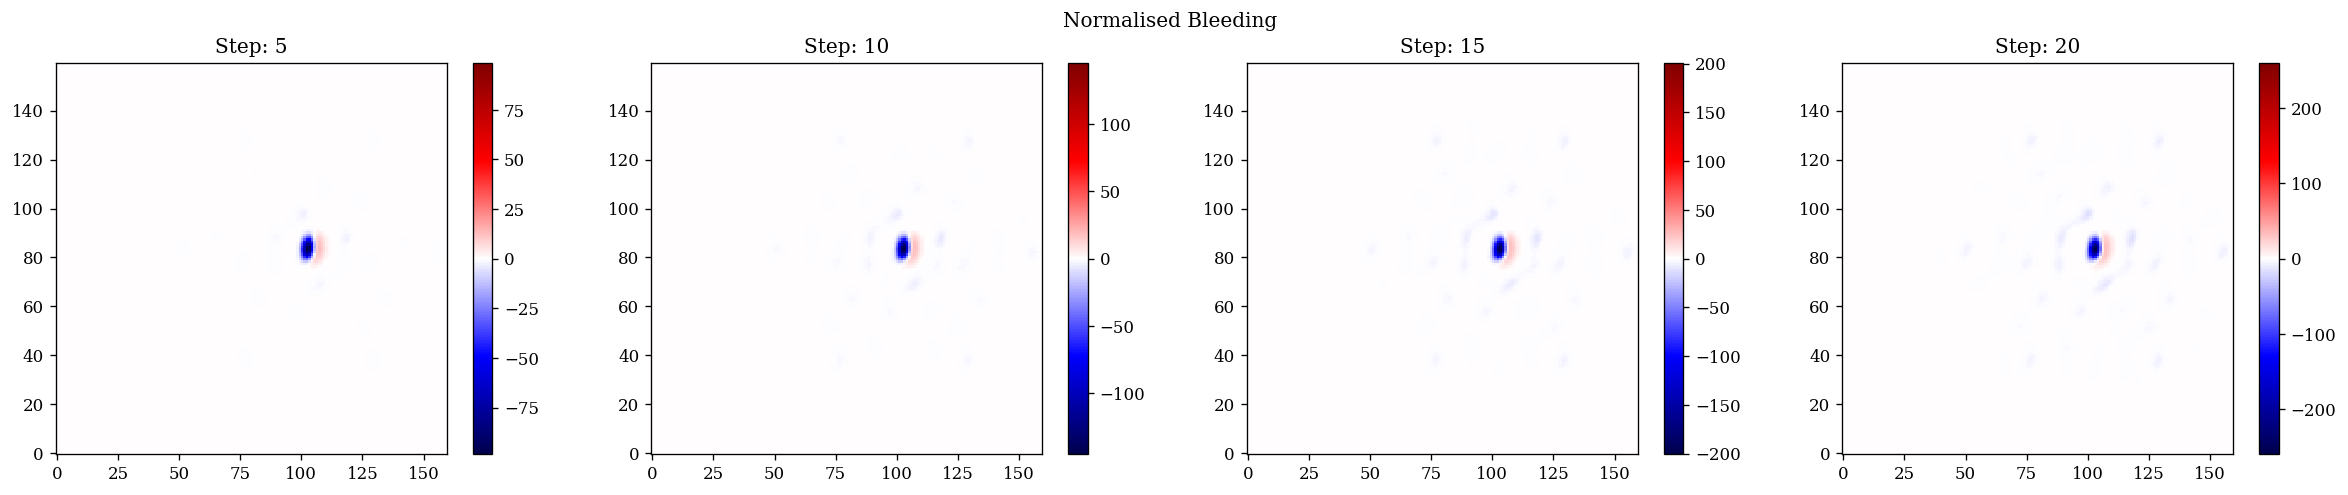

In [26]:
for exp in exposures:
    exp.print_summary()
    psf, flux, oversample = final_model.model(exp, to_BFE=True)
    ramp, bleed_ramp = final_model.ramp.bleeding_model(psf.data, exp.filter)

    ramp_vals = (np.arange(len(bleed_ramp)) + 1) / len(bleed_ramp)
    inv_ramp = 1 / ramp_vals

    inds = [5, 10, 15, 20]
    plt.figure(figsize=(20, 4))
    plt.suptitle("Raw Bleeding")
    for i in range(4):
        idx = inds[i]
        plt.subplot(1, 4, i + 1)
        bleed = bleed_ramp[idx][80:240, 80:240]
        v = np.nanmax(np.abs(bleed))
        plt.title(f"Step: {idx}")
        plt.imshow(bleed, cmap=seismic, vmin=-v, vmax=v)
        plt.colorbar()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 4))
    plt.suptitle("Normalised Bleeding")
    for i in range(4):
        idx = inds[i]
        plt.subplot(1, 4, i + 1)
        bleed = bleed_ramp[idx][80:240, 80:240] * inv_ramp[idx]
        v = np.nanmax(np.abs(bleed))
        plt.title(f"Step: {idx}")
        plt.imshow(bleed, cmap=seismic, vmin=-v, vmax=v)
        plt.colorbar()
    plt.tight_layout()
    plt.show()

In [14]:
import os
from datetime import date


def create_folder():
    root_path = 'files/models/'

    # Get the current date as a string
    current_date = str(date.today())
    base_path = root_path + current_date

    # Check if a folder with the current date exists, and if not, create it
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Get a list of all directories in the current date folder
    dirs = [
        d
        for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
    ]

    # Filter out directories that can't be converted to integers
    dirs = [d for d in dirs if d.isdigit()]

    # Convert the directory names to integers
    dirs = [int(d) for d in dirs]

    # Find the lowest integer that doesn't exist in the list
    next_int = 0
    while next_int in dirs:
        next_int += 1

    # Create a directory with the next integer
    next_dir = os.path.join(base_path, str(next_int))
    os.makedirs(next_dir)

    os.makedirs(next_dir + "/exposures/")

    return next_dir

In [15]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
from zodiax.experimental import serialise
save_path = create_folder()

save_path = 'files/'

serialise(save_path + "reg_history.zdx", histories[0])
serialise(save_path + "batch_history.zdx", histories[0])

In [ ]:
from zodiax.experimental import serialise

save_path = create_folder()

# eqx.tree_serialise_leaves(f"{save_path}/CNN_BFE.eqx", final_model.BFE)
serialise(f"{save_path}/BFE", final_model.BFE)
serialise(f"{save_path}/AMI_mask", final_model.pupil_mask)
serialise(f"{save_path}/anisotropy", final_model.anisotropy)
serialise(f"{save_path}/reflectivities", final_model.optics.holes)
np.save(f"{save_path}/dark_current", final_model.detector.dark_current)


# for exp in exposures:
#     key = exp.key
# exp = exp.set('bias', model.biases[key])
# exp = exp.set('one_on_fs', model.one_on_fs[key])
# exp = exp.set('position', model.positions[key])
# exp = exp.set("aberrations", model.aberrations[key])
# exp = exp.set('flux', model.fluxes[key])
# serialise(f"{save_path}/exposures/{key}", exp)

print(save_path)

files/models/2024-04-23/0
